# Miller age

In [1]:
ood_seed = 3

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "dataset_complete_Miller.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["age"] = adata.obs["age"].astype("str").astype("category")

adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
adata.obs["age_int"] = adata.obs["age"].astype(str).astype(float).astype(int).astype(str).astype("category")

adata.obs["age_continuous"] = adata.obs["age"].astype(float)
df = adata.obs.groupby(["cell_type", "age"]).size()
df2 = adata.obs.groupby(["cell_type"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 100 and df2[i[0]] > 350]

In [7]:
df

cell_type                            age 
Bud tip adjacent cells               11.5    169
                                     15.0    282
                                     18.0    777
                                     21.0      0
Bud tip progenitor                   11.5    273
                                     15.0    338
                                     18.0    683
                                     21.0      2
Deuterosomal cells                   11.5      2
                                     15.0    145
                                     18.0    111
                                     21.0     49
Hub cells                            11.5    218
                                     15.0    308
                                     18.0    620
                                     21.0      2
Intermediate trachea ciliated cells  11.5      0
                                     15.0     59
                                     18.0      0
                           

In [8]:
availables, len(availables)

([(('Bud tip adjacent cells', '11.5'), 169),
  (('Bud tip adjacent cells', '15.0'), 282),
  (('Bud tip adjacent cells', '18.0'), 777),
  (('Bud tip progenitor', '11.5'), 273),
  (('Bud tip progenitor', '15.0'), 338),
  (('Bud tip progenitor', '18.0'), 683),
  (('Hub cells', '11.5'), 218),
  (('Hub cells', '15.0'), 308),
  (('Hub cells', '18.0'), 620),
  (('Lung ciliated cells', '15.0'), 692),
  (('Lung ciliated cells', '18.0'), 494),
  (('Lung ciliated cells', '21.0'), 165),
  (('Lung secretory cells', '15.0'), 595),
  (('Lung secretory cells', '21.0'), 438),
  (('Submucosal gland cells', '15.0'), 380),
  (('Submucosal gland cells', '18.0'), 156)],
 16)

In [9]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask


def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["cell_type"] == choice[0][0]) & (adata.obs["age"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('Bud tip progenitor', '11.5'), 273)


Removed datapoint: 273

train         5701
validation    1431
ood            273
Name: split, dtype: int64

In [10]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [11]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="age_int",
    control_group="11",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['integration_donor'],
)

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 94069.18it/s]

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 850507.18it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [12]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [13]:
model.train(max_epochs=400)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 179.96it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:09<1:00:10,  9.05s/it]

Epoch 1/400:   0%|          | 1/400 [00:09<1:00:10,  9.05s/it, v_num=1, recon=1.18e+3, r2_mean=0.0593, adv_loss=3.47, acc_pert=0.294, acc_integration_donor=0.142]

Epoch 2/400:   0%|          | 1/400 [00:09<1:00:10,  9.05s/it, v_num=1, recon=1.18e+3, r2_mean=0.0593, adv_loss=3.47, acc_pert=0.294, acc_integration_donor=0.142]

Epoch 2/400:   0%|          | 2/400 [00:11<35:20,  5.33s/it, v_num=1, recon=1.18e+3, r2_mean=0.0593, adv_loss=3.47, acc_pert=0.294, acc_integration_donor=0.142]  

Epoch 2/400:   0%|          | 2/400 [00:11<35:20,  5.33s/it, v_num=1, recon=1e+3, r2_mean=0.276, adv_loss=3.08, acc_pert=0.38, acc_integration_donor=0.37]      

Epoch 3/400:   0%|          | 2/400 [00:11<35:20,  5.33s/it, v_num=1, recon=1e+3, r2_mean=0.276, adv_loss=3.08, acc_pert=0.38, acc_integration_donor=0.37]

Epoch 3/400:   1%|          | 3/400 [00:14<27:01,  4.09s/it, v_num=1, recon=1e+3, r2_mean=0.276, adv_loss=3.08, acc_pert=0.38, acc_integration_donor=0.37]

Epoch 3/400:   1%|          | 3/400 [00:14<27:01,  4.09s/it, v_num=1, recon=927, r2_mean=0.362, adv_loss=2.7, acc_pert=0.498, acc_integration_donor=0.502]

Epoch 4/400:   1%|          | 3/400 [00:14<27:01,  4.09s/it, v_num=1, recon=927, r2_mean=0.362, adv_loss=2.7, acc_pert=0.498, acc_integration_donor=0.502]

Epoch 4/400:   1%|          | 4/400 [00:17<24:13,  3.67s/it, v_num=1, recon=927, r2_mean=0.362, adv_loss=2.7, acc_pert=0.498, acc_integration_donor=0.502]

Epoch 4/400:   1%|          | 4/400 [00:17<24:13,  3.67s/it, v_num=1, recon=892, r2_mean=0.409, adv_loss=2.47, acc_pert=0.559, acc_integration_donor=0.547]

Epoch 5/400:   1%|          | 4/400 [00:17<24:13,  3.67s/it, v_num=1, recon=892, r2_mean=0.409, adv_loss=2.47, acc_pert=0.559, acc_integration_donor=0.547]

Epoch 5/400:   1%|▏         | 5/400 [00:20<22:27,  3.41s/it, v_num=1, recon=892, r2_mean=0.409, adv_loss=2.47, acc_pert=0.559, acc_integration_donor=0.547]

Epoch 5/400:   1%|▏         | 5/400 [00:20<22:27,  3.41s/it, v_num=1, recon=873, r2_mean=0.43, adv_loss=2.33, acc_pert=0.559, acc_integration_donor=0.555] 

Epoch 6/400:   1%|▏         | 5/400 [00:20<22:27,  3.41s/it, v_num=1, recon=873, r2_mean=0.43, adv_loss=2.33, acc_pert=0.559, acc_integration_donor=0.555]

Epoch 6/400:   2%|▏         | 6/400 [00:22<20:39,  3.14s/it, v_num=1, recon=873, r2_mean=0.43, adv_loss=2.33, acc_pert=0.559, acc_integration_donor=0.555]

Epoch 6/400:   2%|▏         | 6/400 [00:22<20:39,  3.14s/it, v_num=1, recon=862, r2_mean=0.443, adv_loss=2.22, acc_pert=0.567, acc_integration_donor=0.566]

Epoch 7/400:   2%|▏         | 6/400 [00:22<20:39,  3.14s/it, v_num=1, recon=862, r2_mean=0.443, adv_loss=2.22, acc_pert=0.567, acc_integration_donor=0.566]

Epoch 7/400:   2%|▏         | 7/400 [00:25<19:33,  2.99s/it, v_num=1, recon=862, r2_mean=0.443, adv_loss=2.22, acc_pert=0.567, acc_integration_donor=0.566]

Epoch 7/400:   2%|▏         | 7/400 [00:25<19:33,  2.99s/it, v_num=1, recon=855, r2_mean=0.449, adv_loss=2.17, acc_pert=0.592, acc_integration_donor=0.566]

Epoch 8/400:   2%|▏         | 7/400 [00:25<19:33,  2.99s/it, v_num=1, recon=855, r2_mean=0.449, adv_loss=2.17, acc_pert=0.592, acc_integration_donor=0.566]

Epoch 8/400:   2%|▏         | 8/400 [00:28<18:52,  2.89s/it, v_num=1, recon=855, r2_mean=0.449, adv_loss=2.17, acc_pert=0.592, acc_integration_donor=0.566]

Epoch 8/400:   2%|▏         | 8/400 [00:28<18:52,  2.89s/it, v_num=1, recon=848, r2_mean=0.45, adv_loss=2.12, acc_pert=0.607, acc_integration_donor=0.571] 

Epoch 9/400:   2%|▏         | 8/400 [00:28<18:52,  2.89s/it, v_num=1, recon=848, r2_mean=0.45, adv_loss=2.12, acc_pert=0.607, acc_integration_donor=0.571]

Epoch 9/400:   2%|▏         | 9/400 [00:30<18:17,  2.81s/it, v_num=1, recon=848, r2_mean=0.45, adv_loss=2.12, acc_pert=0.607, acc_integration_donor=0.571]

Epoch 9/400:   2%|▏         | 9/400 [00:30<18:17,  2.81s/it, v_num=1, recon=842, r2_mean=0.46, adv_loss=2.12, acc_pert=0.603, acc_integration_donor=0.557]

Epoch 10/400:   2%|▏         | 9/400 [00:30<18:17,  2.81s/it, v_num=1, recon=842, r2_mean=0.46, adv_loss=2.12, acc_pert=0.603, acc_integration_donor=0.557]


disnt_basal = 0.5306821407627523

disnt_after = 0.951327022767953

val_r2_mean = 0.48652534943724435

val_r2_var = 0.1847347504799328


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [00:41<33:28,  5.15s/it, v_num=1, recon=842, r2_mean=0.46, adv_loss=2.12, acc_pert=0.603, acc_integration_donor=0.557]

Epoch 10/400:   2%|▎         | 10/400 [00:41<33:28,  5.15s/it, v_num=1, recon=838, r2_mean=0.47, adv_loss=2.15, acc_pert=0.575, acc_integration_donor=0.544, val_recon=881, disnt_basal=0.531, disnt_after=0.951, val_r2_mean=0.487, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [00:41<33:28,  5.15s/it, v_num=1, recon=838, r2_mean=0.47, adv_loss=2.15, acc_pert=0.575, acc_integration_donor=0.544, val_recon=881, disnt_basal=0.531, disnt_after=0.951, val_r2_mean=0.487, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:44<28:57,  4.47s/it, v_num=1, recon=838, r2_mean=0.47, adv_loss=2.15, acc_pert=0.575, acc_integration_donor=0.544, val_recon=881, disnt_basal=0.531, disnt_after=0.951, val_r2_mean=0.487, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:44<28:57,  4.47s/it, v_num=1, recon=834, r2_mean=0.474, adv_loss=2.17, acc_pert=0.562, acc_integration_donor=0.536, val_recon=881, disnt_basal=0.531, disnt_after=0.951, val_r2_mean=0.487, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [00:44<28:57,  4.47s/it, v_num=1, recon=834, r2_mean=0.474, adv_loss=2.17, acc_pert=0.562, acc_integration_donor=0.536, val_recon=881, disnt_basal=0.531, disnt_after=0.951, val_r2_mean=0.487, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:47<25:58,  4.02s/it, v_num=1, recon=834, r2_mean=0.474, adv_loss=2.17, acc_pert=0.562, acc_integration_donor=0.536, val_recon=881, disnt_basal=0.531, disnt_after=0.951, val_r2_mean=0.487, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:47<25:58,  4.02s/it, v_num=1, recon=830, r2_mean=0.476, adv_loss=2.17, acc_pert=0.552, acc_integration_donor=0.529, val_recon=881, disnt_basal=0.531, disnt_after=0.951, val_r2_mean=0.487, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [00:47<25:58,  4.02s/it, v_num=1, recon=830, r2_mean=0.476, adv_loss=2.17, acc_pert=0.552, acc_integration_donor=0.529, val_recon=881, disnt_basal=0.531, disnt_after=0.951, val_r2_mean=0.487, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:50<23:55,  3.71s/it, v_num=1, recon=830, r2_mean=0.476, adv_loss=2.17, acc_pert=0.552, acc_integration_donor=0.529, val_recon=881, disnt_basal=0.531, disnt_after=0.951, val_r2_mean=0.487, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:50<23:55,  3.71s/it, v_num=1, recon=827, r2_mean=0.483, adv_loss=2.19, acc_pert=0.534, acc_integration_donor=0.523, val_recon=881, disnt_basal=0.531, disnt_after=0.951, val_r2_mean=0.487, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [00:50<23:55,  3.71s/it, v_num=1, recon=827, r2_mean=0.483, adv_loss=2.19, acc_pert=0.534, acc_integration_donor=0.523, val_recon=881, disnt_basal=0.531, disnt_after=0.951, val_r2_mean=0.487, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:52<21:40,  3.37s/it, v_num=1, recon=827, r2_mean=0.483, adv_loss=2.19, acc_pert=0.534, acc_integration_donor=0.523, val_recon=881, disnt_basal=0.531, disnt_after=0.951, val_r2_mean=0.487, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:52<21:40,  3.37s/it, v_num=1, recon=822, r2_mean=0.486, adv_loss=2.19, acc_pert=0.545, acc_integration_donor=0.529, val_recon=881, disnt_basal=0.531, disnt_after=0.951, val_r2_mean=0.487, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [00:52<21:40,  3.37s/it, v_num=1, recon=822, r2_mean=0.486, adv_loss=2.19, acc_pert=0.545, acc_integration_donor=0.529, val_recon=881, disnt_basal=0.531, disnt_after=0.951, val_r2_mean=0.487, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:55<20:15,  3.16s/it, v_num=1, recon=822, r2_mean=0.486, adv_loss=2.19, acc_pert=0.545, acc_integration_donor=0.529, val_recon=881, disnt_basal=0.531, disnt_after=0.951, val_r2_mean=0.487, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:55<20:15,  3.16s/it, v_num=1, recon=819, r2_mean=0.491, adv_loss=2.18, acc_pert=0.568, acc_integration_donor=0.525, val_recon=881, disnt_basal=0.531, disnt_after=0.951, val_r2_mean=0.487, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [00:55<20:15,  3.16s/it, v_num=1, recon=819, r2_mean=0.491, adv_loss=2.18, acc_pert=0.568, acc_integration_donor=0.525, val_recon=881, disnt_basal=0.531, disnt_after=0.951, val_r2_mean=0.487, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:58<19:08,  2.99s/it, v_num=1, recon=819, r2_mean=0.491, adv_loss=2.18, acc_pert=0.568, acc_integration_donor=0.525, val_recon=881, disnt_basal=0.531, disnt_after=0.951, val_r2_mean=0.487, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:58<19:08,  2.99s/it, v_num=1, recon=818, r2_mean=0.495, adv_loss=2.18, acc_pert=0.557, acc_integration_donor=0.524, val_recon=881, disnt_basal=0.531, disnt_after=0.951, val_r2_mean=0.487, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [00:58<19:08,  2.99s/it, v_num=1, recon=818, r2_mean=0.495, adv_loss=2.18, acc_pert=0.557, acc_integration_donor=0.524, val_recon=881, disnt_basal=0.531, disnt_after=0.951, val_r2_mean=0.487, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [01:00<18:14,  2.86s/it, v_num=1, recon=818, r2_mean=0.495, adv_loss=2.18, acc_pert=0.557, acc_integration_donor=0.524, val_recon=881, disnt_basal=0.531, disnt_after=0.951, val_r2_mean=0.487, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [01:00<18:14,  2.86s/it, v_num=1, recon=815, r2_mean=0.496, adv_loss=2.18, acc_pert=0.559, acc_integration_donor=0.519, val_recon=881, disnt_basal=0.531, disnt_after=0.951, val_r2_mean=0.487, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [01:00<18:14,  2.86s/it, v_num=1, recon=815, r2_mean=0.496, adv_loss=2.18, acc_pert=0.559, acc_integration_donor=0.519, val_recon=881, disnt_basal=0.531, disnt_after=0.951, val_r2_mean=0.487, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:03<17:37,  2.77s/it, v_num=1, recon=815, r2_mean=0.496, adv_loss=2.18, acc_pert=0.559, acc_integration_donor=0.519, val_recon=881, disnt_basal=0.531, disnt_after=0.951, val_r2_mean=0.487, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:03<17:37,  2.77s/it, v_num=1, recon=812, r2_mean=0.497, adv_loss=2.19, acc_pert=0.553, acc_integration_donor=0.53, val_recon=881, disnt_basal=0.531, disnt_after=0.951, val_r2_mean=0.487, val_KL=nan] 

Epoch 19/400:   4%|▍         | 18/400 [01:03<17:37,  2.77s/it, v_num=1, recon=812, r2_mean=0.497, adv_loss=2.19, acc_pert=0.553, acc_integration_donor=0.53, val_recon=881, disnt_basal=0.531, disnt_after=0.951, val_r2_mean=0.487, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:05<17:12,  2.71s/it, v_num=1, recon=812, r2_mean=0.497, adv_loss=2.19, acc_pert=0.553, acc_integration_donor=0.53, val_recon=881, disnt_basal=0.531, disnt_after=0.951, val_r2_mean=0.487, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:05<17:12,  2.71s/it, v_num=1, recon=811, r2_mean=0.502, adv_loss=2.17, acc_pert=0.559, acc_integration_donor=0.526, val_recon=881, disnt_basal=0.531, disnt_after=0.951, val_r2_mean=0.487, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [01:05<17:12,  2.71s/it, v_num=1, recon=811, r2_mean=0.502, adv_loss=2.17, acc_pert=0.559, acc_integration_donor=0.526, val_recon=881, disnt_basal=0.531, disnt_after=0.951, val_r2_mean=0.487, val_KL=nan]


disnt_basal = 0.5094479607403455

disnt_after = 0.8861216584509158

val_r2_mean = 0.4890273220482326

val_r2_var = 0.29247006886298693

Epoch 20/400:   5%|▌         | 20/400 [01:23<45:01,  7.11s/it, v_num=1, recon=811, r2_mean=0.502, adv_loss=2.17, acc_pert=0.559, acc_integration_donor=0.526, val_recon=881, disnt_basal=0.531, disnt_after=0.951, val_r2_mean=0.487, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [01:23<45:01,  7.11s/it, v_num=1, recon=807, r2_mean=0.502, adv_loss=2.18, acc_pert=0.55, acc_integration_donor=0.524, val_recon=841, disnt_basal=0.509, disnt_after=0.886, val_r2_mean=0.489, val_KL=nan] 

Epoch 21/400:   5%|▌         | 20/400 [01:23<45:01,  7.11s/it, v_num=1, recon=807, r2_mean=0.502, adv_loss=2.18, acc_pert=0.55, acc_integration_donor=0.524, val_recon=841, disnt_basal=0.509, disnt_after=0.886, val_r2_mean=0.489, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:25<36:20,  5.75s/it, v_num=1, recon=807, r2_mean=0.502, adv_loss=2.18, acc_pert=0.55, acc_integration_donor=0.524, val_recon=841, disnt_basal=0.509, disnt_after=0.886, val_r2_mean=0.489, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:25<36:20,  5.75s/it, v_num=1, recon=806, r2_mean=0.505, adv_loss=2.2, acc_pert=0.544, acc_integration_donor=0.528, val_recon=841, disnt_basal=0.509, disnt_after=0.886, val_r2_mean=0.489, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [01:25<36:20,  5.75s/it, v_num=1, recon=806, r2_mean=0.505, adv_loss=2.2, acc_pert=0.544, acc_integration_donor=0.528, val_recon=841, disnt_basal=0.509, disnt_after=0.886, val_r2_mean=0.489, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:28<30:11,  4.79s/it, v_num=1, recon=806, r2_mean=0.505, adv_loss=2.2, acc_pert=0.544, acc_integration_donor=0.528, val_recon=841, disnt_basal=0.509, disnt_after=0.886, val_r2_mean=0.489, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:28<30:11,  4.79s/it, v_num=1, recon=805, r2_mean=0.508, adv_loss=2.2, acc_pert=0.555, acc_integration_donor=0.527, val_recon=841, disnt_basal=0.509, disnt_after=0.886, val_r2_mean=0.489, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [01:28<30:11,  4.79s/it, v_num=1, recon=805, r2_mean=0.508, adv_loss=2.2, acc_pert=0.555, acc_integration_donor=0.527, val_recon=841, disnt_basal=0.509, disnt_after=0.886, val_r2_mean=0.489, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:30<25:56,  4.13s/it, v_num=1, recon=805, r2_mean=0.508, adv_loss=2.2, acc_pert=0.555, acc_integration_donor=0.527, val_recon=841, disnt_basal=0.509, disnt_after=0.886, val_r2_mean=0.489, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:30<25:56,  4.13s/it, v_num=1, recon=803, r2_mean=0.505, adv_loss=2.17, acc_pert=0.549, acc_integration_donor=0.527, val_recon=841, disnt_basal=0.509, disnt_after=0.886, val_r2_mean=0.489, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [01:30<25:56,  4.13s/it, v_num=1, recon=803, r2_mean=0.505, adv_loss=2.17, acc_pert=0.549, acc_integration_donor=0.527, val_recon=841, disnt_basal=0.509, disnt_after=0.886, val_r2_mean=0.489, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:33<22:53,  3.65s/it, v_num=1, recon=803, r2_mean=0.505, adv_loss=2.17, acc_pert=0.549, acc_integration_donor=0.527, val_recon=841, disnt_basal=0.509, disnt_after=0.886, val_r2_mean=0.489, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:33<22:53,  3.65s/it, v_num=1, recon=802, r2_mean=0.51, adv_loss=2.19, acc_pert=0.547, acc_integration_donor=0.525, val_recon=841, disnt_basal=0.509, disnt_after=0.886, val_r2_mean=0.489, val_KL=nan] 

Epoch 25/400:   6%|▌         | 24/400 [01:33<22:53,  3.65s/it, v_num=1, recon=802, r2_mean=0.51, adv_loss=2.19, acc_pert=0.547, acc_integration_donor=0.525, val_recon=841, disnt_basal=0.509, disnt_after=0.886, val_r2_mean=0.489, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:35<20:41,  3.31s/it, v_num=1, recon=802, r2_mean=0.51, adv_loss=2.19, acc_pert=0.547, acc_integration_donor=0.525, val_recon=841, disnt_basal=0.509, disnt_after=0.886, val_r2_mean=0.489, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:35<20:41,  3.31s/it, v_num=1, recon=801, r2_mean=0.514, adv_loss=2.21, acc_pert=0.54, acc_integration_donor=0.527, val_recon=841, disnt_basal=0.509, disnt_after=0.886, val_r2_mean=0.489, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [01:35<20:41,  3.31s/it, v_num=1, recon=801, r2_mean=0.514, adv_loss=2.21, acc_pert=0.54, acc_integration_donor=0.527, val_recon=841, disnt_basal=0.509, disnt_after=0.886, val_r2_mean=0.489, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:38<19:13,  3.08s/it, v_num=1, recon=801, r2_mean=0.514, adv_loss=2.21, acc_pert=0.54, acc_integration_donor=0.527, val_recon=841, disnt_basal=0.509, disnt_after=0.886, val_r2_mean=0.489, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:38<19:13,  3.08s/it, v_num=1, recon=798, r2_mean=0.516, adv_loss=2.19, acc_pert=0.547, acc_integration_donor=0.529, val_recon=841, disnt_basal=0.509, disnt_after=0.886, val_r2_mean=0.489, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [01:38<19:13,  3.08s/it, v_num=1, recon=798, r2_mean=0.516, adv_loss=2.19, acc_pert=0.547, acc_integration_donor=0.529, val_recon=841, disnt_basal=0.509, disnt_after=0.886, val_r2_mean=0.489, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:40<18:03,  2.90s/it, v_num=1, recon=798, r2_mean=0.516, adv_loss=2.19, acc_pert=0.547, acc_integration_donor=0.529, val_recon=841, disnt_basal=0.509, disnt_after=0.886, val_r2_mean=0.489, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:40<18:03,  2.90s/it, v_num=1, recon=797, r2_mean=0.518, adv_loss=2.22, acc_pert=0.538, acc_integration_donor=0.524, val_recon=841, disnt_basal=0.509, disnt_after=0.886, val_r2_mean=0.489, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [01:40<18:03,  2.90s/it, v_num=1, recon=797, r2_mean=0.518, adv_loss=2.22, acc_pert=0.538, acc_integration_donor=0.524, val_recon=841, disnt_basal=0.509, disnt_after=0.886, val_r2_mean=0.489, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:43<17:26,  2.81s/it, v_num=1, recon=797, r2_mean=0.518, adv_loss=2.22, acc_pert=0.538, acc_integration_donor=0.524, val_recon=841, disnt_basal=0.509, disnt_after=0.886, val_r2_mean=0.489, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:43<17:26,  2.81s/it, v_num=1, recon=795, r2_mean=0.517, adv_loss=2.23, acc_pert=0.529, acc_integration_donor=0.518, val_recon=841, disnt_basal=0.509, disnt_after=0.886, val_r2_mean=0.489, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [01:43<17:26,  2.81s/it, v_num=1, recon=795, r2_mean=0.517, adv_loss=2.23, acc_pert=0.529, acc_integration_donor=0.518, val_recon=841, disnt_basal=0.509, disnt_after=0.886, val_r2_mean=0.489, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:46<17:26,  2.82s/it, v_num=1, recon=795, r2_mean=0.517, adv_loss=2.23, acc_pert=0.529, acc_integration_donor=0.518, val_recon=841, disnt_basal=0.509, disnt_after=0.886, val_r2_mean=0.489, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:46<17:26,  2.82s/it, v_num=1, recon=795, r2_mean=0.517, adv_loss=2.22, acc_pert=0.537, acc_integration_donor=0.527, val_recon=841, disnt_basal=0.509, disnt_after=0.886, val_r2_mean=0.489, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [01:46<17:26,  2.82s/it, v_num=1, recon=795, r2_mean=0.517, adv_loss=2.22, acc_pert=0.537, acc_integration_donor=0.527, val_recon=841, disnt_basal=0.509, disnt_after=0.886, val_r2_mean=0.489, val_KL=nan]


disnt_basal = 0.48579176276484054

disnt_after = 0.8852623918007877

val_r2_mean = 0.4800185148737261

val_r2_var = 0.3152737990021706


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [01:57<33:28,  5.43s/it, v_num=1, recon=795, r2_mean=0.517, adv_loss=2.22, acc_pert=0.537, acc_integration_donor=0.527, val_recon=841, disnt_basal=0.509, disnt_after=0.886, val_r2_mean=0.489, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [01:57<33:28,  5.43s/it, v_num=1, recon=793, r2_mean=0.525, adv_loss=2.22, acc_pert=0.535, acc_integration_donor=0.523, val_recon=834, disnt_basal=0.486, disnt_after=0.885, val_r2_mean=0.48, val_KL=nan] 

Epoch 31/400:   8%|▊         | 30/400 [01:57<33:28,  5.43s/it, v_num=1, recon=793, r2_mean=0.525, adv_loss=2.22, acc_pert=0.535, acc_integration_donor=0.523, val_recon=834, disnt_basal=0.486, disnt_after=0.885, val_r2_mean=0.48, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [02:00<28:25,  4.62s/it, v_num=1, recon=793, r2_mean=0.525, adv_loss=2.22, acc_pert=0.535, acc_integration_donor=0.523, val_recon=834, disnt_basal=0.486, disnt_after=0.885, val_r2_mean=0.48, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [02:00<28:25,  4.62s/it, v_num=1, recon=793, r2_mean=0.522, adv_loss=2.24, acc_pert=0.523, acc_integration_donor=0.521, val_recon=834, disnt_basal=0.486, disnt_after=0.885, val_r2_mean=0.48, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [02:00<28:25,  4.62s/it, v_num=1, recon=793, r2_mean=0.522, adv_loss=2.24, acc_pert=0.523, acc_integration_donor=0.521, val_recon=834, disnt_basal=0.486, disnt_after=0.885, val_r2_mean=0.48, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [02:03<24:51,  4.05s/it, v_num=1, recon=793, r2_mean=0.522, adv_loss=2.24, acc_pert=0.523, acc_integration_donor=0.521, val_recon=834, disnt_basal=0.486, disnt_after=0.885, val_r2_mean=0.48, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [02:03<24:51,  4.05s/it, v_num=1, recon=791, r2_mean=0.528, adv_loss=2.24, acc_pert=0.529, acc_integration_donor=0.519, val_recon=834, disnt_basal=0.486, disnt_after=0.885, val_r2_mean=0.48, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [02:03<24:51,  4.05s/it, v_num=1, recon=791, r2_mean=0.528, adv_loss=2.24, acc_pert=0.529, acc_integration_donor=0.519, val_recon=834, disnt_basal=0.486, disnt_after=0.885, val_r2_mean=0.48, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [02:06<22:22,  3.66s/it, v_num=1, recon=791, r2_mean=0.528, adv_loss=2.24, acc_pert=0.529, acc_integration_donor=0.519, val_recon=834, disnt_basal=0.486, disnt_after=0.885, val_r2_mean=0.48, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [02:06<22:22,  3.66s/it, v_num=1, recon=789, r2_mean=0.522, adv_loss=2.27, acc_pert=0.524, acc_integration_donor=0.526, val_recon=834, disnt_basal=0.486, disnt_after=0.885, val_r2_mean=0.48, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [02:06<22:22,  3.66s/it, v_num=1, recon=789, r2_mean=0.522, adv_loss=2.27, acc_pert=0.524, acc_integration_donor=0.526, val_recon=834, disnt_basal=0.486, disnt_after=0.885, val_r2_mean=0.48, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:08<20:31,  3.37s/it, v_num=1, recon=789, r2_mean=0.522, adv_loss=2.27, acc_pert=0.524, acc_integration_donor=0.526, val_recon=834, disnt_basal=0.486, disnt_after=0.885, val_r2_mean=0.48, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:08<20:31,  3.37s/it, v_num=1, recon=788, r2_mean=0.524, adv_loss=2.27, acc_pert=0.519, acc_integration_donor=0.521, val_recon=834, disnt_basal=0.486, disnt_after=0.885, val_r2_mean=0.48, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [02:08<20:31,  3.37s/it, v_num=1, recon=788, r2_mean=0.524, adv_loss=2.27, acc_pert=0.519, acc_integration_donor=0.521, val_recon=834, disnt_basal=0.486, disnt_after=0.885, val_r2_mean=0.48, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:11<19:48,  3.26s/it, v_num=1, recon=788, r2_mean=0.524, adv_loss=2.27, acc_pert=0.519, acc_integration_donor=0.521, val_recon=834, disnt_basal=0.486, disnt_after=0.885, val_r2_mean=0.48, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:11<19:48,  3.26s/it, v_num=1, recon=788, r2_mean=0.527, adv_loss=2.26, acc_pert=0.522, acc_integration_donor=0.52, val_recon=834, disnt_basal=0.486, disnt_after=0.885, val_r2_mean=0.48, val_KL=nan] 

Epoch 36/400:   9%|▉         | 35/400 [02:11<19:48,  3.26s/it, v_num=1, recon=788, r2_mean=0.527, adv_loss=2.26, acc_pert=0.522, acc_integration_donor=0.52, val_recon=834, disnt_basal=0.486, disnt_after=0.885, val_r2_mean=0.48, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:14<18:50,  3.10s/it, v_num=1, recon=788, r2_mean=0.527, adv_loss=2.26, acc_pert=0.522, acc_integration_donor=0.52, val_recon=834, disnt_basal=0.486, disnt_after=0.885, val_r2_mean=0.48, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:14<18:50,  3.10s/it, v_num=1, recon=788, r2_mean=0.529, adv_loss=2.29, acc_pert=0.51, acc_integration_donor=0.524, val_recon=834, disnt_basal=0.486, disnt_after=0.885, val_r2_mean=0.48, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [02:14<18:50,  3.10s/it, v_num=1, recon=788, r2_mean=0.529, adv_loss=2.29, acc_pert=0.51, acc_integration_donor=0.524, val_recon=834, disnt_basal=0.486, disnt_after=0.885, val_r2_mean=0.48, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:17<18:00,  2.98s/it, v_num=1, recon=788, r2_mean=0.529, adv_loss=2.29, acc_pert=0.51, acc_integration_donor=0.524, val_recon=834, disnt_basal=0.486, disnt_after=0.885, val_r2_mean=0.48, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:17<18:00,  2.98s/it, v_num=1, recon=786, r2_mean=0.533, adv_loss=2.31, acc_pert=0.504, acc_integration_donor=0.526, val_recon=834, disnt_basal=0.486, disnt_after=0.885, val_r2_mean=0.48, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [02:17<18:00,  2.98s/it, v_num=1, recon=786, r2_mean=0.533, adv_loss=2.31, acc_pert=0.504, acc_integration_donor=0.526, val_recon=834, disnt_basal=0.486, disnt_after=0.885, val_r2_mean=0.48, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [02:19<17:27,  2.89s/it, v_num=1, recon=786, r2_mean=0.533, adv_loss=2.31, acc_pert=0.504, acc_integration_donor=0.526, val_recon=834, disnt_basal=0.486, disnt_after=0.885, val_r2_mean=0.48, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [02:19<17:27,  2.89s/it, v_num=1, recon=784, r2_mean=0.527, adv_loss=2.3, acc_pert=0.505, acc_integration_donor=0.522, val_recon=834, disnt_basal=0.486, disnt_after=0.885, val_r2_mean=0.48, val_KL=nan] 

Epoch 39/400:  10%|▉         | 38/400 [02:19<17:27,  2.89s/it, v_num=1, recon=784, r2_mean=0.527, adv_loss=2.3, acc_pert=0.505, acc_integration_donor=0.522, val_recon=834, disnt_basal=0.486, disnt_after=0.885, val_r2_mean=0.48, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [02:22<17:07,  2.85s/it, v_num=1, recon=784, r2_mean=0.527, adv_loss=2.3, acc_pert=0.505, acc_integration_donor=0.522, val_recon=834, disnt_basal=0.486, disnt_after=0.885, val_r2_mean=0.48, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [02:22<17:07,  2.85s/it, v_num=1, recon=783, r2_mean=0.533, adv_loss=2.31, acc_pert=0.495, acc_integration_donor=0.519, val_recon=834, disnt_basal=0.486, disnt_after=0.885, val_r2_mean=0.48, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [02:22<17:07,  2.85s/it, v_num=1, recon=783, r2_mean=0.533, adv_loss=2.31, acc_pert=0.495, acc_integration_donor=0.519, val_recon=834, disnt_basal=0.486, disnt_after=0.885, val_r2_mean=0.48, val_KL=nan]


disnt_basal = 0.48420675571613897

disnt_after = 0.9013224649721967

val_r2_mean = 0.4949420535848254

val_r2_var = 0.3541720123518081


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [02:28<22:33,  3.76s/it, v_num=1, recon=783, r2_mean=0.533, adv_loss=2.31, acc_pert=0.495, acc_integration_donor=0.519, val_recon=834, disnt_basal=0.486, disnt_after=0.885, val_r2_mean=0.48, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [02:28<22:33,  3.76s/it, v_num=1, recon=782, r2_mean=0.533, adv_loss=2.33, acc_pert=0.498, acc_integration_donor=0.516, val_recon=839, disnt_basal=0.484, disnt_after=0.901, val_r2_mean=0.495, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [02:28<22:33,  3.76s/it, v_num=1, recon=782, r2_mean=0.533, adv_loss=2.33, acc_pert=0.498, acc_integration_donor=0.516, val_recon=839, disnt_basal=0.484, disnt_after=0.901, val_r2_mean=0.495, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [02:31<20:27,  3.42s/it, v_num=1, recon=782, r2_mean=0.533, adv_loss=2.33, acc_pert=0.498, acc_integration_donor=0.516, val_recon=839, disnt_basal=0.484, disnt_after=0.901, val_r2_mean=0.495, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [02:31<20:27,  3.42s/it, v_num=1, recon=781, r2_mean=0.539, adv_loss=2.32, acc_pert=0.488, acc_integration_donor=0.522, val_recon=839, disnt_basal=0.484, disnt_after=0.901, val_r2_mean=0.495, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [02:31<20:27,  3.42s/it, v_num=1, recon=781, r2_mean=0.539, adv_loss=2.32, acc_pert=0.488, acc_integration_donor=0.522, val_recon=839, disnt_basal=0.484, disnt_after=0.901, val_r2_mean=0.495, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [02:33<18:58,  3.18s/it, v_num=1, recon=781, r2_mean=0.539, adv_loss=2.32, acc_pert=0.488, acc_integration_donor=0.522, val_recon=839, disnt_basal=0.484, disnt_after=0.901, val_r2_mean=0.495, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [02:33<18:58,  3.18s/it, v_num=1, recon=779, r2_mean=0.534, adv_loss=2.35, acc_pert=0.48, acc_integration_donor=0.517, val_recon=839, disnt_basal=0.484, disnt_after=0.901, val_r2_mean=0.495, val_KL=nan] 

Epoch 43/400:  10%|█         | 42/400 [02:33<18:58,  3.18s/it, v_num=1, recon=779, r2_mean=0.534, adv_loss=2.35, acc_pert=0.48, acc_integration_donor=0.517, val_recon=839, disnt_basal=0.484, disnt_after=0.901, val_r2_mean=0.495, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [02:37<20:33,  3.46s/it, v_num=1, recon=779, r2_mean=0.534, adv_loss=2.35, acc_pert=0.48, acc_integration_donor=0.517, val_recon=839, disnt_basal=0.484, disnt_after=0.901, val_r2_mean=0.495, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [02:37<20:33,  3.46s/it, v_num=1, recon=779, r2_mean=0.535, adv_loss=2.34, acc_pert=0.488, acc_integration_donor=0.517, val_recon=839, disnt_basal=0.484, disnt_after=0.901, val_r2_mean=0.495, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [02:37<20:33,  3.46s/it, v_num=1, recon=779, r2_mean=0.535, adv_loss=2.34, acc_pert=0.488, acc_integration_donor=0.517, val_recon=839, disnt_basal=0.484, disnt_after=0.901, val_r2_mean=0.495, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [02:40<18:55,  3.19s/it, v_num=1, recon=779, r2_mean=0.535, adv_loss=2.34, acc_pert=0.488, acc_integration_donor=0.517, val_recon=839, disnt_basal=0.484, disnt_after=0.901, val_r2_mean=0.495, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [02:40<18:55,  3.19s/it, v_num=1, recon=779, r2_mean=0.532, adv_loss=2.36, acc_pert=0.466, acc_integration_donor=0.525, val_recon=839, disnt_basal=0.484, disnt_after=0.901, val_r2_mean=0.495, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [02:40<18:55,  3.19s/it, v_num=1, recon=779, r2_mean=0.532, adv_loss=2.36, acc_pert=0.466, acc_integration_donor=0.525, val_recon=839, disnt_basal=0.484, disnt_after=0.901, val_r2_mean=0.495, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [02:43<17:56,  3.03s/it, v_num=1, recon=779, r2_mean=0.532, adv_loss=2.36, acc_pert=0.466, acc_integration_donor=0.525, val_recon=839, disnt_basal=0.484, disnt_after=0.901, val_r2_mean=0.495, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [02:43<17:56,  3.03s/it, v_num=1, recon=778, r2_mean=0.543, adv_loss=2.34, acc_pert=0.475, acc_integration_donor=0.517, val_recon=839, disnt_basal=0.484, disnt_after=0.901, val_r2_mean=0.495, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [02:43<17:56,  3.03s/it, v_num=1, recon=778, r2_mean=0.543, adv_loss=2.34, acc_pert=0.475, acc_integration_donor=0.517, val_recon=839, disnt_basal=0.484, disnt_after=0.901, val_r2_mean=0.495, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [02:45<17:06,  2.90s/it, v_num=1, recon=778, r2_mean=0.543, adv_loss=2.34, acc_pert=0.475, acc_integration_donor=0.517, val_recon=839, disnt_basal=0.484, disnt_after=0.901, val_r2_mean=0.495, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [02:45<17:06,  2.90s/it, v_num=1, recon=777, r2_mean=0.538, adv_loss=2.37, acc_pert=0.475, acc_integration_donor=0.521, val_recon=839, disnt_basal=0.484, disnt_after=0.901, val_r2_mean=0.495, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [02:45<17:06,  2.90s/it, v_num=1, recon=777, r2_mean=0.538, adv_loss=2.37, acc_pert=0.475, acc_integration_donor=0.521, val_recon=839, disnt_basal=0.484, disnt_after=0.901, val_r2_mean=0.495, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [02:48<16:39,  2.83s/it, v_num=1, recon=777, r2_mean=0.538, adv_loss=2.37, acc_pert=0.475, acc_integration_donor=0.521, val_recon=839, disnt_basal=0.484, disnt_after=0.901, val_r2_mean=0.495, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [02:48<16:39,  2.83s/it, v_num=1, recon=776, r2_mean=0.538, adv_loss=2.37, acc_pert=0.481, acc_integration_donor=0.525, val_recon=839, disnt_basal=0.484, disnt_after=0.901, val_r2_mean=0.495, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [02:48<16:39,  2.83s/it, v_num=1, recon=776, r2_mean=0.538, adv_loss=2.37, acc_pert=0.481, acc_integration_donor=0.525, val_recon=839, disnt_basal=0.484, disnt_after=0.901, val_r2_mean=0.495, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [02:51<16:14,  2.77s/it, v_num=1, recon=776, r2_mean=0.538, adv_loss=2.37, acc_pert=0.481, acc_integration_donor=0.525, val_recon=839, disnt_basal=0.484, disnt_after=0.901, val_r2_mean=0.495, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [02:51<16:14,  2.77s/it, v_num=1, recon=775, r2_mean=0.536, adv_loss=2.36, acc_pert=0.474, acc_integration_donor=0.521, val_recon=839, disnt_basal=0.484, disnt_after=0.901, val_r2_mean=0.495, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [02:51<16:14,  2.77s/it, v_num=1, recon=775, r2_mean=0.536, adv_loss=2.36, acc_pert=0.474, acc_integration_donor=0.521, val_recon=839, disnt_basal=0.484, disnt_after=0.901, val_r2_mean=0.495, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [02:53<15:51,  2.71s/it, v_num=1, recon=775, r2_mean=0.536, adv_loss=2.36, acc_pert=0.474, acc_integration_donor=0.521, val_recon=839, disnt_basal=0.484, disnt_after=0.901, val_r2_mean=0.495, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [02:53<15:51,  2.71s/it, v_num=1, recon=774, r2_mean=0.543, adv_loss=2.36, acc_pert=0.486, acc_integration_donor=0.515, val_recon=839, disnt_basal=0.484, disnt_after=0.901, val_r2_mean=0.495, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [02:53<15:51,  2.71s/it, v_num=1, recon=774, r2_mean=0.543, adv_loss=2.36, acc_pert=0.486, acc_integration_donor=0.515, val_recon=839, disnt_basal=0.484, disnt_after=0.901, val_r2_mean=0.495, val_KL=nan]


disnt_basal = 0.4489552992818527

disnt_after = 0.8941438391501079

val_r2_mean = 0.4810092118346975

val_r2_var = 0.357951077056073


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [03:08<36:25,  6.25s/it, v_num=1, recon=774, r2_mean=0.543, adv_loss=2.36, acc_pert=0.486, acc_integration_donor=0.515, val_recon=839, disnt_basal=0.484, disnt_after=0.901, val_r2_mean=0.495, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [03:08<36:25,  6.25s/it, v_num=1, recon=773, r2_mean=0.543, adv_loss=2.38, acc_pert=0.483, acc_integration_donor=0.52, val_recon=820, disnt_basal=0.449, disnt_after=0.894, val_r2_mean=0.481, val_KL=nan] 

Epoch 51/400:  12%|█▎        | 50/400 [03:08<36:25,  6.25s/it, v_num=1, recon=773, r2_mean=0.543, adv_loss=2.38, acc_pert=0.483, acc_integration_donor=0.52, val_recon=820, disnt_basal=0.449, disnt_after=0.894, val_r2_mean=0.481, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [03:10<30:01,  5.16s/it, v_num=1, recon=773, r2_mean=0.543, adv_loss=2.38, acc_pert=0.483, acc_integration_donor=0.52, val_recon=820, disnt_basal=0.449, disnt_after=0.894, val_r2_mean=0.481, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [03:10<30:01,  5.16s/it, v_num=1, recon=772, r2_mean=0.544, adv_loss=2.38, acc_pert=0.473, acc_integration_donor=0.513, val_recon=820, disnt_basal=0.449, disnt_after=0.894, val_r2_mean=0.481, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [03:10<30:01,  5.16s/it, v_num=1, recon=772, r2_mean=0.544, adv_loss=2.38, acc_pert=0.473, acc_integration_donor=0.513, val_recon=820, disnt_basal=0.449, disnt_after=0.894, val_r2_mean=0.481, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [03:13<25:31,  4.40s/it, v_num=1, recon=772, r2_mean=0.544, adv_loss=2.38, acc_pert=0.473, acc_integration_donor=0.513, val_recon=820, disnt_basal=0.449, disnt_after=0.894, val_r2_mean=0.481, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [03:13<25:31,  4.40s/it, v_num=1, recon=771, r2_mean=0.542, adv_loss=2.39, acc_pert=0.46, acc_integration_donor=0.52, val_recon=820, disnt_basal=0.449, disnt_after=0.894, val_r2_mean=0.481, val_KL=nan]  

Epoch 53/400:  13%|█▎        | 52/400 [03:13<25:31,  4.40s/it, v_num=1, recon=771, r2_mean=0.542, adv_loss=2.39, acc_pert=0.46, acc_integration_donor=0.52, val_recon=820, disnt_basal=0.449, disnt_after=0.894, val_r2_mean=0.481, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [03:16<22:26,  3.88s/it, v_num=1, recon=771, r2_mean=0.542, adv_loss=2.39, acc_pert=0.46, acc_integration_donor=0.52, val_recon=820, disnt_basal=0.449, disnt_after=0.894, val_r2_mean=0.481, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [03:16<22:26,  3.88s/it, v_num=1, recon=770, r2_mean=0.544, adv_loss=2.42, acc_pert=0.456, acc_integration_donor=0.512, val_recon=820, disnt_basal=0.449, disnt_after=0.894, val_r2_mean=0.481, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [03:16<22:26,  3.88s/it, v_num=1, recon=770, r2_mean=0.544, adv_loss=2.42, acc_pert=0.456, acc_integration_donor=0.512, val_recon=820, disnt_basal=0.449, disnt_after=0.894, val_r2_mean=0.481, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [03:18<20:06,  3.49s/it, v_num=1, recon=770, r2_mean=0.544, adv_loss=2.42, acc_pert=0.456, acc_integration_donor=0.512, val_recon=820, disnt_basal=0.449, disnt_after=0.894, val_r2_mean=0.481, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [03:18<20:06,  3.49s/it, v_num=1, recon=769, r2_mean=0.546, adv_loss=2.4, acc_pert=0.464, acc_integration_donor=0.521, val_recon=820, disnt_basal=0.449, disnt_after=0.894, val_r2_mean=0.481, val_KL=nan] 

Epoch 55/400:  14%|█▎        | 54/400 [03:18<20:06,  3.49s/it, v_num=1, recon=769, r2_mean=0.546, adv_loss=2.4, acc_pert=0.464, acc_integration_donor=0.521, val_recon=820, disnt_basal=0.449, disnt_after=0.894, val_r2_mean=0.481, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [03:21<18:30,  3.22s/it, v_num=1, recon=769, r2_mean=0.546, adv_loss=2.4, acc_pert=0.464, acc_integration_donor=0.521, val_recon=820, disnt_basal=0.449, disnt_after=0.894, val_r2_mean=0.481, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [03:21<18:30,  3.22s/it, v_num=1, recon=768, r2_mean=0.545, adv_loss=2.42, acc_pert=0.456, acc_integration_donor=0.516, val_recon=820, disnt_basal=0.449, disnt_after=0.894, val_r2_mean=0.481, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [03:21<18:30,  3.22s/it, v_num=1, recon=768, r2_mean=0.545, adv_loss=2.42, acc_pert=0.456, acc_integration_donor=0.516, val_recon=820, disnt_basal=0.449, disnt_after=0.894, val_r2_mean=0.481, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [03:23<17:19,  3.02s/it, v_num=1, recon=768, r2_mean=0.545, adv_loss=2.42, acc_pert=0.456, acc_integration_donor=0.516, val_recon=820, disnt_basal=0.449, disnt_after=0.894, val_r2_mean=0.481, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [03:23<17:19,  3.02s/it, v_num=1, recon=768, r2_mean=0.55, adv_loss=2.42, acc_pert=0.455, acc_integration_donor=0.513, val_recon=820, disnt_basal=0.449, disnt_after=0.894, val_r2_mean=0.481, val_KL=nan] 

Epoch 57/400:  14%|█▍        | 56/400 [03:23<17:19,  3.02s/it, v_num=1, recon=768, r2_mean=0.55, adv_loss=2.42, acc_pert=0.455, acc_integration_donor=0.513, val_recon=820, disnt_basal=0.449, disnt_after=0.894, val_r2_mean=0.481, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [03:26<16:35,  2.90s/it, v_num=1, recon=768, r2_mean=0.55, adv_loss=2.42, acc_pert=0.455, acc_integration_donor=0.513, val_recon=820, disnt_basal=0.449, disnt_after=0.894, val_r2_mean=0.481, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [03:26<16:35,  2.90s/it, v_num=1, recon=766, r2_mean=0.545, adv_loss=2.44, acc_pert=0.448, acc_integration_donor=0.509, val_recon=820, disnt_basal=0.449, disnt_after=0.894, val_r2_mean=0.481, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [03:26<16:35,  2.90s/it, v_num=1, recon=766, r2_mean=0.545, adv_loss=2.44, acc_pert=0.448, acc_integration_donor=0.509, val_recon=820, disnt_basal=0.449, disnt_after=0.894, val_r2_mean=0.481, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [03:28<16:00,  2.81s/it, v_num=1, recon=766, r2_mean=0.545, adv_loss=2.44, acc_pert=0.448, acc_integration_donor=0.509, val_recon=820, disnt_basal=0.449, disnt_after=0.894, val_r2_mean=0.481, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [03:28<16:00,  2.81s/it, v_num=1, recon=767, r2_mean=0.551, adv_loss=2.44, acc_pert=0.463, acc_integration_donor=0.51, val_recon=820, disnt_basal=0.449, disnt_after=0.894, val_r2_mean=0.481, val_KL=nan] 

Epoch 59/400:  14%|█▍        | 58/400 [03:28<16:00,  2.81s/it, v_num=1, recon=767, r2_mean=0.551, adv_loss=2.44, acc_pert=0.463, acc_integration_donor=0.51, val_recon=820, disnt_basal=0.449, disnt_after=0.894, val_r2_mean=0.481, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [03:31<15:33,  2.74s/it, v_num=1, recon=767, r2_mean=0.551, adv_loss=2.44, acc_pert=0.463, acc_integration_donor=0.51, val_recon=820, disnt_basal=0.449, disnt_after=0.894, val_r2_mean=0.481, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [03:31<15:33,  2.74s/it, v_num=1, recon=765, r2_mean=0.548, adv_loss=2.43, acc_pert=0.448, acc_integration_donor=0.51, val_recon=820, disnt_basal=0.449, disnt_after=0.894, val_r2_mean=0.481, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [03:31<15:33,  2.74s/it, v_num=1, recon=765, r2_mean=0.548, adv_loss=2.43, acc_pert=0.448, acc_integration_donor=0.51, val_recon=820, disnt_basal=0.449, disnt_after=0.894, val_r2_mean=0.481, val_KL=nan]


disnt_basal = 0.4430958690689324

disnt_after = 0.9159811376087609

val_r2_mean = 0.48362159956660533

val_r2_var = 0.3611867816911803


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [03:46<36:21,  6.41s/it, v_num=1, recon=765, r2_mean=0.548, adv_loss=2.43, acc_pert=0.448, acc_integration_donor=0.51, val_recon=820, disnt_basal=0.449, disnt_after=0.894, val_r2_mean=0.481, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [03:46<36:21,  6.41s/it, v_num=1, recon=765, r2_mean=0.552, adv_loss=2.44, acc_pert=0.449, acc_integration_donor=0.509, val_recon=832, disnt_basal=0.443, disnt_after=0.916, val_r2_mean=0.484, val_KL=nan]

Epoch 61/400:  15%|█▌        | 60/400 [03:46<36:21,  6.41s/it, v_num=1, recon=765, r2_mean=0.552, adv_loss=2.44, acc_pert=0.449, acc_integration_donor=0.509, val_recon=832, disnt_basal=0.443, disnt_after=0.916, val_r2_mean=0.484, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [03:49<29:47,  5.27s/it, v_num=1, recon=765, r2_mean=0.552, adv_loss=2.44, acc_pert=0.449, acc_integration_donor=0.509, val_recon=832, disnt_basal=0.443, disnt_after=0.916, val_r2_mean=0.484, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [03:49<29:47,  5.27s/it, v_num=1, recon=764, r2_mean=0.55, adv_loss=2.44, acc_pert=0.457, acc_integration_donor=0.508, val_recon=832, disnt_basal=0.443, disnt_after=0.916, val_r2_mean=0.484, val_KL=nan] 

Epoch 62/400:  15%|█▌        | 61/400 [03:49<29:47,  5.27s/it, v_num=1, recon=764, r2_mean=0.55, adv_loss=2.44, acc_pert=0.457, acc_integration_donor=0.508, val_recon=832, disnt_basal=0.443, disnt_after=0.916, val_r2_mean=0.484, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [03:51<25:09,  4.47s/it, v_num=1, recon=764, r2_mean=0.55, adv_loss=2.44, acc_pert=0.457, acc_integration_donor=0.508, val_recon=832, disnt_basal=0.443, disnt_after=0.916, val_r2_mean=0.484, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [03:51<25:09,  4.47s/it, v_num=1, recon=763, r2_mean=0.551, adv_loss=2.46, acc_pert=0.453, acc_integration_donor=0.505, val_recon=832, disnt_basal=0.443, disnt_after=0.916, val_r2_mean=0.484, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [03:51<25:09,  4.47s/it, v_num=1, recon=763, r2_mean=0.551, adv_loss=2.46, acc_pert=0.453, acc_integration_donor=0.505, val_recon=832, disnt_basal=0.443, disnt_after=0.916, val_r2_mean=0.484, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [03:54<21:52,  3.89s/it, v_num=1, recon=763, r2_mean=0.551, adv_loss=2.46, acc_pert=0.453, acc_integration_donor=0.505, val_recon=832, disnt_basal=0.443, disnt_after=0.916, val_r2_mean=0.484, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [03:54<21:52,  3.89s/it, v_num=1, recon=760, r2_mean=0.55, adv_loss=2.46, acc_pert=0.444, acc_integration_donor=0.501, val_recon=832, disnt_basal=0.443, disnt_after=0.916, val_r2_mean=0.484, val_KL=nan] 

Epoch 64/400:  16%|█▌        | 63/400 [03:54<21:52,  3.89s/it, v_num=1, recon=760, r2_mean=0.55, adv_loss=2.46, acc_pert=0.444, acc_integration_donor=0.501, val_recon=832, disnt_basal=0.443, disnt_after=0.916, val_r2_mean=0.484, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [03:56<19:41,  3.52s/it, v_num=1, recon=760, r2_mean=0.55, adv_loss=2.46, acc_pert=0.444, acc_integration_donor=0.501, val_recon=832, disnt_basal=0.443, disnt_after=0.916, val_r2_mean=0.484, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [03:56<19:41,  3.52s/it, v_num=1, recon=760, r2_mean=0.553, adv_loss=2.47, acc_pert=0.444, acc_integration_donor=0.499, val_recon=832, disnt_basal=0.443, disnt_after=0.916, val_r2_mean=0.484, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [03:56<19:41,  3.52s/it, v_num=1, recon=760, r2_mean=0.553, adv_loss=2.47, acc_pert=0.444, acc_integration_donor=0.499, val_recon=832, disnt_basal=0.443, disnt_after=0.916, val_r2_mean=0.484, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [03:59<17:58,  3.22s/it, v_num=1, recon=760, r2_mean=0.553, adv_loss=2.47, acc_pert=0.444, acc_integration_donor=0.499, val_recon=832, disnt_basal=0.443, disnt_after=0.916, val_r2_mean=0.484, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [03:59<17:58,  3.22s/it, v_num=1, recon=758, r2_mean=0.559, adv_loss=2.48, acc_pert=0.449, acc_integration_donor=0.511, val_recon=832, disnt_basal=0.443, disnt_after=0.916, val_r2_mean=0.484, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [03:59<17:58,  3.22s/it, v_num=1, recon=758, r2_mean=0.559, adv_loss=2.48, acc_pert=0.449, acc_integration_donor=0.511, val_recon=832, disnt_basal=0.443, disnt_after=0.916, val_r2_mean=0.484, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [04:02<16:52,  3.03s/it, v_num=1, recon=758, r2_mean=0.559, adv_loss=2.48, acc_pert=0.449, acc_integration_donor=0.511, val_recon=832, disnt_basal=0.443, disnt_after=0.916, val_r2_mean=0.484, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [04:02<16:52,  3.03s/it, v_num=1, recon=760, r2_mean=0.557, adv_loss=2.49, acc_pert=0.441, acc_integration_donor=0.502, val_recon=832, disnt_basal=0.443, disnt_after=0.916, val_r2_mean=0.484, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [04:02<16:52,  3.03s/it, v_num=1, recon=760, r2_mean=0.557, adv_loss=2.49, acc_pert=0.441, acc_integration_donor=0.502, val_recon=832, disnt_basal=0.443, disnt_after=0.916, val_r2_mean=0.484, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [04:05<17:23,  3.13s/it, v_num=1, recon=760, r2_mean=0.557, adv_loss=2.49, acc_pert=0.441, acc_integration_donor=0.502, val_recon=832, disnt_basal=0.443, disnt_after=0.916, val_r2_mean=0.484, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [04:05<17:23,  3.13s/it, v_num=1, recon=759, r2_mean=0.556, adv_loss=2.49, acc_pert=0.444, acc_integration_donor=0.499, val_recon=832, disnt_basal=0.443, disnt_after=0.916, val_r2_mean=0.484, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [04:05<17:23,  3.13s/it, v_num=1, recon=759, r2_mean=0.556, adv_loss=2.49, acc_pert=0.444, acc_integration_donor=0.499, val_recon=832, disnt_basal=0.443, disnt_after=0.916, val_r2_mean=0.484, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [04:08<16:27,  2.98s/it, v_num=1, recon=759, r2_mean=0.556, adv_loss=2.49, acc_pert=0.444, acc_integration_donor=0.499, val_recon=832, disnt_basal=0.443, disnt_after=0.916, val_r2_mean=0.484, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [04:08<16:27,  2.98s/it, v_num=1, recon=758, r2_mean=0.553, adv_loss=2.48, acc_pert=0.451, acc_integration_donor=0.507, val_recon=832, disnt_basal=0.443, disnt_after=0.916, val_r2_mean=0.484, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [04:08<16:27,  2.98s/it, v_num=1, recon=758, r2_mean=0.553, adv_loss=2.48, acc_pert=0.451, acc_integration_donor=0.507, val_recon=832, disnt_basal=0.443, disnt_after=0.916, val_r2_mean=0.484, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [04:10<15:47,  2.86s/it, v_num=1, recon=758, r2_mean=0.553, adv_loss=2.48, acc_pert=0.451, acc_integration_donor=0.507, val_recon=832, disnt_basal=0.443, disnt_after=0.916, val_r2_mean=0.484, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [04:10<15:47,  2.86s/it, v_num=1, recon=757, r2_mean=0.554, adv_loss=2.49, acc_pert=0.437, acc_integration_donor=0.503, val_recon=832, disnt_basal=0.443, disnt_after=0.916, val_r2_mean=0.484, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [04:10<15:47,  2.86s/it, v_num=1, recon=757, r2_mean=0.554, adv_loss=2.49, acc_pert=0.437, acc_integration_donor=0.503, val_recon=832, disnt_basal=0.443, disnt_after=0.916, val_r2_mean=0.484, val_KL=nan]


disnt_basal = 0.43201241216952435

disnt_after = 0.8991200082788474

val_r2_mean = 0.490826005263934

val_r2_var = 0.3678188276964994


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [04:22<30:33,  5.56s/it, v_num=1, recon=757, r2_mean=0.554, adv_loss=2.49, acc_pert=0.437, acc_integration_donor=0.503, val_recon=832, disnt_basal=0.443, disnt_after=0.916, val_r2_mean=0.484, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [04:22<30:33,  5.56s/it, v_num=1, recon=755, r2_mean=0.555, adv_loss=2.51, acc_pert=0.452, acc_integration_donor=0.501, val_recon=827, disnt_basal=0.432, disnt_after=0.899, val_r2_mean=0.491, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [04:22<30:33,  5.56s/it, v_num=1, recon=755, r2_mean=0.555, adv_loss=2.51, acc_pert=0.452, acc_integration_donor=0.501, val_recon=827, disnt_basal=0.432, disnt_after=0.899, val_r2_mean=0.491, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [04:25<26:41,  4.87s/it, v_num=1, recon=755, r2_mean=0.555, adv_loss=2.51, acc_pert=0.452, acc_integration_donor=0.501, val_recon=827, disnt_basal=0.432, disnt_after=0.899, val_r2_mean=0.491, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [04:25<26:41,  4.87s/it, v_num=1, recon=756, r2_mean=0.557, adv_loss=2.5, acc_pert=0.455, acc_integration_donor=0.5, val_recon=827, disnt_basal=0.432, disnt_after=0.899, val_r2_mean=0.491, val_KL=nan]   

Epoch 72/400:  18%|█▊        | 71/400 [04:25<26:41,  4.87s/it, v_num=1, recon=756, r2_mean=0.557, adv_loss=2.5, acc_pert=0.455, acc_integration_donor=0.5, val_recon=827, disnt_basal=0.432, disnt_after=0.899, val_r2_mean=0.491, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [04:28<23:04,  4.22s/it, v_num=1, recon=756, r2_mean=0.557, adv_loss=2.5, acc_pert=0.455, acc_integration_donor=0.5, val_recon=827, disnt_basal=0.432, disnt_after=0.899, val_r2_mean=0.491, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [04:28<23:04,  4.22s/it, v_num=1, recon=754, r2_mean=0.555, adv_loss=2.49, acc_pert=0.448, acc_integration_donor=0.497, val_recon=827, disnt_basal=0.432, disnt_after=0.899, val_r2_mean=0.491, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [04:28<23:04,  4.22s/it, v_num=1, recon=754, r2_mean=0.555, adv_loss=2.49, acc_pert=0.448, acc_integration_donor=0.497, val_recon=827, disnt_basal=0.432, disnt_after=0.899, val_r2_mean=0.491, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [04:31<20:30,  3.76s/it, v_num=1, recon=754, r2_mean=0.555, adv_loss=2.49, acc_pert=0.448, acc_integration_donor=0.497, val_recon=827, disnt_basal=0.432, disnt_after=0.899, val_r2_mean=0.491, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [04:31<20:30,  3.76s/it, v_num=1, recon=754, r2_mean=0.556, adv_loss=2.5, acc_pert=0.441, acc_integration_donor=0.499, val_recon=827, disnt_basal=0.432, disnt_after=0.899, val_r2_mean=0.491, val_KL=nan] 

Epoch 74/400:  18%|█▊        | 73/400 [04:31<20:30,  3.76s/it, v_num=1, recon=754, r2_mean=0.556, adv_loss=2.5, acc_pert=0.441, acc_integration_donor=0.499, val_recon=827, disnt_basal=0.432, disnt_after=0.899, val_r2_mean=0.491, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [04:34<20:19,  3.74s/it, v_num=1, recon=754, r2_mean=0.556, adv_loss=2.5, acc_pert=0.441, acc_integration_donor=0.499, val_recon=827, disnt_basal=0.432, disnt_after=0.899, val_r2_mean=0.491, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [04:34<20:19,  3.74s/it, v_num=1, recon=752, r2_mean=0.556, adv_loss=2.51, acc_pert=0.435, acc_integration_donor=0.502, val_recon=827, disnt_basal=0.432, disnt_after=0.899, val_r2_mean=0.491, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [04:34<20:19,  3.74s/it, v_num=1, recon=752, r2_mean=0.556, adv_loss=2.51, acc_pert=0.435, acc_integration_donor=0.502, val_recon=827, disnt_basal=0.432, disnt_after=0.899, val_r2_mean=0.491, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [04:37<18:25,  3.40s/it, v_num=1, recon=752, r2_mean=0.556, adv_loss=2.51, acc_pert=0.435, acc_integration_donor=0.502, val_recon=827, disnt_basal=0.432, disnt_after=0.899, val_r2_mean=0.491, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [04:37<18:25,  3.40s/it, v_num=1, recon=752, r2_mean=0.559, adv_loss=2.51, acc_pert=0.447, acc_integration_donor=0.495, val_recon=827, disnt_basal=0.432, disnt_after=0.899, val_r2_mean=0.491, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [04:37<18:25,  3.40s/it, v_num=1, recon=752, r2_mean=0.559, adv_loss=2.51, acc_pert=0.447, acc_integration_donor=0.495, val_recon=827, disnt_basal=0.432, disnt_after=0.899, val_r2_mean=0.491, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [04:40<17:11,  3.18s/it, v_num=1, recon=752, r2_mean=0.559, adv_loss=2.51, acc_pert=0.447, acc_integration_donor=0.495, val_recon=827, disnt_basal=0.432, disnt_after=0.899, val_r2_mean=0.491, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [04:40<17:11,  3.18s/it, v_num=1, recon=750, r2_mean=0.555, adv_loss=2.5, acc_pert=0.457, acc_integration_donor=0.499, val_recon=827, disnt_basal=0.432, disnt_after=0.899, val_r2_mean=0.491, val_KL=nan] 

Epoch 77/400:  19%|█▉        | 76/400 [04:40<17:11,  3.18s/it, v_num=1, recon=750, r2_mean=0.555, adv_loss=2.5, acc_pert=0.457, acc_integration_donor=0.499, val_recon=827, disnt_basal=0.432, disnt_after=0.899, val_r2_mean=0.491, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [04:42<16:08,  3.00s/it, v_num=1, recon=750, r2_mean=0.555, adv_loss=2.5, acc_pert=0.457, acc_integration_donor=0.499, val_recon=827, disnt_basal=0.432, disnt_after=0.899, val_r2_mean=0.491, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [04:42<16:08,  3.00s/it, v_num=1, recon=751, r2_mean=0.56, adv_loss=2.51, acc_pert=0.446, acc_integration_donor=0.493, val_recon=827, disnt_basal=0.432, disnt_after=0.899, val_r2_mean=0.491, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [04:42<16:08,  3.00s/it, v_num=1, recon=751, r2_mean=0.56, adv_loss=2.51, acc_pert=0.446, acc_integration_donor=0.493, val_recon=827, disnt_basal=0.432, disnt_after=0.899, val_r2_mean=0.491, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [04:45<15:33,  2.90s/it, v_num=1, recon=751, r2_mean=0.56, adv_loss=2.51, acc_pert=0.446, acc_integration_donor=0.493, val_recon=827, disnt_basal=0.432, disnt_after=0.899, val_r2_mean=0.491, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [04:45<15:33,  2.90s/it, v_num=1, recon=748, r2_mean=0.563, adv_loss=2.51, acc_pert=0.434, acc_integration_donor=0.498, val_recon=827, disnt_basal=0.432, disnt_after=0.899, val_r2_mean=0.491, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [04:45<15:33,  2.90s/it, v_num=1, recon=748, r2_mean=0.563, adv_loss=2.51, acc_pert=0.434, acc_integration_donor=0.498, val_recon=827, disnt_basal=0.432, disnt_after=0.899, val_r2_mean=0.491, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [04:47<15:01,  2.81s/it, v_num=1, recon=748, r2_mean=0.563, adv_loss=2.51, acc_pert=0.434, acc_integration_donor=0.498, val_recon=827, disnt_basal=0.432, disnt_after=0.899, val_r2_mean=0.491, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [04:47<15:01,  2.81s/it, v_num=1, recon=747, r2_mean=0.562, adv_loss=2.51, acc_pert=0.442, acc_integration_donor=0.504, val_recon=827, disnt_basal=0.432, disnt_after=0.899, val_r2_mean=0.491, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [04:47<15:01,  2.81s/it, v_num=1, recon=747, r2_mean=0.562, adv_loss=2.51, acc_pert=0.442, acc_integration_donor=0.504, val_recon=827, disnt_basal=0.432, disnt_after=0.899, val_r2_mean=0.491, val_KL=nan]


disnt_basal = 0.43740497238589676

disnt_after = 0.9152258625715745

val_r2_mean = 0.4894763325651487

val_r2_var = 0.3661334595332543


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [05:05<38:23,  7.20s/it, v_num=1, recon=747, r2_mean=0.562, adv_loss=2.51, acc_pert=0.442, acc_integration_donor=0.504, val_recon=827, disnt_basal=0.432, disnt_after=0.899, val_r2_mean=0.491, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [05:05<38:23,  7.20s/it, v_num=1, recon=748, r2_mean=0.564, adv_loss=2.52, acc_pert=0.438, acc_integration_donor=0.497, val_recon=832, disnt_basal=0.437, disnt_after=0.915, val_r2_mean=0.489, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [05:05<38:23,  7.20s/it, v_num=1, recon=748, r2_mean=0.564, adv_loss=2.52, acc_pert=0.438, acc_integration_donor=0.497, val_recon=832, disnt_basal=0.437, disnt_after=0.915, val_r2_mean=0.489, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [05:08<31:01,  5.84s/it, v_num=1, recon=748, r2_mean=0.564, adv_loss=2.52, acc_pert=0.438, acc_integration_donor=0.497, val_recon=832, disnt_basal=0.437, disnt_after=0.915, val_r2_mean=0.489, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [05:08<31:01,  5.84s/it, v_num=1, recon=746, r2_mean=0.563, adv_loss=2.54, acc_pert=0.438, acc_integration_donor=0.49, val_recon=832, disnt_basal=0.437, disnt_after=0.915, val_r2_mean=0.489, val_KL=nan] 

Epoch 82/400:  20%|██        | 81/400 [05:08<31:01,  5.84s/it, v_num=1, recon=746, r2_mean=0.563, adv_loss=2.54, acc_pert=0.438, acc_integration_donor=0.49, val_recon=832, disnt_basal=0.437, disnt_after=0.915, val_r2_mean=0.489, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [05:11<26:24,  4.98s/it, v_num=1, recon=746, r2_mean=0.563, adv_loss=2.54, acc_pert=0.438, acc_integration_donor=0.49, val_recon=832, disnt_basal=0.437, disnt_after=0.915, val_r2_mean=0.489, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [05:11<26:24,  4.98s/it, v_num=1, recon=746, r2_mean=0.559, adv_loss=2.52, acc_pert=0.426, acc_integration_donor=0.501, val_recon=832, disnt_basal=0.437, disnt_after=0.915, val_r2_mean=0.489, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [05:11<26:24,  4.98s/it, v_num=1, recon=746, r2_mean=0.559, adv_loss=2.52, acc_pert=0.426, acc_integration_donor=0.501, val_recon=832, disnt_basal=0.437, disnt_after=0.915, val_r2_mean=0.489, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [05:13<22:33,  4.27s/it, v_num=1, recon=746, r2_mean=0.559, adv_loss=2.52, acc_pert=0.426, acc_integration_donor=0.501, val_recon=832, disnt_basal=0.437, disnt_after=0.915, val_r2_mean=0.489, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [05:13<22:33,  4.27s/it, v_num=1, recon=744, r2_mean=0.561, adv_loss=2.53, acc_pert=0.451, acc_integration_donor=0.493, val_recon=832, disnt_basal=0.437, disnt_after=0.915, val_r2_mean=0.489, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [05:13<22:33,  4.27s/it, v_num=1, recon=744, r2_mean=0.561, adv_loss=2.53, acc_pert=0.451, acc_integration_donor=0.493, val_recon=832, disnt_basal=0.437, disnt_after=0.915, val_r2_mean=0.489, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [05:16<19:52,  3.77s/it, v_num=1, recon=744, r2_mean=0.561, adv_loss=2.53, acc_pert=0.451, acc_integration_donor=0.493, val_recon=832, disnt_basal=0.437, disnt_after=0.915, val_r2_mean=0.489, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [05:16<19:52,  3.77s/it, v_num=1, recon=745, r2_mean=0.563, adv_loss=2.53, acc_pert=0.438, acc_integration_donor=0.501, val_recon=832, disnt_basal=0.437, disnt_after=0.915, val_r2_mean=0.489, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [05:16<19:52,  3.77s/it, v_num=1, recon=745, r2_mean=0.563, adv_loss=2.53, acc_pert=0.438, acc_integration_donor=0.501, val_recon=832, disnt_basal=0.437, disnt_after=0.915, val_r2_mean=0.489, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [05:18<17:57,  3.42s/it, v_num=1, recon=745, r2_mean=0.563, adv_loss=2.53, acc_pert=0.438, acc_integration_donor=0.501, val_recon=832, disnt_basal=0.437, disnt_after=0.915, val_r2_mean=0.489, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [05:18<17:57,  3.42s/it, v_num=1, recon=744, r2_mean=0.567, adv_loss=2.54, acc_pert=0.444, acc_integration_donor=0.5, val_recon=832, disnt_basal=0.437, disnt_after=0.915, val_r2_mean=0.489, val_KL=nan]  

Epoch 86/400:  21%|██▏       | 85/400 [05:18<17:57,  3.42s/it, v_num=1, recon=744, r2_mean=0.567, adv_loss=2.54, acc_pert=0.444, acc_integration_donor=0.5, val_recon=832, disnt_basal=0.437, disnt_after=0.915, val_r2_mean=0.489, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [05:21<16:34,  3.17s/it, v_num=1, recon=744, r2_mean=0.567, adv_loss=2.54, acc_pert=0.444, acc_integration_donor=0.5, val_recon=832, disnt_basal=0.437, disnt_after=0.915, val_r2_mean=0.489, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [05:21<16:34,  3.17s/it, v_num=1, recon=741, r2_mean=0.564, adv_loss=2.53, acc_pert=0.441, acc_integration_donor=0.493, val_recon=832, disnt_basal=0.437, disnt_after=0.915, val_r2_mean=0.489, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [05:21<16:34,  3.17s/it, v_num=1, recon=741, r2_mean=0.564, adv_loss=2.53, acc_pert=0.441, acc_integration_donor=0.493, val_recon=832, disnt_basal=0.437, disnt_after=0.915, val_r2_mean=0.489, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [05:23<15:32,  2.98s/it, v_num=1, recon=741, r2_mean=0.564, adv_loss=2.53, acc_pert=0.441, acc_integration_donor=0.493, val_recon=832, disnt_basal=0.437, disnt_after=0.915, val_r2_mean=0.489, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [05:23<15:32,  2.98s/it, v_num=1, recon=741, r2_mean=0.565, adv_loss=2.54, acc_pert=0.44, acc_integration_donor=0.487, val_recon=832, disnt_basal=0.437, disnt_after=0.915, val_r2_mean=0.489, val_KL=nan] 

Epoch 88/400:  22%|██▏       | 87/400 [05:23<15:32,  2.98s/it, v_num=1, recon=741, r2_mean=0.565, adv_loss=2.54, acc_pert=0.44, acc_integration_donor=0.487, val_recon=832, disnt_basal=0.437, disnt_after=0.915, val_r2_mean=0.489, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [05:26<14:49,  2.85s/it, v_num=1, recon=741, r2_mean=0.565, adv_loss=2.54, acc_pert=0.44, acc_integration_donor=0.487, val_recon=832, disnt_basal=0.437, disnt_after=0.915, val_r2_mean=0.489, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [05:26<14:49,  2.85s/it, v_num=1, recon=742, r2_mean=0.574, adv_loss=2.53, acc_pert=0.439, acc_integration_donor=0.498, val_recon=832, disnt_basal=0.437, disnt_after=0.915, val_r2_mean=0.489, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [05:26<14:49,  2.85s/it, v_num=1, recon=742, r2_mean=0.574, adv_loss=2.53, acc_pert=0.439, acc_integration_donor=0.498, val_recon=832, disnt_basal=0.437, disnt_after=0.915, val_r2_mean=0.489, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [05:29<14:27,  2.79s/it, v_num=1, recon=742, r2_mean=0.574, adv_loss=2.53, acc_pert=0.439, acc_integration_donor=0.498, val_recon=832, disnt_basal=0.437, disnt_after=0.915, val_r2_mean=0.489, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [05:29<14:27,  2.79s/it, v_num=1, recon=742, r2_mean=0.572, adv_loss=2.55, acc_pert=0.436, acc_integration_donor=0.488, val_recon=832, disnt_basal=0.437, disnt_after=0.915, val_r2_mean=0.489, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [05:29<14:27,  2.79s/it, v_num=1, recon=742, r2_mean=0.572, adv_loss=2.55, acc_pert=0.436, acc_integration_donor=0.488, val_recon=832, disnt_basal=0.437, disnt_after=0.915, val_r2_mean=0.489, val_KL=nan]


disnt_basal = 0.41959120315912823

disnt_after = 0.8883279441980686

val_r2_mean = 0.46243606640824253

val_r2_var = 0.37189396107125855

Epoch 90/400:  22%|██▎       | 90/400 [05:51<44:20,  8.58s/it, v_num=1, recon=742, r2_mean=0.572, adv_loss=2.55, acc_pert=0.436, acc_integration_donor=0.488, val_recon=832, disnt_basal=0.437, disnt_after=0.915, val_r2_mean=0.489, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [05:51<44:20,  8.58s/it, v_num=1, recon=740, r2_mean=0.566, adv_loss=2.53, acc_pert=0.443, acc_integration_donor=0.495, val_recon=847, disnt_basal=0.42, disnt_after=0.888, val_r2_mean=0.462, val_KL=nan] 

Epoch 91/400:  22%|██▎       | 90/400 [05:51<44:20,  8.58s/it, v_num=1, recon=740, r2_mean=0.566, adv_loss=2.53, acc_pert=0.443, acc_integration_donor=0.495, val_recon=847, disnt_basal=0.42, disnt_after=0.888, val_r2_mean=0.462, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [05:53<34:55,  6.78s/it, v_num=1, recon=740, r2_mean=0.566, adv_loss=2.53, acc_pert=0.443, acc_integration_donor=0.495, val_recon=847, disnt_basal=0.42, disnt_after=0.888, val_r2_mean=0.462, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [05:53<34:55,  6.78s/it, v_num=1, recon=738, r2_mean=0.57, adv_loss=2.54, acc_pert=0.441, acc_integration_donor=0.497, val_recon=847, disnt_basal=0.42, disnt_after=0.888, val_r2_mean=0.462, val_KL=nan] 

Epoch 92/400:  23%|██▎       | 91/400 [05:53<34:55,  6.78s/it, v_num=1, recon=738, r2_mean=0.57, adv_loss=2.54, acc_pert=0.441, acc_integration_donor=0.497, val_recon=847, disnt_basal=0.42, disnt_after=0.888, val_r2_mean=0.462, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [05:56<28:20,  5.52s/it, v_num=1, recon=738, r2_mean=0.57, adv_loss=2.54, acc_pert=0.441, acc_integration_donor=0.497, val_recon=847, disnt_basal=0.42, disnt_after=0.888, val_r2_mean=0.462, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [05:56<28:20,  5.52s/it, v_num=1, recon=738, r2_mean=0.566, adv_loss=2.54, acc_pert=0.443, acc_integration_donor=0.49, val_recon=847, disnt_basal=0.42, disnt_after=0.888, val_r2_mean=0.462, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [05:56<28:20,  5.52s/it, v_num=1, recon=738, r2_mean=0.566, adv_loss=2.54, acc_pert=0.443, acc_integration_donor=0.49, val_recon=847, disnt_basal=0.42, disnt_after=0.888, val_r2_mean=0.462, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [05:59<23:44,  4.64s/it, v_num=1, recon=738, r2_mean=0.566, adv_loss=2.54, acc_pert=0.443, acc_integration_donor=0.49, val_recon=847, disnt_basal=0.42, disnt_after=0.888, val_r2_mean=0.462, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [05:59<23:44,  4.64s/it, v_num=1, recon=737, r2_mean=0.57, adv_loss=2.54, acc_pert=0.43, acc_integration_donor=0.497, val_recon=847, disnt_basal=0.42, disnt_after=0.888, val_r2_mean=0.462, val_KL=nan] 

Epoch 94/400:  23%|██▎       | 93/400 [05:59<23:44,  4.64s/it, v_num=1, recon=737, r2_mean=0.57, adv_loss=2.54, acc_pert=0.43, acc_integration_donor=0.497, val_recon=847, disnt_basal=0.42, disnt_after=0.888, val_r2_mean=0.462, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [06:01<20:34,  4.04s/it, v_num=1, recon=737, r2_mean=0.57, adv_loss=2.54, acc_pert=0.43, acc_integration_donor=0.497, val_recon=847, disnt_basal=0.42, disnt_after=0.888, val_r2_mean=0.462, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [06:01<20:34,  4.04s/it, v_num=1, recon=737, r2_mean=0.57, adv_loss=2.54, acc_pert=0.437, acc_integration_donor=0.488, val_recon=847, disnt_basal=0.42, disnt_after=0.888, val_r2_mean=0.462, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [06:01<20:34,  4.04s/it, v_num=1, recon=737, r2_mean=0.57, adv_loss=2.54, acc_pert=0.437, acc_integration_donor=0.488, val_recon=847, disnt_basal=0.42, disnt_after=0.888, val_r2_mean=0.462, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [06:04<18:15,  3.59s/it, v_num=1, recon=737, r2_mean=0.57, adv_loss=2.54, acc_pert=0.437, acc_integration_donor=0.488, val_recon=847, disnt_basal=0.42, disnt_after=0.888, val_r2_mean=0.462, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [06:04<18:15,  3.59s/it, v_num=1, recon=734, r2_mean=0.567, adv_loss=2.52, acc_pert=0.435, acc_integration_donor=0.492, val_recon=847, disnt_basal=0.42, disnt_after=0.888, val_r2_mean=0.462, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [06:04<18:15,  3.59s/it, v_num=1, recon=734, r2_mean=0.567, adv_loss=2.52, acc_pert=0.435, acc_integration_donor=0.492, val_recon=847, disnt_basal=0.42, disnt_after=0.888, val_r2_mean=0.462, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [06:06<16:37,  3.28s/it, v_num=1, recon=734, r2_mean=0.567, adv_loss=2.52, acc_pert=0.435, acc_integration_donor=0.492, val_recon=847, disnt_basal=0.42, disnt_after=0.888, val_r2_mean=0.462, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [06:06<16:37,  3.28s/it, v_num=1, recon=734, r2_mean=0.571, adv_loss=2.54, acc_pert=0.435, acc_integration_donor=0.5, val_recon=847, disnt_basal=0.42, disnt_after=0.888, val_r2_mean=0.462, val_KL=nan]  

Epoch 97/400:  24%|██▍       | 96/400 [06:06<16:37,  3.28s/it, v_num=1, recon=734, r2_mean=0.571, adv_loss=2.54, acc_pert=0.435, acc_integration_donor=0.5, val_recon=847, disnt_basal=0.42, disnt_after=0.888, val_r2_mean=0.462, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [06:09<15:32,  3.08s/it, v_num=1, recon=734, r2_mean=0.571, adv_loss=2.54, acc_pert=0.435, acc_integration_donor=0.5, val_recon=847, disnt_basal=0.42, disnt_after=0.888, val_r2_mean=0.462, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [06:09<15:32,  3.08s/it, v_num=1, recon=733, r2_mean=0.57, adv_loss=2.55, acc_pert=0.429, acc_integration_donor=0.494, val_recon=847, disnt_basal=0.42, disnt_after=0.888, val_r2_mean=0.462, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [06:09<15:32,  3.08s/it, v_num=1, recon=733, r2_mean=0.57, adv_loss=2.55, acc_pert=0.429, acc_integration_donor=0.494, val_recon=847, disnt_basal=0.42, disnt_after=0.888, val_r2_mean=0.462, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [06:11<14:42,  2.92s/it, v_num=1, recon=733, r2_mean=0.57, adv_loss=2.55, acc_pert=0.429, acc_integration_donor=0.494, val_recon=847, disnt_basal=0.42, disnt_after=0.888, val_r2_mean=0.462, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [06:11<14:42,  2.92s/it, v_num=1, recon=733, r2_mean=0.573, adv_loss=2.53, acc_pert=0.432, acc_integration_donor=0.495, val_recon=847, disnt_basal=0.42, disnt_after=0.888, val_r2_mean=0.462, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [06:11<14:42,  2.92s/it, v_num=1, recon=733, r2_mean=0.573, adv_loss=2.53, acc_pert=0.432, acc_integration_donor=0.495, val_recon=847, disnt_basal=0.42, disnt_after=0.888, val_r2_mean=0.462, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [06:14<14:05,  2.81s/it, v_num=1, recon=733, r2_mean=0.573, adv_loss=2.53, acc_pert=0.432, acc_integration_donor=0.495, val_recon=847, disnt_basal=0.42, disnt_after=0.888, val_r2_mean=0.462, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [06:14<14:05,  2.81s/it, v_num=1, recon=732, r2_mean=0.575, adv_loss=2.54, acc_pert=0.432, acc_integration_donor=0.491, val_recon=847, disnt_basal=0.42, disnt_after=0.888, val_r2_mean=0.462, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [06:14<14:05,  2.81s/it, v_num=1, recon=732, r2_mean=0.575, adv_loss=2.54, acc_pert=0.432, acc_integration_donor=0.491, val_recon=847, disnt_basal=0.42, disnt_after=0.888, val_r2_mean=0.462, val_KL=nan]


disnt_basal = 0.4214476678313333

disnt_after = 0.923984279220496

val_r2_mean = 0.488648831400843

val_r2_var = 0.3763689139769191


Epoch 00099: cpa_metric reached. Module best state updated.


Epoch 100/400:  25%|██▌       | 100/400 [06:32<36:20,  7.27s/it, v_num=1, recon=732, r2_mean=0.575, adv_loss=2.54, acc_pert=0.432, acc_integration_donor=0.491, val_recon=847, disnt_basal=0.42, disnt_after=0.888, val_r2_mean=0.462, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [06:32<36:20,  7.27s/it, v_num=1, recon=731, r2_mean=0.572, adv_loss=2.54, acc_pert=0.441, acc_integration_donor=0.487, val_recon=839, disnt_basal=0.421, disnt_after=0.924, val_r2_mean=0.489, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [06:32<36:20,  7.27s/it, v_num=1, recon=731, r2_mean=0.572, adv_loss=2.54, acc_pert=0.441, acc_integration_donor=0.487, val_recon=839, disnt_basal=0.421, disnt_after=0.924, val_r2_mean=0.489, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [06:34<29:23,  5.90s/it, v_num=1, recon=731, r2_mean=0.572, adv_loss=2.54, acc_pert=0.441, acc_integration_donor=0.487, val_recon=839, disnt_basal=0.421, disnt_after=0.924, val_r2_mean=0.489, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [06:34<29:23,  5.90s/it, v_num=1, recon=729, r2_mean=0.572, adv_loss=2.56, acc_pert=0.432, acc_integration_donor=0.486, val_recon=839, disnt_basal=0.421, disnt_after=0.924, val_r2_mean=0.489, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [06:34<29:23,  5.90s/it, v_num=1, recon=729, r2_mean=0.572, adv_loss=2.56, acc_pert=0.432, acc_integration_donor=0.486, val_recon=839, disnt_basal=0.421, disnt_after=0.924, val_r2_mean=0.489, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [06:37<24:28,  4.93s/it, v_num=1, recon=729, r2_mean=0.572, adv_loss=2.56, acc_pert=0.432, acc_integration_donor=0.486, val_recon=839, disnt_basal=0.421, disnt_after=0.924, val_r2_mean=0.489, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [06:37<24:28,  4.93s/it, v_num=1, recon=730, r2_mean=0.573, adv_loss=2.54, acc_pert=0.439, acc_integration_donor=0.494, val_recon=839, disnt_basal=0.421, disnt_after=0.924, val_r2_mean=0.489, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [06:37<24:28,  4.93s/it, v_num=1, recon=730, r2_mean=0.573, adv_loss=2.54, acc_pert=0.439, acc_integration_donor=0.494, val_recon=839, disnt_basal=0.421, disnt_after=0.924, val_r2_mean=0.489, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [06:40<20:52,  4.22s/it, v_num=1, recon=730, r2_mean=0.573, adv_loss=2.54, acc_pert=0.439, acc_integration_donor=0.494, val_recon=839, disnt_basal=0.421, disnt_after=0.924, val_r2_mean=0.489, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [06:40<20:52,  4.22s/it, v_num=1, recon=730, r2_mean=0.576, adv_loss=2.55, acc_pert=0.432, acc_integration_donor=0.487, val_recon=839, disnt_basal=0.421, disnt_after=0.924, val_r2_mean=0.489, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [06:40<20:52,  4.22s/it, v_num=1, recon=730, r2_mean=0.576, adv_loss=2.55, acc_pert=0.432, acc_integration_donor=0.487, val_recon=839, disnt_basal=0.421, disnt_after=0.924, val_r2_mean=0.489, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [06:42<18:34,  3.76s/it, v_num=1, recon=730, r2_mean=0.576, adv_loss=2.55, acc_pert=0.432, acc_integration_donor=0.487, val_recon=839, disnt_basal=0.421, disnt_after=0.924, val_r2_mean=0.489, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [06:42<18:34,  3.76s/it, v_num=1, recon=728, r2_mean=0.576, adv_loss=2.55, acc_pert=0.443, acc_integration_donor=0.486, val_recon=839, disnt_basal=0.421, disnt_after=0.924, val_r2_mean=0.489, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [06:42<18:34,  3.76s/it, v_num=1, recon=728, r2_mean=0.576, adv_loss=2.55, acc_pert=0.443, acc_integration_donor=0.486, val_recon=839, disnt_basal=0.421, disnt_after=0.924, val_r2_mean=0.489, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [06:45<16:53,  3.44s/it, v_num=1, recon=728, r2_mean=0.576, adv_loss=2.55, acc_pert=0.443, acc_integration_donor=0.486, val_recon=839, disnt_basal=0.421, disnt_after=0.924, val_r2_mean=0.489, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [06:45<16:53,  3.44s/it, v_num=1, recon=728, r2_mean=0.575, adv_loss=2.54, acc_pert=0.442, acc_integration_donor=0.491, val_recon=839, disnt_basal=0.421, disnt_after=0.924, val_r2_mean=0.489, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [06:45<16:53,  3.44s/it, v_num=1, recon=728, r2_mean=0.575, adv_loss=2.54, acc_pert=0.442, acc_integration_donor=0.491, val_recon=839, disnt_basal=0.421, disnt_after=0.924, val_r2_mean=0.489, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [06:48<15:44,  3.21s/it, v_num=1, recon=728, r2_mean=0.575, adv_loss=2.54, acc_pert=0.442, acc_integration_donor=0.491, val_recon=839, disnt_basal=0.421, disnt_after=0.924, val_r2_mean=0.489, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [06:48<15:44,  3.21s/it, v_num=1, recon=727, r2_mean=0.576, adv_loss=2.54, acc_pert=0.451, acc_integration_donor=0.483, val_recon=839, disnt_basal=0.421, disnt_after=0.924, val_r2_mean=0.489, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [06:48<15:44,  3.21s/it, v_num=1, recon=727, r2_mean=0.576, adv_loss=2.54, acc_pert=0.451, acc_integration_donor=0.483, val_recon=839, disnt_basal=0.421, disnt_after=0.924, val_r2_mean=0.489, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [06:50<14:58,  3.07s/it, v_num=1, recon=727, r2_mean=0.576, adv_loss=2.54, acc_pert=0.451, acc_integration_donor=0.483, val_recon=839, disnt_basal=0.421, disnt_after=0.924, val_r2_mean=0.489, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [06:50<14:58,  3.07s/it, v_num=1, recon=725, r2_mean=0.579, adv_loss=2.56, acc_pert=0.434, acc_integration_donor=0.484, val_recon=839, disnt_basal=0.421, disnt_after=0.924, val_r2_mean=0.489, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [06:50<14:58,  3.07s/it, v_num=1, recon=725, r2_mean=0.579, adv_loss=2.56, acc_pert=0.434, acc_integration_donor=0.484, val_recon=839, disnt_basal=0.421, disnt_after=0.924, val_r2_mean=0.489, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [06:53<14:27,  2.97s/it, v_num=1, recon=725, r2_mean=0.579, adv_loss=2.56, acc_pert=0.434, acc_integration_donor=0.484, val_recon=839, disnt_basal=0.421, disnt_after=0.924, val_r2_mean=0.489, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [06:53<14:27,  2.97s/it, v_num=1, recon=724, r2_mean=0.577, adv_loss=2.54, acc_pert=0.429, acc_integration_donor=0.487, val_recon=839, disnt_basal=0.421, disnt_after=0.924, val_r2_mean=0.489, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [06:53<14:27,  2.97s/it, v_num=1, recon=724, r2_mean=0.577, adv_loss=2.54, acc_pert=0.429, acc_integration_donor=0.487, val_recon=839, disnt_basal=0.421, disnt_after=0.924, val_r2_mean=0.489, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [06:56<13:53,  2.86s/it, v_num=1, recon=724, r2_mean=0.577, adv_loss=2.54, acc_pert=0.429, acc_integration_donor=0.487, val_recon=839, disnt_basal=0.421, disnt_after=0.924, val_r2_mean=0.489, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [06:56<13:53,  2.86s/it, v_num=1, recon=724, r2_mean=0.586, adv_loss=2.54, acc_pert=0.445, acc_integration_donor=0.49, val_recon=839, disnt_basal=0.421, disnt_after=0.924, val_r2_mean=0.489, val_KL=nan] 

Epoch 110/400:  27%|██▋       | 109/400 [06:56<13:53,  2.86s/it, v_num=1, recon=724, r2_mean=0.586, adv_loss=2.54, acc_pert=0.445, acc_integration_donor=0.49, val_recon=839, disnt_basal=0.421, disnt_after=0.924, val_r2_mean=0.489, val_KL=nan]


disnt_basal = 0.42985990699257565

disnt_after = 0.9063486342692159

val_r2_mean = 0.4743941536853238

val_r2_var = 0.3876543816119906

Epoch 110/400:  28%|██▊       | 110/400 [07:19<43:05,  8.92s/it, v_num=1, recon=724, r2_mean=0.586, adv_loss=2.54, acc_pert=0.445, acc_integration_donor=0.49, val_recon=839, disnt_basal=0.421, disnt_after=0.924, val_r2_mean=0.489, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [07:19<43:05,  8.92s/it, v_num=1, recon=723, r2_mean=0.576, adv_loss=2.55, acc_pert=0.432, acc_integration_donor=0.493, val_recon=829, disnt_basal=0.43, disnt_after=0.906, val_r2_mean=0.474, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [07:19<43:05,  8.92s/it, v_num=1, recon=723, r2_mean=0.576, adv_loss=2.55, acc_pert=0.432, acc_integration_donor=0.493, val_recon=829, disnt_basal=0.43, disnt_after=0.906, val_r2_mean=0.474, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [07:21<33:55,  7.04s/it, v_num=1, recon=723, r2_mean=0.576, adv_loss=2.55, acc_pert=0.432, acc_integration_donor=0.493, val_recon=829, disnt_basal=0.43, disnt_after=0.906, val_r2_mean=0.474, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [07:21<33:55,  7.04s/it, v_num=1, recon=723, r2_mean=0.579, adv_loss=2.54, acc_pert=0.434, acc_integration_donor=0.493, val_recon=829, disnt_basal=0.43, disnt_after=0.906, val_r2_mean=0.474, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [07:21<33:55,  7.04s/it, v_num=1, recon=723, r2_mean=0.579, adv_loss=2.54, acc_pert=0.434, acc_integration_donor=0.493, val_recon=829, disnt_basal=0.43, disnt_after=0.906, val_r2_mean=0.474, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [07:24<27:27,  5.72s/it, v_num=1, recon=723, r2_mean=0.579, adv_loss=2.54, acc_pert=0.434, acc_integration_donor=0.493, val_recon=829, disnt_basal=0.43, disnt_after=0.906, val_r2_mean=0.474, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [07:24<27:27,  5.72s/it, v_num=1, recon=723, r2_mean=0.586, adv_loss=2.55, acc_pert=0.443, acc_integration_donor=0.484, val_recon=829, disnt_basal=0.43, disnt_after=0.906, val_r2_mean=0.474, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [07:24<27:27,  5.72s/it, v_num=1, recon=723, r2_mean=0.586, adv_loss=2.55, acc_pert=0.443, acc_integration_donor=0.484, val_recon=829, disnt_basal=0.43, disnt_after=0.906, val_r2_mean=0.474, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [07:27<23:23,  4.89s/it, v_num=1, recon=723, r2_mean=0.586, adv_loss=2.55, acc_pert=0.443, acc_integration_donor=0.484, val_recon=829, disnt_basal=0.43, disnt_after=0.906, val_r2_mean=0.474, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [07:27<23:23,  4.89s/it, v_num=1, recon=722, r2_mean=0.58, adv_loss=2.53, acc_pert=0.448, acc_integration_donor=0.493, val_recon=829, disnt_basal=0.43, disnt_after=0.906, val_r2_mean=0.474, val_KL=nan] 

Epoch 114/400:  28%|██▊       | 113/400 [07:27<23:23,  4.89s/it, v_num=1, recon=722, r2_mean=0.58, adv_loss=2.53, acc_pert=0.448, acc_integration_donor=0.493, val_recon=829, disnt_basal=0.43, disnt_after=0.906, val_r2_mean=0.474, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [07:30<20:05,  4.21s/it, v_num=1, recon=722, r2_mean=0.58, adv_loss=2.53, acc_pert=0.448, acc_integration_donor=0.493, val_recon=829, disnt_basal=0.43, disnt_after=0.906, val_r2_mean=0.474, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [07:30<20:05,  4.21s/it, v_num=1, recon=720, r2_mean=0.584, adv_loss=2.56, acc_pert=0.439, acc_integration_donor=0.484, val_recon=829, disnt_basal=0.43, disnt_after=0.906, val_r2_mean=0.474, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [07:30<20:05,  4.21s/it, v_num=1, recon=720, r2_mean=0.584, adv_loss=2.56, acc_pert=0.439, acc_integration_donor=0.484, val_recon=829, disnt_basal=0.43, disnt_after=0.906, val_r2_mean=0.474, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [07:32<17:41,  3.73s/it, v_num=1, recon=720, r2_mean=0.584, adv_loss=2.56, acc_pert=0.439, acc_integration_donor=0.484, val_recon=829, disnt_basal=0.43, disnt_after=0.906, val_r2_mean=0.474, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [07:32<17:41,  3.73s/it, v_num=1, recon=721, r2_mean=0.584, adv_loss=2.55, acc_pert=0.448, acc_integration_donor=0.489, val_recon=829, disnt_basal=0.43, disnt_after=0.906, val_r2_mean=0.474, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [07:32<17:41,  3.73s/it, v_num=1, recon=721, r2_mean=0.584, adv_loss=2.55, acc_pert=0.448, acc_integration_donor=0.489, val_recon=829, disnt_basal=0.43, disnt_after=0.906, val_r2_mean=0.474, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [07:35<16:01,  3.39s/it, v_num=1, recon=721, r2_mean=0.584, adv_loss=2.55, acc_pert=0.448, acc_integration_donor=0.489, val_recon=829, disnt_basal=0.43, disnt_after=0.906, val_r2_mean=0.474, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [07:35<16:01,  3.39s/it, v_num=1, recon=719, r2_mean=0.588, adv_loss=2.55, acc_pert=0.432, acc_integration_donor=0.485, val_recon=829, disnt_basal=0.43, disnt_after=0.906, val_r2_mean=0.474, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [07:35<16:01,  3.39s/it, v_num=1, recon=719, r2_mean=0.588, adv_loss=2.55, acc_pert=0.432, acc_integration_donor=0.485, val_recon=829, disnt_basal=0.43, disnt_after=0.906, val_r2_mean=0.474, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [07:37<14:56,  3.17s/it, v_num=1, recon=719, r2_mean=0.588, adv_loss=2.55, acc_pert=0.432, acc_integration_donor=0.485, val_recon=829, disnt_basal=0.43, disnt_after=0.906, val_r2_mean=0.474, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [07:37<14:56,  3.17s/it, v_num=1, recon=719, r2_mean=0.583, adv_loss=2.54, acc_pert=0.443, acc_integration_donor=0.491, val_recon=829, disnt_basal=0.43, disnt_after=0.906, val_r2_mean=0.474, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [07:37<14:56,  3.17s/it, v_num=1, recon=719, r2_mean=0.583, adv_loss=2.54, acc_pert=0.443, acc_integration_donor=0.491, val_recon=829, disnt_basal=0.43, disnt_after=0.906, val_r2_mean=0.474, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [07:40<14:25,  3.07s/it, v_num=1, recon=719, r2_mean=0.583, adv_loss=2.54, acc_pert=0.443, acc_integration_donor=0.491, val_recon=829, disnt_basal=0.43, disnt_after=0.906, val_r2_mean=0.474, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [07:40<14:25,  3.07s/it, v_num=1, recon=718, r2_mean=0.584, adv_loss=2.53, acc_pert=0.444, acc_integration_donor=0.487, val_recon=829, disnt_basal=0.43, disnt_after=0.906, val_r2_mean=0.474, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [07:40<14:25,  3.07s/it, v_num=1, recon=718, r2_mean=0.584, adv_loss=2.53, acc_pert=0.444, acc_integration_donor=0.487, val_recon=829, disnt_basal=0.43, disnt_after=0.906, val_r2_mean=0.474, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [07:43<13:45,  2.94s/it, v_num=1, recon=718, r2_mean=0.584, adv_loss=2.53, acc_pert=0.444, acc_integration_donor=0.487, val_recon=829, disnt_basal=0.43, disnt_after=0.906, val_r2_mean=0.474, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [07:43<13:45,  2.94s/it, v_num=1, recon=717, r2_mean=0.583, adv_loss=2.55, acc_pert=0.451, acc_integration_donor=0.486, val_recon=829, disnt_basal=0.43, disnt_after=0.906, val_r2_mean=0.474, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [07:43<13:45,  2.94s/it, v_num=1, recon=717, r2_mean=0.583, adv_loss=2.55, acc_pert=0.451, acc_integration_donor=0.486, val_recon=829, disnt_basal=0.43, disnt_after=0.906, val_r2_mean=0.474, val_KL=nan]


disnt_basal = 0.422052386207066

disnt_after = 0.9014912464861266

val_r2_mean = 0.47243503274189097

val_r2_var = 0.37560131918225026

Epoch 120/400:  30%|███       | 120/400 [08:09<46:22,  9.94s/it, v_num=1, recon=717, r2_mean=0.583, adv_loss=2.55, acc_pert=0.451, acc_integration_donor=0.486, val_recon=829, disnt_basal=0.43, disnt_after=0.906, val_r2_mean=0.474, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [08:09<46:22,  9.94s/it, v_num=1, recon=716, r2_mean=0.584, adv_loss=2.54, acc_pert=0.448, acc_integration_donor=0.491, val_recon=837, disnt_basal=0.422, disnt_after=0.901, val_r2_mean=0.472, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [08:09<46:22,  9.94s/it, v_num=1, recon=716, r2_mean=0.584, adv_loss=2.54, acc_pert=0.448, acc_integration_donor=0.491, val_recon=837, disnt_basal=0.422, disnt_after=0.901, val_r2_mean=0.472, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [08:12<36:00,  7.74s/it, v_num=1, recon=716, r2_mean=0.584, adv_loss=2.54, acc_pert=0.448, acc_integration_donor=0.491, val_recon=837, disnt_basal=0.422, disnt_after=0.901, val_r2_mean=0.472, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [08:12<36:00,  7.74s/it, v_num=1, recon=715, r2_mean=0.586, adv_loss=2.55, acc_pert=0.439, acc_integration_donor=0.487, val_recon=837, disnt_basal=0.422, disnt_after=0.901, val_r2_mean=0.472, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [08:12<36:00,  7.74s/it, v_num=1, recon=715, r2_mean=0.586, adv_loss=2.55, acc_pert=0.439, acc_integration_donor=0.487, val_recon=837, disnt_basal=0.422, disnt_after=0.901, val_r2_mean=0.472, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [08:14<28:47,  6.22s/it, v_num=1, recon=715, r2_mean=0.586, adv_loss=2.55, acc_pert=0.439, acc_integration_donor=0.487, val_recon=837, disnt_basal=0.422, disnt_after=0.901, val_r2_mean=0.472, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [08:14<28:47,  6.22s/it, v_num=1, recon=714, r2_mean=0.587, adv_loss=2.55, acc_pert=0.436, acc_integration_donor=0.485, val_recon=837, disnt_basal=0.422, disnt_after=0.901, val_r2_mean=0.472, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [08:15<28:47,  6.22s/it, v_num=1, recon=714, r2_mean=0.587, adv_loss=2.55, acc_pert=0.436, acc_integration_donor=0.485, val_recon=837, disnt_basal=0.422, disnt_after=0.901, val_r2_mean=0.472, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [08:17<23:47,  5.15s/it, v_num=1, recon=714, r2_mean=0.587, adv_loss=2.55, acc_pert=0.436, acc_integration_donor=0.485, val_recon=837, disnt_basal=0.422, disnt_after=0.901, val_r2_mean=0.472, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [08:17<23:47,  5.15s/it, v_num=1, recon=714, r2_mean=0.586, adv_loss=2.54, acc_pert=0.441, acc_integration_donor=0.492, val_recon=837, disnt_basal=0.422, disnt_after=0.901, val_r2_mean=0.472, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [08:17<23:47,  5.15s/it, v_num=1, recon=714, r2_mean=0.586, adv_loss=2.54, acc_pert=0.441, acc_integration_donor=0.492, val_recon=837, disnt_basal=0.422, disnt_after=0.901, val_r2_mean=0.472, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [08:20<20:18,  4.41s/it, v_num=1, recon=714, r2_mean=0.586, adv_loss=2.54, acc_pert=0.441, acc_integration_donor=0.492, val_recon=837, disnt_basal=0.422, disnt_after=0.901, val_r2_mean=0.472, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [08:20<20:18,  4.41s/it, v_num=1, recon=713, r2_mean=0.584, adv_loss=2.54, acc_pert=0.454, acc_integration_donor=0.487, val_recon=837, disnt_basal=0.422, disnt_after=0.901, val_r2_mean=0.472, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [08:20<20:18,  4.41s/it, v_num=1, recon=713, r2_mean=0.584, adv_loss=2.54, acc_pert=0.454, acc_integration_donor=0.487, val_recon=837, disnt_basal=0.422, disnt_after=0.901, val_r2_mean=0.472, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [08:22<17:45,  3.87s/it, v_num=1, recon=713, r2_mean=0.584, adv_loss=2.54, acc_pert=0.454, acc_integration_donor=0.487, val_recon=837, disnt_basal=0.422, disnt_after=0.901, val_r2_mean=0.472, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [08:22<17:45,  3.87s/it, v_num=1, recon=713, r2_mean=0.584, adv_loss=2.54, acc_pert=0.449, acc_integration_donor=0.485, val_recon=837, disnt_basal=0.422, disnt_after=0.901, val_r2_mean=0.472, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [08:22<17:45,  3.87s/it, v_num=1, recon=713, r2_mean=0.584, adv_loss=2.54, acc_pert=0.449, acc_integration_donor=0.485, val_recon=837, disnt_basal=0.422, disnt_after=0.901, val_r2_mean=0.472, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [08:25<16:03,  3.51s/it, v_num=1, recon=713, r2_mean=0.584, adv_loss=2.54, acc_pert=0.449, acc_integration_donor=0.485, val_recon=837, disnt_basal=0.422, disnt_after=0.901, val_r2_mean=0.472, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [08:25<16:03,  3.51s/it, v_num=1, recon=713, r2_mean=0.587, adv_loss=2.55, acc_pert=0.43, acc_integration_donor=0.48, val_recon=837, disnt_basal=0.422, disnt_after=0.901, val_r2_mean=0.472, val_KL=nan]  

Epoch 127/400:  32%|███▏      | 126/400 [08:25<16:03,  3.51s/it, v_num=1, recon=713, r2_mean=0.587, adv_loss=2.55, acc_pert=0.43, acc_integration_donor=0.48, val_recon=837, disnt_basal=0.422, disnt_after=0.901, val_r2_mean=0.472, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [08:28<14:56,  3.28s/it, v_num=1, recon=713, r2_mean=0.587, adv_loss=2.55, acc_pert=0.43, acc_integration_donor=0.48, val_recon=837, disnt_basal=0.422, disnt_after=0.901, val_r2_mean=0.472, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [08:28<14:56,  3.28s/it, v_num=1, recon=712, r2_mean=0.588, adv_loss=2.55, acc_pert=0.432, acc_integration_donor=0.486, val_recon=837, disnt_basal=0.422, disnt_after=0.901, val_r2_mean=0.472, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [08:28<14:56,  3.28s/it, v_num=1, recon=712, r2_mean=0.588, adv_loss=2.55, acc_pert=0.432, acc_integration_donor=0.486, val_recon=837, disnt_basal=0.422, disnt_after=0.901, val_r2_mean=0.472, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [08:31<14:14,  3.14s/it, v_num=1, recon=712, r2_mean=0.588, adv_loss=2.55, acc_pert=0.432, acc_integration_donor=0.486, val_recon=837, disnt_basal=0.422, disnt_after=0.901, val_r2_mean=0.472, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [08:31<14:14,  3.14s/it, v_num=1, recon=711, r2_mean=0.587, adv_loss=2.55, acc_pert=0.442, acc_integration_donor=0.482, val_recon=837, disnt_basal=0.422, disnt_after=0.901, val_r2_mean=0.472, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [08:31<14:14,  3.14s/it, v_num=1, recon=711, r2_mean=0.587, adv_loss=2.55, acc_pert=0.442, acc_integration_donor=0.482, val_recon=837, disnt_basal=0.422, disnt_after=0.901, val_r2_mean=0.472, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [08:33<13:41,  3.03s/it, v_num=1, recon=711, r2_mean=0.587, adv_loss=2.55, acc_pert=0.442, acc_integration_donor=0.482, val_recon=837, disnt_basal=0.422, disnt_after=0.901, val_r2_mean=0.472, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [08:33<13:41,  3.03s/it, v_num=1, recon=709, r2_mean=0.591, adv_loss=2.53, acc_pert=0.438, acc_integration_donor=0.492, val_recon=837, disnt_basal=0.422, disnt_after=0.901, val_r2_mean=0.472, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [08:33<13:41,  3.03s/it, v_num=1, recon=709, r2_mean=0.591, adv_loss=2.53, acc_pert=0.438, acc_integration_donor=0.492, val_recon=837, disnt_basal=0.422, disnt_after=0.901, val_r2_mean=0.472, val_KL=nan]


disnt_basal = 0.4201026475930078

disnt_after = 0.9131185730256153

val_r2_mean = 0.48089459836483

val_r2_var = 0.3842868601282438

Epoch 130/400:  32%|███▎      | 130/400 [08:49<29:53,  6.64s/it, v_num=1, recon=709, r2_mean=0.591, adv_loss=2.53, acc_pert=0.438, acc_integration_donor=0.492, val_recon=837, disnt_basal=0.422, disnt_after=0.901, val_r2_mean=0.472, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [08:49<29:53,  6.64s/it, v_num=1, recon=709, r2_mean=0.589, adv_loss=2.54, acc_pert=0.467, acc_integration_donor=0.484, val_recon=844, disnt_basal=0.42, disnt_after=0.913, val_r2_mean=0.481, val_KL=nan] 

Epoch 131/400:  32%|███▎      | 130/400 [08:49<29:53,  6.64s/it, v_num=1, recon=709, r2_mean=0.589, adv_loss=2.54, acc_pert=0.467, acc_integration_donor=0.484, val_recon=844, disnt_basal=0.42, disnt_after=0.913, val_r2_mean=0.481, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [08:51<24:44,  5.52s/it, v_num=1, recon=709, r2_mean=0.589, adv_loss=2.54, acc_pert=0.467, acc_integration_donor=0.484, val_recon=844, disnt_basal=0.42, disnt_after=0.913, val_r2_mean=0.481, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [08:51<24:44,  5.52s/it, v_num=1, recon=708, r2_mean=0.585, adv_loss=2.54, acc_pert=0.452, acc_integration_donor=0.489, val_recon=844, disnt_basal=0.42, disnt_after=0.913, val_r2_mean=0.481, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [08:51<24:44,  5.52s/it, v_num=1, recon=708, r2_mean=0.585, adv_loss=2.54, acc_pert=0.452, acc_integration_donor=0.489, val_recon=844, disnt_basal=0.42, disnt_after=0.913, val_r2_mean=0.481, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [08:54<20:52,  4.67s/it, v_num=1, recon=708, r2_mean=0.585, adv_loss=2.54, acc_pert=0.452, acc_integration_donor=0.489, val_recon=844, disnt_basal=0.42, disnt_after=0.913, val_r2_mean=0.481, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [08:54<20:52,  4.67s/it, v_num=1, recon=709, r2_mean=0.591, adv_loss=2.55, acc_pert=0.442, acc_integration_donor=0.488, val_recon=844, disnt_basal=0.42, disnt_after=0.913, val_r2_mean=0.481, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [08:54<20:52,  4.67s/it, v_num=1, recon=709, r2_mean=0.591, adv_loss=2.55, acc_pert=0.442, acc_integration_donor=0.488, val_recon=844, disnt_basal=0.42, disnt_after=0.913, val_r2_mean=0.481, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [08:57<18:23,  4.13s/it, v_num=1, recon=709, r2_mean=0.591, adv_loss=2.55, acc_pert=0.442, acc_integration_donor=0.488, val_recon=844, disnt_basal=0.42, disnt_after=0.913, val_r2_mean=0.481, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [08:57<18:23,  4.13s/it, v_num=1, recon=708, r2_mean=0.587, adv_loss=2.54, acc_pert=0.446, acc_integration_donor=0.493, val_recon=844, disnt_basal=0.42, disnt_after=0.913, val_r2_mean=0.481, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [08:57<18:23,  4.13s/it, v_num=1, recon=708, r2_mean=0.587, adv_loss=2.54, acc_pert=0.446, acc_integration_donor=0.493, val_recon=844, disnt_basal=0.42, disnt_after=0.913, val_r2_mean=0.481, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [09:00<16:47,  3.79s/it, v_num=1, recon=708, r2_mean=0.587, adv_loss=2.54, acc_pert=0.446, acc_integration_donor=0.493, val_recon=844, disnt_basal=0.42, disnt_after=0.913, val_r2_mean=0.481, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [09:00<16:47,  3.79s/it, v_num=1, recon=706, r2_mean=0.585, adv_loss=2.54, acc_pert=0.445, acc_integration_donor=0.493, val_recon=844, disnt_basal=0.42, disnt_after=0.913, val_r2_mean=0.481, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [09:00<16:47,  3.79s/it, v_num=1, recon=706, r2_mean=0.585, adv_loss=2.54, acc_pert=0.445, acc_integration_donor=0.493, val_recon=844, disnt_basal=0.42, disnt_after=0.913, val_r2_mean=0.481, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [09:03<15:18,  3.47s/it, v_num=1, recon=706, r2_mean=0.585, adv_loss=2.54, acc_pert=0.445, acc_integration_donor=0.493, val_recon=844, disnt_basal=0.42, disnt_after=0.913, val_r2_mean=0.481, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [09:03<15:18,  3.47s/it, v_num=1, recon=707, r2_mean=0.593, adv_loss=2.55, acc_pert=0.443, acc_integration_donor=0.478, val_recon=844, disnt_basal=0.42, disnt_after=0.913, val_r2_mean=0.481, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [09:03<15:18,  3.47s/it, v_num=1, recon=707, r2_mean=0.593, adv_loss=2.55, acc_pert=0.443, acc_integration_donor=0.478, val_recon=844, disnt_basal=0.42, disnt_after=0.913, val_r2_mean=0.481, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [09:05<14:18,  3.25s/it, v_num=1, recon=707, r2_mean=0.593, adv_loss=2.55, acc_pert=0.443, acc_integration_donor=0.478, val_recon=844, disnt_basal=0.42, disnt_after=0.913, val_r2_mean=0.481, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [09:05<14:18,  3.25s/it, v_num=1, recon=705, r2_mean=0.593, adv_loss=2.54, acc_pert=0.451, acc_integration_donor=0.488, val_recon=844, disnt_basal=0.42, disnt_after=0.913, val_r2_mean=0.481, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [09:05<14:18,  3.25s/it, v_num=1, recon=705, r2_mean=0.593, adv_loss=2.54, acc_pert=0.451, acc_integration_donor=0.488, val_recon=844, disnt_basal=0.42, disnt_after=0.913, val_r2_mean=0.481, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [09:08<13:39,  3.12s/it, v_num=1, recon=705, r2_mean=0.593, adv_loss=2.54, acc_pert=0.451, acc_integration_donor=0.488, val_recon=844, disnt_basal=0.42, disnt_after=0.913, val_r2_mean=0.481, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [09:08<13:39,  3.12s/it, v_num=1, recon=705, r2_mean=0.591, adv_loss=2.54, acc_pert=0.45, acc_integration_donor=0.484, val_recon=844, disnt_basal=0.42, disnt_after=0.913, val_r2_mean=0.481, val_KL=nan] 

Epoch 138/400:  34%|███▍      | 137/400 [09:08<13:39,  3.12s/it, v_num=1, recon=705, r2_mean=0.591, adv_loss=2.54, acc_pert=0.45, acc_integration_donor=0.484, val_recon=844, disnt_basal=0.42, disnt_after=0.913, val_r2_mean=0.481, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [09:11<13:08,  3.01s/it, v_num=1, recon=705, r2_mean=0.591, adv_loss=2.54, acc_pert=0.45, acc_integration_donor=0.484, val_recon=844, disnt_basal=0.42, disnt_after=0.913, val_r2_mean=0.481, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [09:11<13:08,  3.01s/it, v_num=1, recon=704, r2_mean=0.595, adv_loss=2.52, acc_pert=0.45, acc_integration_donor=0.488, val_recon=844, disnt_basal=0.42, disnt_after=0.913, val_r2_mean=0.481, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [09:11<13:08,  3.01s/it, v_num=1, recon=704, r2_mean=0.595, adv_loss=2.52, acc_pert=0.45, acc_integration_donor=0.488, val_recon=844, disnt_basal=0.42, disnt_after=0.913, val_r2_mean=0.481, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [09:14<12:49,  2.95s/it, v_num=1, recon=704, r2_mean=0.595, adv_loss=2.52, acc_pert=0.45, acc_integration_donor=0.488, val_recon=844, disnt_basal=0.42, disnt_after=0.913, val_r2_mean=0.481, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [09:14<12:49,  2.95s/it, v_num=1, recon=704, r2_mean=0.591, adv_loss=2.52, acc_pert=0.449, acc_integration_donor=0.492, val_recon=844, disnt_basal=0.42, disnt_after=0.913, val_r2_mean=0.481, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [09:14<12:49,  2.95s/it, v_num=1, recon=704, r2_mean=0.591, adv_loss=2.52, acc_pert=0.449, acc_integration_donor=0.492, val_recon=844, disnt_basal=0.42, disnt_after=0.913, val_r2_mean=0.481, val_KL=nan]


disnt_basal = 0.4127007671160457

disnt_after = 0.8987870595725963

val_r2_mean = 0.4680375107342289

val_r2_var = 0.38096248385097303

Epoch 140/400:  35%|███▌      | 140/400 [09:31<31:44,  7.32s/it, v_num=1, recon=704, r2_mean=0.591, adv_loss=2.52, acc_pert=0.449, acc_integration_donor=0.492, val_recon=844, disnt_basal=0.42, disnt_after=0.913, val_r2_mean=0.481, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [09:31<31:44,  7.32s/it, v_num=1, recon=702, r2_mean=0.591, adv_loss=2.54, acc_pert=0.457, acc_integration_donor=0.48, val_recon=872, disnt_basal=0.413, disnt_after=0.899, val_r2_mean=0.468, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [09:31<31:44,  7.32s/it, v_num=1, recon=702, r2_mean=0.591, adv_loss=2.54, acc_pert=0.457, acc_integration_donor=0.48, val_recon=872, disnt_basal=0.413, disnt_after=0.899, val_r2_mean=0.468, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [09:34<25:58,  6.02s/it, v_num=1, recon=702, r2_mean=0.591, adv_loss=2.54, acc_pert=0.457, acc_integration_donor=0.48, val_recon=872, disnt_basal=0.413, disnt_after=0.899, val_r2_mean=0.468, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [09:34<25:58,  6.02s/it, v_num=1, recon=702, r2_mean=0.592, adv_loss=2.52, acc_pert=0.443, acc_integration_donor=0.495, val_recon=872, disnt_basal=0.413, disnt_after=0.899, val_r2_mean=0.468, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [09:34<25:58,  6.02s/it, v_num=1, recon=702, r2_mean=0.592, adv_loss=2.52, acc_pert=0.443, acc_integration_donor=0.495, val_recon=872, disnt_basal=0.413, disnt_after=0.899, val_r2_mean=0.468, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [09:37<22:02,  5.13s/it, v_num=1, recon=702, r2_mean=0.592, adv_loss=2.52, acc_pert=0.443, acc_integration_donor=0.495, val_recon=872, disnt_basal=0.413, disnt_after=0.899, val_r2_mean=0.468, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [09:37<22:02,  5.13s/it, v_num=1, recon=701, r2_mean=0.594, adv_loss=2.53, acc_pert=0.444, acc_integration_donor=0.488, val_recon=872, disnt_basal=0.413, disnt_after=0.899, val_r2_mean=0.468, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [09:37<22:02,  5.13s/it, v_num=1, recon=701, r2_mean=0.594, adv_loss=2.53, acc_pert=0.444, acc_integration_donor=0.488, val_recon=872, disnt_basal=0.413, disnt_after=0.899, val_r2_mean=0.468, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [09:42<21:41,  5.06s/it, v_num=1, recon=701, r2_mean=0.594, adv_loss=2.53, acc_pert=0.444, acc_integration_donor=0.488, val_recon=872, disnt_basal=0.413, disnt_after=0.899, val_r2_mean=0.468, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [09:42<21:41,  5.06s/it, v_num=1, recon=700, r2_mean=0.59, adv_loss=2.52, acc_pert=0.449, acc_integration_donor=0.491, val_recon=872, disnt_basal=0.413, disnt_after=0.899, val_r2_mean=0.468, val_KL=nan] 

Epoch 144/400:  36%|███▌      | 143/400 [09:42<21:41,  5.06s/it, v_num=1, recon=700, r2_mean=0.59, adv_loss=2.52, acc_pert=0.449, acc_integration_donor=0.491, val_recon=872, disnt_basal=0.413, disnt_after=0.899, val_r2_mean=0.468, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [09:45<19:02,  4.46s/it, v_num=1, recon=700, r2_mean=0.59, adv_loss=2.52, acc_pert=0.449, acc_integration_donor=0.491, val_recon=872, disnt_basal=0.413, disnt_after=0.899, val_r2_mean=0.468, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [09:45<19:02,  4.46s/it, v_num=1, recon=700, r2_mean=0.595, adv_loss=2.53, acc_pert=0.453, acc_integration_donor=0.485, val_recon=872, disnt_basal=0.413, disnt_after=0.899, val_r2_mean=0.468, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [09:45<19:02,  4.46s/it, v_num=1, recon=700, r2_mean=0.595, adv_loss=2.53, acc_pert=0.453, acc_integration_donor=0.485, val_recon=872, disnt_basal=0.413, disnt_after=0.899, val_r2_mean=0.468, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [09:48<17:13,  4.05s/it, v_num=1, recon=700, r2_mean=0.595, adv_loss=2.53, acc_pert=0.453, acc_integration_donor=0.485, val_recon=872, disnt_basal=0.413, disnt_after=0.899, val_r2_mean=0.468, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [09:48<17:13,  4.05s/it, v_num=1, recon=698, r2_mean=0.598, adv_loss=2.54, acc_pert=0.45, acc_integration_donor=0.488, val_recon=872, disnt_basal=0.413, disnt_after=0.899, val_r2_mean=0.468, val_KL=nan] 

Epoch 146/400:  36%|███▋      | 145/400 [09:48<17:13,  4.05s/it, v_num=1, recon=698, r2_mean=0.598, adv_loss=2.54, acc_pert=0.45, acc_integration_donor=0.488, val_recon=872, disnt_basal=0.413, disnt_after=0.899, val_r2_mean=0.468, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [09:51<15:27,  3.65s/it, v_num=1, recon=698, r2_mean=0.598, adv_loss=2.54, acc_pert=0.45, acc_integration_donor=0.488, val_recon=872, disnt_basal=0.413, disnt_after=0.899, val_r2_mean=0.468, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [09:51<15:27,  3.65s/it, v_num=1, recon=699, r2_mean=0.591, adv_loss=2.53, acc_pert=0.454, acc_integration_donor=0.489, val_recon=872, disnt_basal=0.413, disnt_after=0.899, val_r2_mean=0.468, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [09:51<15:27,  3.65s/it, v_num=1, recon=699, r2_mean=0.591, adv_loss=2.53, acc_pert=0.454, acc_integration_donor=0.489, val_recon=872, disnt_basal=0.413, disnt_after=0.899, val_r2_mean=0.468, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [09:54<14:14,  3.38s/it, v_num=1, recon=699, r2_mean=0.591, adv_loss=2.53, acc_pert=0.454, acc_integration_donor=0.489, val_recon=872, disnt_basal=0.413, disnt_after=0.899, val_r2_mean=0.468, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [09:54<14:14,  3.38s/it, v_num=1, recon=698, r2_mean=0.597, adv_loss=2.55, acc_pert=0.457, acc_integration_donor=0.479, val_recon=872, disnt_basal=0.413, disnt_after=0.899, val_r2_mean=0.468, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [09:54<14:14,  3.38s/it, v_num=1, recon=698, r2_mean=0.597, adv_loss=2.55, acc_pert=0.457, acc_integration_donor=0.479, val_recon=872, disnt_basal=0.413, disnt_after=0.899, val_r2_mean=0.468, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [09:57<13:24,  3.19s/it, v_num=1, recon=698, r2_mean=0.597, adv_loss=2.55, acc_pert=0.457, acc_integration_donor=0.479, val_recon=872, disnt_basal=0.413, disnt_after=0.899, val_r2_mean=0.468, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [09:57<13:24,  3.19s/it, v_num=1, recon=697, r2_mean=0.598, adv_loss=2.54, acc_pert=0.445, acc_integration_donor=0.483, val_recon=872, disnt_basal=0.413, disnt_after=0.899, val_r2_mean=0.468, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [09:57<13:24,  3.19s/it, v_num=1, recon=697, r2_mean=0.598, adv_loss=2.54, acc_pert=0.445, acc_integration_donor=0.483, val_recon=872, disnt_basal=0.413, disnt_after=0.899, val_r2_mean=0.468, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [09:59<12:45,  3.05s/it, v_num=1, recon=697, r2_mean=0.598, adv_loss=2.54, acc_pert=0.445, acc_integration_donor=0.483, val_recon=872, disnt_basal=0.413, disnt_after=0.899, val_r2_mean=0.468, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [09:59<12:45,  3.05s/it, v_num=1, recon=696, r2_mean=0.593, adv_loss=2.53, acc_pert=0.445, acc_integration_donor=0.483, val_recon=872, disnt_basal=0.413, disnt_after=0.899, val_r2_mean=0.468, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [09:59<12:45,  3.05s/it, v_num=1, recon=696, r2_mean=0.593, adv_loss=2.53, acc_pert=0.445, acc_integration_donor=0.483, val_recon=872, disnt_basal=0.413, disnt_after=0.899, val_r2_mean=0.468, val_KL=nan]


disnt_basal = 0.42017447331096475

disnt_after = 0.908077192682215

val_r2_mean = 0.46618540200685693

val_r2_var = 0.3802018885515512

Epoch 150/400:  38%|███▊      | 150/400 [10:16<29:37,  7.11s/it, v_num=1, recon=696, r2_mean=0.593, adv_loss=2.53, acc_pert=0.445, acc_integration_donor=0.483, val_recon=872, disnt_basal=0.413, disnt_after=0.899, val_r2_mean=0.468, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [10:16<29:37,  7.11s/it, v_num=1, recon=696, r2_mean=0.6, adv_loss=2.53, acc_pert=0.458, acc_integration_donor=0.486, val_recon=858, disnt_basal=0.42, disnt_after=0.908, val_r2_mean=0.466, val_KL=nan]   

Epoch 151/400:  38%|███▊      | 150/400 [10:16<29:37,  7.11s/it, v_num=1, recon=696, r2_mean=0.6, adv_loss=2.53, acc_pert=0.458, acc_integration_donor=0.486, val_recon=858, disnt_basal=0.42, disnt_after=0.908, val_r2_mean=0.466, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [10:19<24:00,  5.78s/it, v_num=1, recon=696, r2_mean=0.6, adv_loss=2.53, acc_pert=0.458, acc_integration_donor=0.486, val_recon=858, disnt_basal=0.42, disnt_after=0.908, val_r2_mean=0.466, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [10:19<24:00,  5.78s/it, v_num=1, recon=695, r2_mean=0.601, adv_loss=2.51, acc_pert=0.452, acc_integration_donor=0.483, val_recon=858, disnt_basal=0.42, disnt_after=0.908, val_r2_mean=0.466, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [10:19<24:00,  5.78s/it, v_num=1, recon=695, r2_mean=0.601, adv_loss=2.51, acc_pert=0.452, acc_integration_donor=0.483, val_recon=858, disnt_basal=0.42, disnt_after=0.908, val_r2_mean=0.466, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [10:21<20:03,  4.85s/it, v_num=1, recon=695, r2_mean=0.601, adv_loss=2.51, acc_pert=0.452, acc_integration_donor=0.483, val_recon=858, disnt_basal=0.42, disnt_after=0.908, val_r2_mean=0.466, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [10:21<20:03,  4.85s/it, v_num=1, recon=693, r2_mean=0.601, adv_loss=2.54, acc_pert=0.456, acc_integration_donor=0.483, val_recon=858, disnt_basal=0.42, disnt_after=0.908, val_r2_mean=0.466, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [10:21<20:03,  4.85s/it, v_num=1, recon=693, r2_mean=0.601, adv_loss=2.54, acc_pert=0.456, acc_integration_donor=0.483, val_recon=858, disnt_basal=0.42, disnt_after=0.908, val_r2_mean=0.466, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [10:24<17:20,  4.21s/it, v_num=1, recon=693, r2_mean=0.601, adv_loss=2.54, acc_pert=0.456, acc_integration_donor=0.483, val_recon=858, disnt_basal=0.42, disnt_after=0.908, val_r2_mean=0.466, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [10:24<17:20,  4.21s/it, v_num=1, recon=695, r2_mean=0.603, adv_loss=2.52, acc_pert=0.455, acc_integration_donor=0.484, val_recon=858, disnt_basal=0.42, disnt_after=0.908, val_r2_mean=0.466, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [10:24<17:20,  4.21s/it, v_num=1, recon=695, r2_mean=0.603, adv_loss=2.52, acc_pert=0.455, acc_integration_donor=0.484, val_recon=858, disnt_basal=0.42, disnt_after=0.908, val_r2_mean=0.466, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [10:27<15:24,  3.76s/it, v_num=1, recon=695, r2_mean=0.603, adv_loss=2.52, acc_pert=0.455, acc_integration_donor=0.484, val_recon=858, disnt_basal=0.42, disnt_after=0.908, val_r2_mean=0.466, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [10:27<15:24,  3.76s/it, v_num=1, recon=694, r2_mean=0.601, adv_loss=2.51, acc_pert=0.442, acc_integration_donor=0.486, val_recon=858, disnt_basal=0.42, disnt_after=0.908, val_r2_mean=0.466, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [10:27<15:24,  3.76s/it, v_num=1, recon=694, r2_mean=0.601, adv_loss=2.51, acc_pert=0.442, acc_integration_donor=0.486, val_recon=858, disnt_basal=0.42, disnt_after=0.908, val_r2_mean=0.466, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [10:29<14:05,  3.45s/it, v_num=1, recon=694, r2_mean=0.601, adv_loss=2.51, acc_pert=0.442, acc_integration_donor=0.486, val_recon=858, disnt_basal=0.42, disnt_after=0.908, val_r2_mean=0.466, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [10:30<14:05,  3.45s/it, v_num=1, recon=692, r2_mean=0.598, adv_loss=2.51, acc_pert=0.467, acc_integration_donor=0.495, val_recon=858, disnt_basal=0.42, disnt_after=0.908, val_r2_mean=0.466, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [10:30<14:05,  3.45s/it, v_num=1, recon=692, r2_mean=0.598, adv_loss=2.51, acc_pert=0.467, acc_integration_donor=0.495, val_recon=858, disnt_basal=0.42, disnt_after=0.908, val_r2_mean=0.466, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [10:32<13:08,  3.23s/it, v_num=1, recon=692, r2_mean=0.598, adv_loss=2.51, acc_pert=0.467, acc_integration_donor=0.495, val_recon=858, disnt_basal=0.42, disnt_after=0.908, val_r2_mean=0.466, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [10:32<13:08,  3.23s/it, v_num=1, recon=693, r2_mean=0.601, adv_loss=2.5, acc_pert=0.452, acc_integration_donor=0.485, val_recon=858, disnt_basal=0.42, disnt_after=0.908, val_r2_mean=0.466, val_KL=nan] 

Epoch 157/400:  39%|███▉      | 156/400 [10:32<13:08,  3.23s/it, v_num=1, recon=693, r2_mean=0.601, adv_loss=2.5, acc_pert=0.452, acc_integration_donor=0.485, val_recon=858, disnt_basal=0.42, disnt_after=0.908, val_r2_mean=0.466, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [10:35<12:28,  3.08s/it, v_num=1, recon=693, r2_mean=0.601, adv_loss=2.5, acc_pert=0.452, acc_integration_donor=0.485, val_recon=858, disnt_basal=0.42, disnt_after=0.908, val_r2_mean=0.466, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [10:35<12:28,  3.08s/it, v_num=1, recon=692, r2_mean=0.6, adv_loss=2.52, acc_pert=0.45, acc_integration_donor=0.487, val_recon=858, disnt_basal=0.42, disnt_after=0.908, val_r2_mean=0.466, val_KL=nan]  

Epoch 158/400:  39%|███▉      | 157/400 [10:35<12:28,  3.08s/it, v_num=1, recon=692, r2_mean=0.6, adv_loss=2.52, acc_pert=0.45, acc_integration_donor=0.487, val_recon=858, disnt_basal=0.42, disnt_after=0.908, val_r2_mean=0.466, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [10:38<12:00,  2.98s/it, v_num=1, recon=692, r2_mean=0.6, adv_loss=2.52, acc_pert=0.45, acc_integration_donor=0.487, val_recon=858, disnt_basal=0.42, disnt_after=0.908, val_r2_mean=0.466, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [10:38<12:00,  2.98s/it, v_num=1, recon=690, r2_mean=0.601, adv_loss=2.53, acc_pert=0.464, acc_integration_donor=0.485, val_recon=858, disnt_basal=0.42, disnt_after=0.908, val_r2_mean=0.466, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [10:38<12:00,  2.98s/it, v_num=1, recon=690, r2_mean=0.601, adv_loss=2.53, acc_pert=0.464, acc_integration_donor=0.485, val_recon=858, disnt_basal=0.42, disnt_after=0.908, val_r2_mean=0.466, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [10:42<13:29,  3.36s/it, v_num=1, recon=690, r2_mean=0.601, adv_loss=2.53, acc_pert=0.464, acc_integration_donor=0.485, val_recon=858, disnt_basal=0.42, disnt_after=0.908, val_r2_mean=0.466, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [10:42<13:29,  3.36s/it, v_num=1, recon=690, r2_mean=0.605, adv_loss=2.52, acc_pert=0.463, acc_integration_donor=0.487, val_recon=858, disnt_basal=0.42, disnt_after=0.908, val_r2_mean=0.466, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [10:42<13:29,  3.36s/it, v_num=1, recon=690, r2_mean=0.605, adv_loss=2.52, acc_pert=0.463, acc_integration_donor=0.487, val_recon=858, disnt_basal=0.42, disnt_after=0.908, val_r2_mean=0.466, val_KL=nan]


disnt_basal = 0.41861806536791485

disnt_after = 0.9280491541842704

val_r2_mean = 0.47169891620675725

val_r2_var = 0.3891328296491077


Epoch 00159: cpa_metric reached. Module best state updated.


Epoch 160/400:  40%|████      | 160/400 [11:06<38:46,  9.69s/it, v_num=1, recon=690, r2_mean=0.605, adv_loss=2.52, acc_pert=0.463, acc_integration_donor=0.487, val_recon=858, disnt_basal=0.42, disnt_after=0.908, val_r2_mean=0.466, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [11:06<38:46,  9.69s/it, v_num=1, recon=690, r2_mean=0.605, adv_loss=2.53, acc_pert=0.471, acc_integration_donor=0.479, val_recon=868, disnt_basal=0.419, disnt_after=0.928, val_r2_mean=0.472, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [11:06<38:46,  9.69s/it, v_num=1, recon=690, r2_mean=0.605, adv_loss=2.53, acc_pert=0.471, acc_integration_donor=0.479, val_recon=868, disnt_basal=0.419, disnt_after=0.928, val_r2_mean=0.472, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [11:09<30:11,  7.58s/it, v_num=1, recon=690, r2_mean=0.605, adv_loss=2.53, acc_pert=0.471, acc_integration_donor=0.479, val_recon=868, disnt_basal=0.419, disnt_after=0.928, val_r2_mean=0.472, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [11:09<30:11,  7.58s/it, v_num=1, recon=690, r2_mean=0.608, adv_loss=2.51, acc_pert=0.463, acc_integration_donor=0.494, val_recon=868, disnt_basal=0.419, disnt_after=0.928, val_r2_mean=0.472, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [11:09<30:11,  7.58s/it, v_num=1, recon=690, r2_mean=0.608, adv_loss=2.51, acc_pert=0.463, acc_integration_donor=0.494, val_recon=868, disnt_basal=0.419, disnt_after=0.928, val_r2_mean=0.472, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [11:12<24:08,  6.08s/it, v_num=1, recon=690, r2_mean=0.608, adv_loss=2.51, acc_pert=0.463, acc_integration_donor=0.494, val_recon=868, disnt_basal=0.419, disnt_after=0.928, val_r2_mean=0.472, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [11:12<24:08,  6.08s/it, v_num=1, recon=688, r2_mean=0.608, adv_loss=2.51, acc_pert=0.461, acc_integration_donor=0.489, val_recon=868, disnt_basal=0.419, disnt_after=0.928, val_r2_mean=0.472, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [11:12<24:08,  6.08s/it, v_num=1, recon=688, r2_mean=0.608, adv_loss=2.51, acc_pert=0.461, acc_integration_donor=0.489, val_recon=868, disnt_basal=0.419, disnt_after=0.928, val_r2_mean=0.472, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [11:16<21:28,  5.43s/it, v_num=1, recon=688, r2_mean=0.608, adv_loss=2.51, acc_pert=0.461, acc_integration_donor=0.489, val_recon=868, disnt_basal=0.419, disnt_after=0.928, val_r2_mean=0.472, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [11:16<21:28,  5.43s/it, v_num=1, recon=688, r2_mean=0.603, adv_loss=2.54, acc_pert=0.462, acc_integration_donor=0.486, val_recon=868, disnt_basal=0.419, disnt_after=0.928, val_r2_mean=0.472, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [11:16<21:28,  5.43s/it, v_num=1, recon=688, r2_mean=0.603, adv_loss=2.54, acc_pert=0.462, acc_integration_donor=0.486, val_recon=868, disnt_basal=0.419, disnt_after=0.928, val_r2_mean=0.472, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [11:19<18:29,  4.70s/it, v_num=1, recon=688, r2_mean=0.603, adv_loss=2.54, acc_pert=0.462, acc_integration_donor=0.486, val_recon=868, disnt_basal=0.419, disnt_after=0.928, val_r2_mean=0.472, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [11:19<18:29,  4.70s/it, v_num=1, recon=689, r2_mean=0.602, adv_loss=2.52, acc_pert=0.461, acc_integration_donor=0.489, val_recon=868, disnt_basal=0.419, disnt_after=0.928, val_r2_mean=0.472, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [11:19<18:29,  4.70s/it, v_num=1, recon=689, r2_mean=0.602, adv_loss=2.52, acc_pert=0.461, acc_integration_donor=0.489, val_recon=868, disnt_basal=0.419, disnt_after=0.928, val_r2_mean=0.472, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [11:21<15:58,  4.08s/it, v_num=1, recon=689, r2_mean=0.602, adv_loss=2.52, acc_pert=0.461, acc_integration_donor=0.489, val_recon=868, disnt_basal=0.419, disnt_after=0.928, val_r2_mean=0.472, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [11:21<15:58,  4.08s/it, v_num=1, recon=686, r2_mean=0.602, adv_loss=2.52, acc_pert=0.462, acc_integration_donor=0.486, val_recon=868, disnt_basal=0.419, disnt_after=0.928, val_r2_mean=0.472, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [11:21<15:58,  4.08s/it, v_num=1, recon=686, r2_mean=0.602, adv_loss=2.52, acc_pert=0.462, acc_integration_donor=0.486, val_recon=868, disnt_basal=0.419, disnt_after=0.928, val_r2_mean=0.472, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [11:24<14:15,  3.65s/it, v_num=1, recon=686, r2_mean=0.602, adv_loss=2.52, acc_pert=0.462, acc_integration_donor=0.486, val_recon=868, disnt_basal=0.419, disnt_after=0.928, val_r2_mean=0.472, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [11:24<14:15,  3.65s/it, v_num=1, recon=686, r2_mean=0.605, adv_loss=2.52, acc_pert=0.457, acc_integration_donor=0.488, val_recon=868, disnt_basal=0.419, disnt_after=0.928, val_r2_mean=0.472, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [11:24<14:15,  3.65s/it, v_num=1, recon=686, r2_mean=0.605, adv_loss=2.52, acc_pert=0.457, acc_integration_donor=0.488, val_recon=868, disnt_basal=0.419, disnt_after=0.928, val_r2_mean=0.472, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [11:26<13:00,  3.35s/it, v_num=1, recon=686, r2_mean=0.605, adv_loss=2.52, acc_pert=0.457, acc_integration_donor=0.488, val_recon=868, disnt_basal=0.419, disnt_after=0.928, val_r2_mean=0.472, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [11:26<13:00,  3.35s/it, v_num=1, recon=685, r2_mean=0.602, adv_loss=2.5, acc_pert=0.473, acc_integration_donor=0.489, val_recon=868, disnt_basal=0.419, disnt_after=0.928, val_r2_mean=0.472, val_KL=nan] 

Epoch 168/400:  42%|████▏     | 167/400 [11:26<13:00,  3.35s/it, v_num=1, recon=685, r2_mean=0.602, adv_loss=2.5, acc_pert=0.473, acc_integration_donor=0.489, val_recon=868, disnt_basal=0.419, disnt_after=0.928, val_r2_mean=0.472, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [11:29<12:06,  3.13s/it, v_num=1, recon=685, r2_mean=0.602, adv_loss=2.5, acc_pert=0.473, acc_integration_donor=0.489, val_recon=868, disnt_basal=0.419, disnt_after=0.928, val_r2_mean=0.472, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [11:29<12:06,  3.13s/it, v_num=1, recon=684, r2_mean=0.605, adv_loss=2.52, acc_pert=0.468, acc_integration_donor=0.487, val_recon=868, disnt_basal=0.419, disnt_after=0.928, val_r2_mean=0.472, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [11:29<12:06,  3.13s/it, v_num=1, recon=684, r2_mean=0.605, adv_loss=2.52, acc_pert=0.468, acc_integration_donor=0.487, val_recon=868, disnt_basal=0.419, disnt_after=0.928, val_r2_mean=0.472, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [11:32<11:24,  2.96s/it, v_num=1, recon=684, r2_mean=0.605, adv_loss=2.52, acc_pert=0.468, acc_integration_donor=0.487, val_recon=868, disnt_basal=0.419, disnt_after=0.928, val_r2_mean=0.472, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [11:32<11:24,  2.96s/it, v_num=1, recon=685, r2_mean=0.612, adv_loss=2.51, acc_pert=0.472, acc_integration_donor=0.483, val_recon=868, disnt_basal=0.419, disnt_after=0.928, val_r2_mean=0.472, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [11:32<11:24,  2.96s/it, v_num=1, recon=685, r2_mean=0.612, adv_loss=2.51, acc_pert=0.472, acc_integration_donor=0.483, val_recon=868, disnt_basal=0.419, disnt_after=0.928, val_r2_mean=0.472, val_KL=nan]


disnt_basal = 0.41205731731161577

disnt_after = 0.9171564131084334

val_r2_mean = 0.4694308418898829

val_r2_var = 0.3827444589327252

Epoch 170/400:  42%|████▎     | 170/400 [11:49<28:21,  7.40s/it, v_num=1, recon=685, r2_mean=0.612, adv_loss=2.51, acc_pert=0.472, acc_integration_donor=0.483, val_recon=868, disnt_basal=0.419, disnt_after=0.928, val_r2_mean=0.472, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [11:49<28:21,  7.40s/it, v_num=1, recon=684, r2_mean=0.606, adv_loss=2.52, acc_pert=0.47, acc_integration_donor=0.485, val_recon=863, disnt_basal=0.412, disnt_after=0.917, val_r2_mean=0.469, val_KL=nan] 

Epoch 171/400:  42%|████▎     | 170/400 [11:49<28:21,  7.40s/it, v_num=1, recon=684, r2_mean=0.606, adv_loss=2.52, acc_pert=0.47, acc_integration_donor=0.485, val_recon=863, disnt_basal=0.412, disnt_after=0.917, val_r2_mean=0.469, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [11:52<22:40,  5.94s/it, v_num=1, recon=684, r2_mean=0.606, adv_loss=2.52, acc_pert=0.47, acc_integration_donor=0.485, val_recon=863, disnt_basal=0.412, disnt_after=0.917, val_r2_mean=0.469, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [11:52<22:40,  5.94s/it, v_num=1, recon=683, r2_mean=0.608, adv_loss=2.51, acc_pert=0.479, acc_integration_donor=0.491, val_recon=863, disnt_basal=0.412, disnt_after=0.917, val_r2_mean=0.469, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [11:52<22:40,  5.94s/it, v_num=1, recon=683, r2_mean=0.608, adv_loss=2.51, acc_pert=0.479, acc_integration_donor=0.491, val_recon=863, disnt_basal=0.412, disnt_after=0.917, val_r2_mean=0.469, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [11:55<18:41,  4.92s/it, v_num=1, recon=683, r2_mean=0.608, adv_loss=2.51, acc_pert=0.479, acc_integration_donor=0.491, val_recon=863, disnt_basal=0.412, disnt_after=0.917, val_r2_mean=0.469, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [11:55<18:41,  4.92s/it, v_num=1, recon=683, r2_mean=0.614, adv_loss=2.5, acc_pert=0.475, acc_integration_donor=0.486, val_recon=863, disnt_basal=0.412, disnt_after=0.917, val_r2_mean=0.469, val_KL=nan] 

Epoch 173/400:  43%|████▎     | 172/400 [11:55<18:41,  4.92s/it, v_num=1, recon=683, r2_mean=0.614, adv_loss=2.5, acc_pert=0.475, acc_integration_donor=0.486, val_recon=863, disnt_basal=0.412, disnt_after=0.917, val_r2_mean=0.469, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [11:57<15:54,  4.20s/it, v_num=1, recon=683, r2_mean=0.614, adv_loss=2.5, acc_pert=0.475, acc_integration_donor=0.486, val_recon=863, disnt_basal=0.412, disnt_after=0.917, val_r2_mean=0.469, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [11:57<15:54,  4.20s/it, v_num=1, recon=682, r2_mean=0.612, adv_loss=2.5, acc_pert=0.478, acc_integration_donor=0.487, val_recon=863, disnt_basal=0.412, disnt_after=0.917, val_r2_mean=0.469, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [11:57<15:54,  4.20s/it, v_num=1, recon=682, r2_mean=0.612, adv_loss=2.5, acc_pert=0.478, acc_integration_donor=0.487, val_recon=863, disnt_basal=0.412, disnt_after=0.917, val_r2_mean=0.469, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [12:00<14:01,  3.72s/it, v_num=1, recon=682, r2_mean=0.612, adv_loss=2.5, acc_pert=0.478, acc_integration_donor=0.487, val_recon=863, disnt_basal=0.412, disnt_after=0.917, val_r2_mean=0.469, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [12:00<14:01,  3.72s/it, v_num=1, recon=682, r2_mean=0.608, adv_loss=2.5, acc_pert=0.477, acc_integration_donor=0.49, val_recon=863, disnt_basal=0.412, disnt_after=0.917, val_r2_mean=0.469, val_KL=nan] 

Epoch 175/400:  44%|████▎     | 174/400 [12:00<14:01,  3.72s/it, v_num=1, recon=682, r2_mean=0.608, adv_loss=2.5, acc_pert=0.477, acc_integration_donor=0.49, val_recon=863, disnt_basal=0.412, disnt_after=0.917, val_r2_mean=0.469, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [12:02<12:39,  3.38s/it, v_num=1, recon=682, r2_mean=0.608, adv_loss=2.5, acc_pert=0.477, acc_integration_donor=0.49, val_recon=863, disnt_basal=0.412, disnt_after=0.917, val_r2_mean=0.469, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [12:02<12:39,  3.38s/it, v_num=1, recon=681, r2_mean=0.605, adv_loss=2.52, acc_pert=0.454, acc_integration_donor=0.478, val_recon=863, disnt_basal=0.412, disnt_after=0.917, val_r2_mean=0.469, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [12:02<12:39,  3.38s/it, v_num=1, recon=681, r2_mean=0.605, adv_loss=2.52, acc_pert=0.454, acc_integration_donor=0.478, val_recon=863, disnt_basal=0.412, disnt_after=0.917, val_r2_mean=0.469, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [12:05<11:43,  3.14s/it, v_num=1, recon=681, r2_mean=0.605, adv_loss=2.52, acc_pert=0.454, acc_integration_donor=0.478, val_recon=863, disnt_basal=0.412, disnt_after=0.917, val_r2_mean=0.469, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [12:05<11:43,  3.14s/it, v_num=1, recon=680, r2_mean=0.611, adv_loss=2.51, acc_pert=0.459, acc_integration_donor=0.49, val_recon=863, disnt_basal=0.412, disnt_after=0.917, val_r2_mean=0.469, val_KL=nan] 

Epoch 177/400:  44%|████▍     | 176/400 [12:05<11:43,  3.14s/it, v_num=1, recon=680, r2_mean=0.611, adv_loss=2.51, acc_pert=0.459, acc_integration_donor=0.49, val_recon=863, disnt_basal=0.412, disnt_after=0.917, val_r2_mean=0.469, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [12:07<11:03,  2.97s/it, v_num=1, recon=680, r2_mean=0.611, adv_loss=2.51, acc_pert=0.459, acc_integration_donor=0.49, val_recon=863, disnt_basal=0.412, disnt_after=0.917, val_r2_mean=0.469, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [12:07<11:03,  2.97s/it, v_num=1, recon=680, r2_mean=0.61, adv_loss=2.5, acc_pert=0.472, acc_integration_donor=0.489, val_recon=863, disnt_basal=0.412, disnt_after=0.917, val_r2_mean=0.469, val_KL=nan] 

Epoch 178/400:  44%|████▍     | 177/400 [12:07<11:03,  2.97s/it, v_num=1, recon=680, r2_mean=0.61, adv_loss=2.5, acc_pert=0.472, acc_integration_donor=0.489, val_recon=863, disnt_basal=0.412, disnt_after=0.917, val_r2_mean=0.469, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [12:10<10:35,  2.86s/it, v_num=1, recon=680, r2_mean=0.61, adv_loss=2.5, acc_pert=0.472, acc_integration_donor=0.489, val_recon=863, disnt_basal=0.412, disnt_after=0.917, val_r2_mean=0.469, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [12:10<10:35,  2.86s/it, v_num=1, recon=679, r2_mean=0.611, adv_loss=2.51, acc_pert=0.477, acc_integration_donor=0.489, val_recon=863, disnt_basal=0.412, disnt_after=0.917, val_r2_mean=0.469, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [12:10<10:35,  2.86s/it, v_num=1, recon=679, r2_mean=0.611, adv_loss=2.51, acc_pert=0.477, acc_integration_donor=0.489, val_recon=863, disnt_basal=0.412, disnt_after=0.917, val_r2_mean=0.469, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [12:13<10:14,  2.78s/it, v_num=1, recon=679, r2_mean=0.611, adv_loss=2.51, acc_pert=0.477, acc_integration_donor=0.489, val_recon=863, disnt_basal=0.412, disnt_after=0.917, val_r2_mean=0.469, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [12:13<10:14,  2.78s/it, v_num=1, recon=679, r2_mean=0.61, adv_loss=2.51, acc_pert=0.459, acc_integration_donor=0.494, val_recon=863, disnt_basal=0.412, disnt_after=0.917, val_r2_mean=0.469, val_KL=nan] 

Epoch 180/400:  45%|████▍     | 179/400 [12:13<10:14,  2.78s/it, v_num=1, recon=679, r2_mean=0.61, adv_loss=2.51, acc_pert=0.459, acc_integration_donor=0.494, val_recon=863, disnt_basal=0.412, disnt_after=0.917, val_r2_mean=0.469, val_KL=nan]


disnt_basal = 0.4140006995130539

disnt_after = 0.9122114610411937

val_r2_mean = 0.4603610411286354

val_r2_var = 0.37386789297064144

Epoch 180/400:  45%|████▌     | 180/400 [12:26<21:57,  5.99s/it, v_num=1, recon=679, r2_mean=0.61, adv_loss=2.51, acc_pert=0.459, acc_integration_donor=0.494, val_recon=863, disnt_basal=0.412, disnt_after=0.917, val_r2_mean=0.469, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [12:26<21:57,  5.99s/it, v_num=1, recon=679, r2_mean=0.608, adv_loss=2.49, acc_pert=0.473, acc_integration_donor=0.492, val_recon=865, disnt_basal=0.414, disnt_after=0.912, val_r2_mean=0.46, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [12:26<21:57,  5.99s/it, v_num=1, recon=679, r2_mean=0.608, adv_loss=2.49, acc_pert=0.473, acc_integration_donor=0.492, val_recon=865, disnt_basal=0.414, disnt_after=0.912, val_r2_mean=0.46, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [12:29<18:08,  4.97s/it, v_num=1, recon=679, r2_mean=0.608, adv_loss=2.49, acc_pert=0.473, acc_integration_donor=0.492, val_recon=865, disnt_basal=0.414, disnt_after=0.912, val_r2_mean=0.46, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [12:29<18:08,  4.97s/it, v_num=1, recon=678, r2_mean=0.608, adv_loss=2.49, acc_pert=0.473, acc_integration_donor=0.494, val_recon=865, disnt_basal=0.414, disnt_after=0.912, val_r2_mean=0.46, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [12:29<18:08,  4.97s/it, v_num=1, recon=678, r2_mean=0.608, adv_loss=2.49, acc_pert=0.473, acc_integration_donor=0.494, val_recon=865, disnt_basal=0.414, disnt_after=0.912, val_r2_mean=0.46, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [12:31<15:28,  4.26s/it, v_num=1, recon=678, r2_mean=0.608, adv_loss=2.49, acc_pert=0.473, acc_integration_donor=0.494, val_recon=865, disnt_basal=0.414, disnt_after=0.912, val_r2_mean=0.46, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [12:31<15:28,  4.26s/it, v_num=1, recon=677, r2_mean=0.613, adv_loss=2.5, acc_pert=0.478, acc_integration_donor=0.486, val_recon=865, disnt_basal=0.414, disnt_after=0.912, val_r2_mean=0.46, val_KL=nan] 

Epoch 183/400:  46%|████▌     | 182/400 [12:31<15:28,  4.26s/it, v_num=1, recon=677, r2_mean=0.613, adv_loss=2.5, acc_pert=0.478, acc_integration_donor=0.486, val_recon=865, disnt_basal=0.414, disnt_after=0.912, val_r2_mean=0.46, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [12:34<13:35,  3.76s/it, v_num=1, recon=677, r2_mean=0.613, adv_loss=2.5, acc_pert=0.478, acc_integration_donor=0.486, val_recon=865, disnt_basal=0.414, disnt_after=0.912, val_r2_mean=0.46, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [12:34<13:35,  3.76s/it, v_num=1, recon=677, r2_mean=0.612, adv_loss=2.5, acc_pert=0.478, acc_integration_donor=0.496, val_recon=865, disnt_basal=0.414, disnt_after=0.912, val_r2_mean=0.46, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [12:34<13:35,  3.76s/it, v_num=1, recon=677, r2_mean=0.612, adv_loss=2.5, acc_pert=0.478, acc_integration_donor=0.496, val_recon=865, disnt_basal=0.414, disnt_after=0.912, val_r2_mean=0.46, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [12:36<12:13,  3.40s/it, v_num=1, recon=677, r2_mean=0.612, adv_loss=2.5, acc_pert=0.478, acc_integration_donor=0.496, val_recon=865, disnt_basal=0.414, disnt_after=0.912, val_r2_mean=0.46, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [12:36<12:13,  3.40s/it, v_num=1, recon=676, r2_mean=0.613, adv_loss=2.49, acc_pert=0.482, acc_integration_donor=0.489, val_recon=865, disnt_basal=0.414, disnt_after=0.912, val_r2_mean=0.46, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [12:36<12:13,  3.40s/it, v_num=1, recon=676, r2_mean=0.613, adv_loss=2.49, acc_pert=0.482, acc_integration_donor=0.489, val_recon=865, disnt_basal=0.414, disnt_after=0.912, val_r2_mean=0.46, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [12:39<11:16,  3.15s/it, v_num=1, recon=676, r2_mean=0.613, adv_loss=2.49, acc_pert=0.482, acc_integration_donor=0.489, val_recon=865, disnt_basal=0.414, disnt_after=0.912, val_r2_mean=0.46, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [12:39<11:16,  3.15s/it, v_num=1, recon=676, r2_mean=0.612, adv_loss=2.49, acc_pert=0.474, acc_integration_donor=0.487, val_recon=865, disnt_basal=0.414, disnt_after=0.912, val_r2_mean=0.46, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [12:39<11:16,  3.15s/it, v_num=1, recon=676, r2_mean=0.612, adv_loss=2.49, acc_pert=0.474, acc_integration_donor=0.487, val_recon=865, disnt_basal=0.414, disnt_after=0.912, val_r2_mean=0.46, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [12:42<10:36,  2.97s/it, v_num=1, recon=676, r2_mean=0.612, adv_loss=2.49, acc_pert=0.474, acc_integration_donor=0.487, val_recon=865, disnt_basal=0.414, disnt_after=0.912, val_r2_mean=0.46, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [12:42<10:36,  2.97s/it, v_num=1, recon=675, r2_mean=0.613, adv_loss=2.51, acc_pert=0.471, acc_integration_donor=0.488, val_recon=865, disnt_basal=0.414, disnt_after=0.912, val_r2_mean=0.46, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [12:42<10:36,  2.97s/it, v_num=1, recon=675, r2_mean=0.613, adv_loss=2.51, acc_pert=0.471, acc_integration_donor=0.488, val_recon=865, disnt_basal=0.414, disnt_after=0.912, val_r2_mean=0.46, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [12:44<10:09,  2.86s/it, v_num=1, recon=675, r2_mean=0.613, adv_loss=2.51, acc_pert=0.471, acc_integration_donor=0.488, val_recon=865, disnt_basal=0.414, disnt_after=0.912, val_r2_mean=0.46, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [12:44<10:09,  2.86s/it, v_num=1, recon=676, r2_mean=0.612, adv_loss=2.49, acc_pert=0.466, acc_integration_donor=0.494, val_recon=865, disnt_basal=0.414, disnt_after=0.912, val_r2_mean=0.46, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [12:44<10:09,  2.86s/it, v_num=1, recon=676, r2_mean=0.612, adv_loss=2.49, acc_pert=0.466, acc_integration_donor=0.494, val_recon=865, disnt_basal=0.414, disnt_after=0.912, val_r2_mean=0.46, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [12:47<09:47,  2.77s/it, v_num=1, recon=676, r2_mean=0.612, adv_loss=2.49, acc_pert=0.466, acc_integration_donor=0.494, val_recon=865, disnt_basal=0.414, disnt_after=0.912, val_r2_mean=0.46, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [12:47<09:47,  2.77s/it, v_num=1, recon=674, r2_mean=0.615, adv_loss=2.49, acc_pert=0.474, acc_integration_donor=0.489, val_recon=865, disnt_basal=0.414, disnt_after=0.912, val_r2_mean=0.46, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [12:47<09:47,  2.77s/it, v_num=1, recon=674, r2_mean=0.615, adv_loss=2.49, acc_pert=0.474, acc_integration_donor=0.489, val_recon=865, disnt_basal=0.414, disnt_after=0.912, val_r2_mean=0.46, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [12:49<09:34,  2.72s/it, v_num=1, recon=674, r2_mean=0.615, adv_loss=2.49, acc_pert=0.474, acc_integration_donor=0.489, val_recon=865, disnt_basal=0.414, disnt_after=0.912, val_r2_mean=0.46, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [12:49<09:34,  2.72s/it, v_num=1, recon=674, r2_mean=0.61, adv_loss=2.5, acc_pert=0.471, acc_integration_donor=0.484, val_recon=865, disnt_basal=0.414, disnt_after=0.912, val_r2_mean=0.46, val_KL=nan]  

Epoch 190/400:  47%|████▋     | 189/400 [12:49<09:34,  2.72s/it, v_num=1, recon=674, r2_mean=0.61, adv_loss=2.5, acc_pert=0.471, acc_integration_donor=0.484, val_recon=865, disnt_basal=0.414, disnt_after=0.912, val_r2_mean=0.46, val_KL=nan]


disnt_basal = 0.43116287581408735

disnt_after = 0.9355168942360074

val_r2_mean = 0.46576432410686736

val_r2_var = 0.3845019769514837

Epoch 190/400:  48%|████▊     | 190/400 [13:12<30:57,  8.85s/it, v_num=1, recon=674, r2_mean=0.61, adv_loss=2.5, acc_pert=0.471, acc_integration_donor=0.484, val_recon=865, disnt_basal=0.414, disnt_after=0.912, val_r2_mean=0.46, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [13:12<30:57,  8.85s/it, v_num=1, recon=674, r2_mean=0.615, adv_loss=2.48, acc_pert=0.472, acc_integration_donor=0.49, val_recon=849, disnt_basal=0.431, disnt_after=0.936, val_r2_mean=0.466, val_KL=nan]

Epoch 191/400:  48%|████▊     | 190/400 [13:12<30:57,  8.85s/it, v_num=1, recon=674, r2_mean=0.615, adv_loss=2.48, acc_pert=0.472, acc_integration_donor=0.49, val_recon=849, disnt_basal=0.431, disnt_after=0.936, val_r2_mean=0.466, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [13:15<24:20,  6.99s/it, v_num=1, recon=674, r2_mean=0.615, adv_loss=2.48, acc_pert=0.472, acc_integration_donor=0.49, val_recon=849, disnt_basal=0.431, disnt_after=0.936, val_r2_mean=0.466, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [13:15<24:20,  6.99s/it, v_num=1, recon=672, r2_mean=0.617, adv_loss=2.49, acc_pert=0.467, acc_integration_donor=0.483, val_recon=849, disnt_basal=0.431, disnt_after=0.936, val_r2_mean=0.466, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [13:15<24:20,  6.99s/it, v_num=1, recon=672, r2_mean=0.617, adv_loss=2.49, acc_pert=0.467, acc_integration_donor=0.483, val_recon=849, disnt_basal=0.431, disnt_after=0.936, val_r2_mean=0.466, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [13:18<19:37,  5.66s/it, v_num=1, recon=672, r2_mean=0.617, adv_loss=2.49, acc_pert=0.467, acc_integration_donor=0.483, val_recon=849, disnt_basal=0.431, disnt_after=0.936, val_r2_mean=0.466, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [13:18<19:37,  5.66s/it, v_num=1, recon=673, r2_mean=0.616, adv_loss=2.48, acc_pert=0.475, acc_integration_donor=0.492, val_recon=849, disnt_basal=0.431, disnt_after=0.936, val_r2_mean=0.466, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [13:18<19:37,  5.66s/it, v_num=1, recon=673, r2_mean=0.616, adv_loss=2.48, acc_pert=0.475, acc_integration_donor=0.492, val_recon=849, disnt_basal=0.431, disnt_after=0.936, val_r2_mean=0.466, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [13:20<16:19,  4.73s/it, v_num=1, recon=673, r2_mean=0.616, adv_loss=2.48, acc_pert=0.475, acc_integration_donor=0.492, val_recon=849, disnt_basal=0.431, disnt_after=0.936, val_r2_mean=0.466, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [13:20<16:19,  4.73s/it, v_num=1, recon=672, r2_mean=0.616, adv_loss=2.48, acc_pert=0.478, acc_integration_donor=0.493, val_recon=849, disnt_basal=0.431, disnt_after=0.936, val_r2_mean=0.466, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [13:20<16:19,  4.73s/it, v_num=1, recon=672, r2_mean=0.616, adv_loss=2.48, acc_pert=0.478, acc_integration_donor=0.493, val_recon=849, disnt_basal=0.431, disnt_after=0.936, val_r2_mean=0.466, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [13:23<14:03,  4.09s/it, v_num=1, recon=672, r2_mean=0.616, adv_loss=2.48, acc_pert=0.478, acc_integration_donor=0.493, val_recon=849, disnt_basal=0.431, disnt_after=0.936, val_r2_mean=0.466, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [13:23<14:03,  4.09s/it, v_num=1, recon=671, r2_mean=0.617, adv_loss=2.48, acc_pert=0.469, acc_integration_donor=0.496, val_recon=849, disnt_basal=0.431, disnt_after=0.936, val_r2_mean=0.466, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [13:23<14:03,  4.09s/it, v_num=1, recon=671, r2_mean=0.617, adv_loss=2.48, acc_pert=0.469, acc_integration_donor=0.496, val_recon=849, disnt_basal=0.431, disnt_after=0.936, val_r2_mean=0.466, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [13:25<12:26,  3.64s/it, v_num=1, recon=671, r2_mean=0.617, adv_loss=2.48, acc_pert=0.469, acc_integration_donor=0.496, val_recon=849, disnt_basal=0.431, disnt_after=0.936, val_r2_mean=0.466, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [13:25<12:26,  3.64s/it, v_num=1, recon=671, r2_mean=0.614, adv_loss=2.48, acc_pert=0.482, acc_integration_donor=0.486, val_recon=849, disnt_basal=0.431, disnt_after=0.936, val_r2_mean=0.466, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [13:25<12:26,  3.64s/it, v_num=1, recon=671, r2_mean=0.614, adv_loss=2.48, acc_pert=0.482, acc_integration_donor=0.486, val_recon=849, disnt_basal=0.431, disnt_after=0.936, val_r2_mean=0.466, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [13:28<11:18,  3.33s/it, v_num=1, recon=671, r2_mean=0.614, adv_loss=2.48, acc_pert=0.482, acc_integration_donor=0.486, val_recon=849, disnt_basal=0.431, disnt_after=0.936, val_r2_mean=0.466, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [13:28<11:18,  3.33s/it, v_num=1, recon=670, r2_mean=0.619, adv_loss=2.48, acc_pert=0.474, acc_integration_donor=0.49, val_recon=849, disnt_basal=0.431, disnt_after=0.936, val_r2_mean=0.466, val_KL=nan] 

Epoch 197/400:  49%|████▉     | 196/400 [13:28<11:18,  3.33s/it, v_num=1, recon=670, r2_mean=0.619, adv_loss=2.48, acc_pert=0.474, acc_integration_donor=0.49, val_recon=849, disnt_basal=0.431, disnt_after=0.936, val_r2_mean=0.466, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [13:31<10:34,  3.13s/it, v_num=1, recon=670, r2_mean=0.619, adv_loss=2.48, acc_pert=0.474, acc_integration_donor=0.49, val_recon=849, disnt_basal=0.431, disnt_after=0.936, val_r2_mean=0.466, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [13:31<10:34,  3.13s/it, v_num=1, recon=670, r2_mean=0.618, adv_loss=2.48, acc_pert=0.475, acc_integration_donor=0.491, val_recon=849, disnt_basal=0.431, disnt_after=0.936, val_r2_mean=0.466, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [13:31<10:34,  3.13s/it, v_num=1, recon=670, r2_mean=0.618, adv_loss=2.48, acc_pert=0.475, acc_integration_donor=0.491, val_recon=849, disnt_basal=0.431, disnt_after=0.936, val_r2_mean=0.466, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [13:33<10:00,  2.97s/it, v_num=1, recon=670, r2_mean=0.618, adv_loss=2.48, acc_pert=0.475, acc_integration_donor=0.491, val_recon=849, disnt_basal=0.431, disnt_after=0.936, val_r2_mean=0.466, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [13:33<10:00,  2.97s/it, v_num=1, recon=670, r2_mean=0.617, adv_loss=2.48, acc_pert=0.475, acc_integration_donor=0.493, val_recon=849, disnt_basal=0.431, disnt_after=0.936, val_r2_mean=0.466, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [13:33<10:00,  2.97s/it, v_num=1, recon=670, r2_mean=0.617, adv_loss=2.48, acc_pert=0.475, acc_integration_donor=0.493, val_recon=849, disnt_basal=0.431, disnt_after=0.936, val_r2_mean=0.466, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [13:36<09:32,  2.85s/it, v_num=1, recon=670, r2_mean=0.617, adv_loss=2.48, acc_pert=0.475, acc_integration_donor=0.493, val_recon=849, disnt_basal=0.431, disnt_after=0.936, val_r2_mean=0.466, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [13:36<09:32,  2.85s/it, v_num=1, recon=669, r2_mean=0.619, adv_loss=2.49, acc_pert=0.478, acc_integration_donor=0.489, val_recon=849, disnt_basal=0.431, disnt_after=0.936, val_r2_mean=0.466, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [13:36<09:32,  2.85s/it, v_num=1, recon=669, r2_mean=0.619, adv_loss=2.49, acc_pert=0.478, acc_integration_donor=0.489, val_recon=849, disnt_basal=0.431, disnt_after=0.936, val_r2_mean=0.466, val_KL=nan]


disnt_basal = 0.4314541445239109

disnt_after = 0.9217511884290442

val_r2_mean = 0.44403798612100737

val_r2_var = 0.3625443532826409

Epoch 200/400:  50%|█████     | 200/400 [13:53<24:19,  7.30s/it, v_num=1, recon=669, r2_mean=0.619, adv_loss=2.49, acc_pert=0.478, acc_integration_donor=0.489, val_recon=849, disnt_basal=0.431, disnt_after=0.936, val_r2_mean=0.466, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [13:53<24:19,  7.30s/it, v_num=1, recon=668, r2_mean=0.616, adv_loss=2.5, acc_pert=0.471, acc_integration_donor=0.494, val_recon=855, disnt_basal=0.431, disnt_after=0.922, val_r2_mean=0.444, val_KL=nan] 

Epoch 201/400:  50%|█████     | 200/400 [13:53<24:19,  7.30s/it, v_num=1, recon=668, r2_mean=0.616, adv_loss=2.5, acc_pert=0.471, acc_integration_donor=0.494, val_recon=855, disnt_basal=0.431, disnt_after=0.922, val_r2_mean=0.444, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [13:56<19:31,  5.89s/it, v_num=1, recon=668, r2_mean=0.616, adv_loss=2.5, acc_pert=0.471, acc_integration_donor=0.494, val_recon=855, disnt_basal=0.431, disnt_after=0.922, val_r2_mean=0.444, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [13:56<19:31,  5.89s/it, v_num=1, recon=669, r2_mean=0.618, adv_loss=2.48, acc_pert=0.476, acc_integration_donor=0.493, val_recon=855, disnt_basal=0.431, disnt_after=0.922, val_r2_mean=0.444, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [13:56<19:31,  5.89s/it, v_num=1, recon=669, r2_mean=0.618, adv_loss=2.48, acc_pert=0.476, acc_integration_donor=0.493, val_recon=855, disnt_basal=0.431, disnt_after=0.922, val_r2_mean=0.444, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [13:59<16:11,  4.91s/it, v_num=1, recon=669, r2_mean=0.618, adv_loss=2.48, acc_pert=0.476, acc_integration_donor=0.493, val_recon=855, disnt_basal=0.431, disnt_after=0.922, val_r2_mean=0.444, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [13:59<16:11,  4.91s/it, v_num=1, recon=667, r2_mean=0.623, adv_loss=2.47, acc_pert=0.484, acc_integration_donor=0.494, val_recon=855, disnt_basal=0.431, disnt_after=0.922, val_r2_mean=0.444, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [13:59<16:11,  4.91s/it, v_num=1, recon=667, r2_mean=0.623, adv_loss=2.47, acc_pert=0.484, acc_integration_donor=0.494, val_recon=855, disnt_basal=0.431, disnt_after=0.922, val_r2_mean=0.444, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [14:01<13:49,  4.21s/it, v_num=1, recon=667, r2_mean=0.623, adv_loss=2.47, acc_pert=0.484, acc_integration_donor=0.494, val_recon=855, disnt_basal=0.431, disnt_after=0.922, val_r2_mean=0.444, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [14:01<13:49,  4.21s/it, v_num=1, recon=667, r2_mean=0.62, adv_loss=2.49, acc_pert=0.477, acc_integration_donor=0.492, val_recon=855, disnt_basal=0.431, disnt_after=0.922, val_r2_mean=0.444, val_KL=nan] 

Epoch 204/400:  51%|█████     | 203/400 [14:01<13:49,  4.21s/it, v_num=1, recon=667, r2_mean=0.62, adv_loss=2.49, acc_pert=0.477, acc_integration_donor=0.492, val_recon=855, disnt_basal=0.431, disnt_after=0.922, val_r2_mean=0.444, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [14:04<12:13,  3.74s/it, v_num=1, recon=667, r2_mean=0.62, adv_loss=2.49, acc_pert=0.477, acc_integration_donor=0.492, val_recon=855, disnt_basal=0.431, disnt_after=0.922, val_r2_mean=0.444, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [14:04<12:13,  3.74s/it, v_num=1, recon=667, r2_mean=0.618, adv_loss=2.49, acc_pert=0.47, acc_integration_donor=0.495, val_recon=855, disnt_basal=0.431, disnt_after=0.922, val_r2_mean=0.444, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [14:04<12:13,  3.74s/it, v_num=1, recon=667, r2_mean=0.618, adv_loss=2.49, acc_pert=0.47, acc_integration_donor=0.495, val_recon=855, disnt_basal=0.431, disnt_after=0.922, val_r2_mean=0.444, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [14:07<11:01,  3.39s/it, v_num=1, recon=667, r2_mean=0.618, adv_loss=2.49, acc_pert=0.47, acc_integration_donor=0.495, val_recon=855, disnt_basal=0.431, disnt_after=0.922, val_r2_mean=0.444, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [14:07<11:01,  3.39s/it, v_num=1, recon=666, r2_mean=0.621, adv_loss=2.48, acc_pert=0.479, acc_integration_donor=0.493, val_recon=855, disnt_basal=0.431, disnt_after=0.922, val_r2_mean=0.444, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [14:07<11:01,  3.39s/it, v_num=1, recon=666, r2_mean=0.621, adv_loss=2.48, acc_pert=0.479, acc_integration_donor=0.493, val_recon=855, disnt_basal=0.431, disnt_after=0.922, val_r2_mean=0.444, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [14:09<10:09,  3.14s/it, v_num=1, recon=666, r2_mean=0.621, adv_loss=2.48, acc_pert=0.479, acc_integration_donor=0.493, val_recon=855, disnt_basal=0.431, disnt_after=0.922, val_r2_mean=0.444, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [14:09<10:09,  3.14s/it, v_num=1, recon=665, r2_mean=0.62, adv_loss=2.48, acc_pert=0.485, acc_integration_donor=0.495, val_recon=855, disnt_basal=0.431, disnt_after=0.922, val_r2_mean=0.444, val_KL=nan] 

Epoch 207/400:  52%|█████▏    | 206/400 [14:09<10:09,  3.14s/it, v_num=1, recon=665, r2_mean=0.62, adv_loss=2.48, acc_pert=0.485, acc_integration_donor=0.495, val_recon=855, disnt_basal=0.431, disnt_after=0.922, val_r2_mean=0.444, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [14:12<09:32,  2.97s/it, v_num=1, recon=665, r2_mean=0.62, adv_loss=2.48, acc_pert=0.485, acc_integration_donor=0.495, val_recon=855, disnt_basal=0.431, disnt_after=0.922, val_r2_mean=0.444, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [14:12<09:32,  2.97s/it, v_num=1, recon=664, r2_mean=0.624, adv_loss=2.51, acc_pert=0.463, acc_integration_donor=0.487, val_recon=855, disnt_basal=0.431, disnt_after=0.922, val_r2_mean=0.444, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [14:12<09:32,  2.97s/it, v_num=1, recon=664, r2_mean=0.624, adv_loss=2.51, acc_pert=0.463, acc_integration_donor=0.487, val_recon=855, disnt_basal=0.431, disnt_after=0.922, val_r2_mean=0.444, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [14:16<10:26,  3.26s/it, v_num=1, recon=664, r2_mean=0.624, adv_loss=2.51, acc_pert=0.463, acc_integration_donor=0.487, val_recon=855, disnt_basal=0.431, disnt_after=0.922, val_r2_mean=0.444, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [14:16<10:26,  3.26s/it, v_num=1, recon=663, r2_mean=0.621, adv_loss=2.5, acc_pert=0.483, acc_integration_donor=0.485, val_recon=855, disnt_basal=0.431, disnt_after=0.922, val_r2_mean=0.444, val_KL=nan] 

Epoch 209/400:  52%|█████▏    | 208/400 [14:16<10:26,  3.26s/it, v_num=1, recon=663, r2_mean=0.621, adv_loss=2.5, acc_pert=0.483, acc_integration_donor=0.485, val_recon=855, disnt_basal=0.431, disnt_after=0.922, val_r2_mean=0.444, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [14:19<10:39,  3.35s/it, v_num=1, recon=663, r2_mean=0.621, adv_loss=2.5, acc_pert=0.483, acc_integration_donor=0.485, val_recon=855, disnt_basal=0.431, disnt_after=0.922, val_r2_mean=0.444, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [14:19<10:39,  3.35s/it, v_num=1, recon=662, r2_mean=0.625, adv_loss=2.47, acc_pert=0.481, acc_integration_donor=0.492, val_recon=855, disnt_basal=0.431, disnt_after=0.922, val_r2_mean=0.444, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [14:19<10:39,  3.35s/it, v_num=1, recon=662, r2_mean=0.625, adv_loss=2.47, acc_pert=0.481, acc_integration_donor=0.492, val_recon=855, disnt_basal=0.431, disnt_after=0.922, val_r2_mean=0.444, val_KL=nan]


disnt_basal = 0.4141025554468192

disnt_after = 0.9001673556110174

val_r2_mean = 0.43068925300169564

val_r2_var = 0.371311844725694

Epoch 210/400:  52%|█████▎    | 210/400 [14:36<23:27,  7.41s/it, v_num=1, recon=662, r2_mean=0.625, adv_loss=2.47, acc_pert=0.481, acc_integration_donor=0.492, val_recon=855, disnt_basal=0.431, disnt_after=0.922, val_r2_mean=0.444, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [14:36<23:27,  7.41s/it, v_num=1, recon=663, r2_mean=0.624, adv_loss=2.47, acc_pert=0.481, acc_integration_donor=0.487, val_recon=863, disnt_basal=0.414, disnt_after=0.9, val_r2_mean=0.431, val_KL=nan]  

Epoch 211/400:  52%|█████▎    | 210/400 [14:36<23:27,  7.41s/it, v_num=1, recon=663, r2_mean=0.624, adv_loss=2.47, acc_pert=0.481, acc_integration_donor=0.487, val_recon=863, disnt_basal=0.414, disnt_after=0.9, val_r2_mean=0.431, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [14:39<18:54,  6.00s/it, v_num=1, recon=663, r2_mean=0.624, adv_loss=2.47, acc_pert=0.481, acc_integration_donor=0.487, val_recon=863, disnt_basal=0.414, disnt_after=0.9, val_r2_mean=0.431, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [14:39<18:54,  6.00s/it, v_num=1, recon=664, r2_mean=0.622, adv_loss=2.47, acc_pert=0.491, acc_integration_donor=0.487, val_recon=863, disnt_basal=0.414, disnt_after=0.9, val_r2_mean=0.431, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [14:39<18:54,  6.00s/it, v_num=1, recon=664, r2_mean=0.622, adv_loss=2.47, acc_pert=0.491, acc_integration_donor=0.487, val_recon=863, disnt_basal=0.414, disnt_after=0.9, val_r2_mean=0.431, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [14:41<15:43,  5.02s/it, v_num=1, recon=664, r2_mean=0.622, adv_loss=2.47, acc_pert=0.491, acc_integration_donor=0.487, val_recon=863, disnt_basal=0.414, disnt_after=0.9, val_r2_mean=0.431, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [14:41<15:43,  5.02s/it, v_num=1, recon=662, r2_mean=0.623, adv_loss=2.47, acc_pert=0.484, acc_integration_donor=0.494, val_recon=863, disnt_basal=0.414, disnt_after=0.9, val_r2_mean=0.431, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [14:41<15:43,  5.02s/it, v_num=1, recon=662, r2_mean=0.623, adv_loss=2.47, acc_pert=0.484, acc_integration_donor=0.494, val_recon=863, disnt_basal=0.414, disnt_after=0.9, val_r2_mean=0.431, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [14:44<13:29,  4.33s/it, v_num=1, recon=662, r2_mean=0.623, adv_loss=2.47, acc_pert=0.484, acc_integration_donor=0.494, val_recon=863, disnt_basal=0.414, disnt_after=0.9, val_r2_mean=0.431, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [14:44<13:29,  4.33s/it, v_num=1, recon=662, r2_mean=0.625, adv_loss=2.45, acc_pert=0.493, acc_integration_donor=0.494, val_recon=863, disnt_basal=0.414, disnt_after=0.9, val_r2_mean=0.431, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [14:44<13:29,  4.33s/it, v_num=1, recon=662, r2_mean=0.625, adv_loss=2.45, acc_pert=0.493, acc_integration_donor=0.494, val_recon=863, disnt_basal=0.414, disnt_after=0.9, val_r2_mean=0.431, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [14:47<11:58,  3.86s/it, v_num=1, recon=662, r2_mean=0.625, adv_loss=2.45, acc_pert=0.493, acc_integration_donor=0.494, val_recon=863, disnt_basal=0.414, disnt_after=0.9, val_r2_mean=0.431, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [14:47<11:58,  3.86s/it, v_num=1, recon=663, r2_mean=0.622, adv_loss=2.47, acc_pert=0.488, acc_integration_donor=0.49, val_recon=863, disnt_basal=0.414, disnt_after=0.9, val_r2_mean=0.431, val_KL=nan] 

Epoch 215/400:  54%|█████▎    | 214/400 [14:47<11:58,  3.86s/it, v_num=1, recon=663, r2_mean=0.622, adv_loss=2.47, acc_pert=0.488, acc_integration_donor=0.49, val_recon=863, disnt_basal=0.414, disnt_after=0.9, val_r2_mean=0.431, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [14:50<10:47,  3.50s/it, v_num=1, recon=663, r2_mean=0.622, adv_loss=2.47, acc_pert=0.488, acc_integration_donor=0.49, val_recon=863, disnt_basal=0.414, disnt_after=0.9, val_r2_mean=0.431, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [14:50<10:47,  3.50s/it, v_num=1, recon=661, r2_mean=0.621, adv_loss=2.48, acc_pert=0.488, acc_integration_donor=0.487, val_recon=863, disnt_basal=0.414, disnt_after=0.9, val_r2_mean=0.431, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [14:50<10:47,  3.50s/it, v_num=1, recon=661, r2_mean=0.621, adv_loss=2.48, acc_pert=0.488, acc_integration_donor=0.487, val_recon=863, disnt_basal=0.414, disnt_after=0.9, val_r2_mean=0.431, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [14:52<09:55,  3.23s/it, v_num=1, recon=661, r2_mean=0.621, adv_loss=2.48, acc_pert=0.488, acc_integration_donor=0.487, val_recon=863, disnt_basal=0.414, disnt_after=0.9, val_r2_mean=0.431, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [14:52<09:55,  3.23s/it, v_num=1, recon=662, r2_mean=0.623, adv_loss=2.47, acc_pert=0.489, acc_integration_donor=0.486, val_recon=863, disnt_basal=0.414, disnt_after=0.9, val_r2_mean=0.431, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [14:52<09:55,  3.23s/it, v_num=1, recon=662, r2_mean=0.623, adv_loss=2.47, acc_pert=0.489, acc_integration_donor=0.486, val_recon=863, disnt_basal=0.414, disnt_after=0.9, val_r2_mean=0.431, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [14:55<09:19,  3.06s/it, v_num=1, recon=662, r2_mean=0.623, adv_loss=2.47, acc_pert=0.489, acc_integration_donor=0.486, val_recon=863, disnt_basal=0.414, disnt_after=0.9, val_r2_mean=0.431, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [14:55<09:19,  3.06s/it, v_num=1, recon=660, r2_mean=0.624, adv_loss=2.47, acc_pert=0.48, acc_integration_donor=0.483, val_recon=863, disnt_basal=0.414, disnt_after=0.9, val_r2_mean=0.431, val_KL=nan] 

Epoch 218/400:  54%|█████▍    | 217/400 [14:55<09:19,  3.06s/it, v_num=1, recon=660, r2_mean=0.624, adv_loss=2.47, acc_pert=0.48, acc_integration_donor=0.483, val_recon=863, disnt_basal=0.414, disnt_after=0.9, val_r2_mean=0.431, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [14:58<08:54,  2.94s/it, v_num=1, recon=660, r2_mean=0.624, adv_loss=2.47, acc_pert=0.48, acc_integration_donor=0.483, val_recon=863, disnt_basal=0.414, disnt_after=0.9, val_r2_mean=0.431, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [14:58<08:54,  2.94s/it, v_num=1, recon=660, r2_mean=0.623, adv_loss=2.45, acc_pert=0.484, acc_integration_donor=0.485, val_recon=863, disnt_basal=0.414, disnt_after=0.9, val_r2_mean=0.431, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [14:58<08:54,  2.94s/it, v_num=1, recon=660, r2_mean=0.623, adv_loss=2.45, acc_pert=0.484, acc_integration_donor=0.485, val_recon=863, disnt_basal=0.414, disnt_after=0.9, val_r2_mean=0.431, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [15:00<08:35,  2.85s/it, v_num=1, recon=660, r2_mean=0.623, adv_loss=2.45, acc_pert=0.484, acc_integration_donor=0.485, val_recon=863, disnt_basal=0.414, disnt_after=0.9, val_r2_mean=0.431, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [15:00<08:35,  2.85s/it, v_num=1, recon=660, r2_mean=0.62, adv_loss=2.45, acc_pert=0.491, acc_integration_donor=0.493, val_recon=863, disnt_basal=0.414, disnt_after=0.9, val_r2_mean=0.431, val_KL=nan] 

Epoch 220/400:  55%|█████▍    | 219/400 [15:00<08:35,  2.85s/it, v_num=1, recon=660, r2_mean=0.62, adv_loss=2.45, acc_pert=0.491, acc_integration_donor=0.493, val_recon=863, disnt_basal=0.414, disnt_after=0.9, val_r2_mean=0.431, val_KL=nan]


disnt_basal = 0.4097636069269703

disnt_after = 0.9051174164964225

val_r2_mean = 0.44144471912156963

val_r2_var = 0.36697298722962546

Epoch 220/400:  55%|█████▌    | 220/400 [15:17<20:54,  6.97s/it, v_num=1, recon=660, r2_mean=0.62, adv_loss=2.45, acc_pert=0.491, acc_integration_donor=0.493, val_recon=863, disnt_basal=0.414, disnt_after=0.9, val_r2_mean=0.431, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [15:17<20:54,  6.97s/it, v_num=1, recon=659, r2_mean=0.627, adv_loss=2.48, acc_pert=0.49, acc_integration_donor=0.494, val_recon=867, disnt_basal=0.41, disnt_after=0.905, val_r2_mean=0.441, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [15:17<20:54,  6.97s/it, v_num=1, recon=659, r2_mean=0.627, adv_loss=2.48, acc_pert=0.49, acc_integration_donor=0.494, val_recon=867, disnt_basal=0.41, disnt_after=0.905, val_r2_mean=0.441, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [15:20<17:11,  5.76s/it, v_num=1, recon=659, r2_mean=0.627, adv_loss=2.48, acc_pert=0.49, acc_integration_donor=0.494, val_recon=867, disnt_basal=0.41, disnt_after=0.905, val_r2_mean=0.441, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [15:20<17:11,  5.76s/it, v_num=1, recon=658, r2_mean=0.623, adv_loss=2.44, acc_pert=0.496, acc_integration_donor=0.49, val_recon=867, disnt_basal=0.41, disnt_after=0.905, val_r2_mean=0.441, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [15:20<17:11,  5.76s/it, v_num=1, recon=658, r2_mean=0.623, adv_loss=2.44, acc_pert=0.496, acc_integration_donor=0.49, val_recon=867, disnt_basal=0.41, disnt_after=0.905, val_r2_mean=0.441, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [15:22<14:14,  4.80s/it, v_num=1, recon=658, r2_mean=0.623, adv_loss=2.44, acc_pert=0.496, acc_integration_donor=0.49, val_recon=867, disnt_basal=0.41, disnt_after=0.905, val_r2_mean=0.441, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [15:22<14:14,  4.80s/it, v_num=1, recon=658, r2_mean=0.627, adv_loss=2.46, acc_pert=0.491, acc_integration_donor=0.488, val_recon=867, disnt_basal=0.41, disnt_after=0.905, val_r2_mean=0.441, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [15:22<14:14,  4.80s/it, v_num=1, recon=658, r2_mean=0.627, adv_loss=2.46, acc_pert=0.491, acc_integration_donor=0.488, val_recon=867, disnt_basal=0.41, disnt_after=0.905, val_r2_mean=0.441, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [15:25<12:12,  4.14s/it, v_num=1, recon=658, r2_mean=0.627, adv_loss=2.46, acc_pert=0.491, acc_integration_donor=0.488, val_recon=867, disnt_basal=0.41, disnt_after=0.905, val_r2_mean=0.441, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [15:25<12:12,  4.14s/it, v_num=1, recon=658, r2_mean=0.629, adv_loss=2.44, acc_pert=0.5, acc_integration_donor=0.494, val_recon=867, disnt_basal=0.41, disnt_after=0.905, val_r2_mean=0.441, val_KL=nan]  

Epoch 224/400:  56%|█████▌    | 223/400 [15:25<12:12,  4.14s/it, v_num=1, recon=658, r2_mean=0.629, adv_loss=2.44, acc_pert=0.5, acc_integration_donor=0.494, val_recon=867, disnt_basal=0.41, disnt_after=0.905, val_r2_mean=0.441, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [15:27<10:48,  3.69s/it, v_num=1, recon=658, r2_mean=0.629, adv_loss=2.44, acc_pert=0.5, acc_integration_donor=0.494, val_recon=867, disnt_basal=0.41, disnt_after=0.905, val_r2_mean=0.441, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [15:27<10:48,  3.69s/it, v_num=1, recon=657, r2_mean=0.627, adv_loss=2.46, acc_pert=0.49, acc_integration_donor=0.496, val_recon=867, disnt_basal=0.41, disnt_after=0.905, val_r2_mean=0.441, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [15:28<10:48,  3.69s/it, v_num=1, recon=657, r2_mean=0.627, adv_loss=2.46, acc_pert=0.49, acc_integration_donor=0.496, val_recon=867, disnt_basal=0.41, disnt_after=0.905, val_r2_mean=0.441, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [15:30<09:46,  3.35s/it, v_num=1, recon=657, r2_mean=0.627, adv_loss=2.46, acc_pert=0.49, acc_integration_donor=0.496, val_recon=867, disnt_basal=0.41, disnt_after=0.905, val_r2_mean=0.441, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [15:30<09:46,  3.35s/it, v_num=1, recon=657, r2_mean=0.63, adv_loss=2.46, acc_pert=0.491, acc_integration_donor=0.489, val_recon=867, disnt_basal=0.41, disnt_after=0.905, val_r2_mean=0.441, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [15:30<09:46,  3.35s/it, v_num=1, recon=657, r2_mean=0.63, adv_loss=2.46, acc_pert=0.491, acc_integration_donor=0.489, val_recon=867, disnt_basal=0.41, disnt_after=0.905, val_r2_mean=0.441, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [15:33<09:04,  3.13s/it, v_num=1, recon=657, r2_mean=0.63, adv_loss=2.46, acc_pert=0.491, acc_integration_donor=0.489, val_recon=867, disnt_basal=0.41, disnt_after=0.905, val_r2_mean=0.441, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [15:33<09:04,  3.13s/it, v_num=1, recon=656, r2_mean=0.626, adv_loss=2.43, acc_pert=0.496, acc_integration_donor=0.496, val_recon=867, disnt_basal=0.41, disnt_after=0.905, val_r2_mean=0.441, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [15:33<09:04,  3.13s/it, v_num=1, recon=656, r2_mean=0.626, adv_loss=2.43, acc_pert=0.496, acc_integration_donor=0.496, val_recon=867, disnt_basal=0.41, disnt_after=0.905, val_r2_mean=0.441, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [15:35<08:32,  2.96s/it, v_num=1, recon=656, r2_mean=0.626, adv_loss=2.43, acc_pert=0.496, acc_integration_donor=0.496, val_recon=867, disnt_basal=0.41, disnt_after=0.905, val_r2_mean=0.441, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [15:35<08:32,  2.96s/it, v_num=1, recon=656, r2_mean=0.626, adv_loss=2.45, acc_pert=0.482, acc_integration_donor=0.494, val_recon=867, disnt_basal=0.41, disnt_after=0.905, val_r2_mean=0.441, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [15:35<08:32,  2.96s/it, v_num=1, recon=656, r2_mean=0.626, adv_loss=2.45, acc_pert=0.482, acc_integration_donor=0.494, val_recon=867, disnt_basal=0.41, disnt_after=0.905, val_r2_mean=0.441, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [15:38<08:15,  2.88s/it, v_num=1, recon=656, r2_mean=0.626, adv_loss=2.45, acc_pert=0.482, acc_integration_donor=0.494, val_recon=867, disnt_basal=0.41, disnt_after=0.905, val_r2_mean=0.441, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [15:38<08:15,  2.88s/it, v_num=1, recon=655, r2_mean=0.63, adv_loss=2.45, acc_pert=0.481, acc_integration_donor=0.489, val_recon=867, disnt_basal=0.41, disnt_after=0.905, val_r2_mean=0.441, val_KL=nan] 

Epoch 229/400:  57%|█████▋    | 228/400 [15:38<08:15,  2.88s/it, v_num=1, recon=655, r2_mean=0.63, adv_loss=2.45, acc_pert=0.481, acc_integration_donor=0.489, val_recon=867, disnt_basal=0.41, disnt_after=0.905, val_r2_mean=0.441, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [15:40<07:55,  2.78s/it, v_num=1, recon=655, r2_mean=0.63, adv_loss=2.45, acc_pert=0.481, acc_integration_donor=0.489, val_recon=867, disnt_basal=0.41, disnt_after=0.905, val_r2_mean=0.441, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [15:40<07:55,  2.78s/it, v_num=1, recon=656, r2_mean=0.626, adv_loss=2.44, acc_pert=0.502, acc_integration_donor=0.493, val_recon=867, disnt_basal=0.41, disnt_after=0.905, val_r2_mean=0.441, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [15:40<07:55,  2.78s/it, v_num=1, recon=656, r2_mean=0.626, adv_loss=2.44, acc_pert=0.502, acc_integration_donor=0.493, val_recon=867, disnt_basal=0.41, disnt_after=0.905, val_r2_mean=0.441, val_KL=nan]


disnt_basal = 0.4121387662935152

disnt_after = 0.9070148173021467

val_r2_mean = 0.445348496770575

val_r2_var = 0.36883971015257494

Epoch 230/400:  57%|█████▊    | 230/400 [15:57<19:58,  7.05s/it, v_num=1, recon=656, r2_mean=0.626, adv_loss=2.44, acc_pert=0.502, acc_integration_donor=0.493, val_recon=867, disnt_basal=0.41, disnt_after=0.905, val_r2_mean=0.441, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [15:57<19:58,  7.05s/it, v_num=1, recon=654, r2_mean=0.628, adv_loss=2.47, acc_pert=0.494, acc_integration_donor=0.494, val_recon=864, disnt_basal=0.412, disnt_after=0.907, val_r2_mean=0.445, val_KL=nan]

Epoch 231/400:  57%|█████▊    | 230/400 [15:57<19:58,  7.05s/it, v_num=1, recon=654, r2_mean=0.628, adv_loss=2.47, acc_pert=0.494, acc_integration_donor=0.494, val_recon=864, disnt_basal=0.412, disnt_after=0.907, val_r2_mean=0.445, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [16:00<16:04,  5.71s/it, v_num=1, recon=654, r2_mean=0.628, adv_loss=2.47, acc_pert=0.494, acc_integration_donor=0.494, val_recon=864, disnt_basal=0.412, disnt_after=0.907, val_r2_mean=0.445, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [16:00<16:04,  5.71s/it, v_num=1, recon=655, r2_mean=0.63, adv_loss=2.44, acc_pert=0.503, acc_integration_donor=0.487, val_recon=864, disnt_basal=0.412, disnt_after=0.907, val_r2_mean=0.445, val_KL=nan] 

Epoch 232/400:  58%|█████▊    | 231/400 [16:00<16:04,  5.71s/it, v_num=1, recon=655, r2_mean=0.63, adv_loss=2.44, acc_pert=0.503, acc_integration_donor=0.487, val_recon=864, disnt_basal=0.412, disnt_after=0.907, val_r2_mean=0.445, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [16:03<13:18,  4.75s/it, v_num=1, recon=655, r2_mean=0.63, adv_loss=2.44, acc_pert=0.503, acc_integration_donor=0.487, val_recon=864, disnt_basal=0.412, disnt_after=0.907, val_r2_mean=0.445, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [16:03<13:18,  4.75s/it, v_num=1, recon=654, r2_mean=0.632, adv_loss=2.46, acc_pert=0.489, acc_integration_donor=0.5, val_recon=864, disnt_basal=0.412, disnt_after=0.907, val_r2_mean=0.445, val_KL=nan] 

Epoch 233/400:  58%|█████▊    | 232/400 [16:03<13:18,  4.75s/it, v_num=1, recon=654, r2_mean=0.632, adv_loss=2.46, acc_pert=0.489, acc_integration_donor=0.5, val_recon=864, disnt_basal=0.412, disnt_after=0.907, val_r2_mean=0.445, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [16:06<11:48,  4.25s/it, v_num=1, recon=654, r2_mean=0.632, adv_loss=2.46, acc_pert=0.489, acc_integration_donor=0.5, val_recon=864, disnt_basal=0.412, disnt_after=0.907, val_r2_mean=0.445, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [16:06<11:48,  4.25s/it, v_num=1, recon=655, r2_mean=0.633, adv_loss=2.44, acc_pert=0.485, acc_integration_donor=0.501, val_recon=864, disnt_basal=0.412, disnt_after=0.907, val_r2_mean=0.445, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [16:06<11:48,  4.25s/it, v_num=1, recon=655, r2_mean=0.633, adv_loss=2.44, acc_pert=0.485, acc_integration_donor=0.501, val_recon=864, disnt_basal=0.412, disnt_after=0.907, val_r2_mean=0.445, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [16:08<10:22,  3.75s/it, v_num=1, recon=655, r2_mean=0.633, adv_loss=2.44, acc_pert=0.485, acc_integration_donor=0.501, val_recon=864, disnt_basal=0.412, disnt_after=0.907, val_r2_mean=0.445, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [16:08<10:22,  3.75s/it, v_num=1, recon=653, r2_mean=0.628, adv_loss=2.45, acc_pert=0.491, acc_integration_donor=0.497, val_recon=864, disnt_basal=0.412, disnt_after=0.907, val_r2_mean=0.445, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [16:08<10:22,  3.75s/it, v_num=1, recon=653, r2_mean=0.628, adv_loss=2.45, acc_pert=0.491, acc_integration_donor=0.497, val_recon=864, disnt_basal=0.412, disnt_after=0.907, val_r2_mean=0.445, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [16:11<09:17,  3.38s/it, v_num=1, recon=653, r2_mean=0.628, adv_loss=2.45, acc_pert=0.491, acc_integration_donor=0.497, val_recon=864, disnt_basal=0.412, disnt_after=0.907, val_r2_mean=0.445, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [16:11<09:17,  3.38s/it, v_num=1, recon=653, r2_mean=0.633, adv_loss=2.46, acc_pert=0.487, acc_integration_donor=0.495, val_recon=864, disnt_basal=0.412, disnt_after=0.907, val_r2_mean=0.445, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [16:11<09:17,  3.38s/it, v_num=1, recon=653, r2_mean=0.633, adv_loss=2.46, acc_pert=0.487, acc_integration_donor=0.495, val_recon=864, disnt_basal=0.412, disnt_after=0.907, val_r2_mean=0.445, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [16:13<08:34,  3.13s/it, v_num=1, recon=653, r2_mean=0.633, adv_loss=2.46, acc_pert=0.487, acc_integration_donor=0.495, val_recon=864, disnt_basal=0.412, disnt_after=0.907, val_r2_mean=0.445, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [16:13<08:34,  3.13s/it, v_num=1, recon=653, r2_mean=0.63, adv_loss=2.43, acc_pert=0.507, acc_integration_donor=0.503, val_recon=864, disnt_basal=0.412, disnt_after=0.907, val_r2_mean=0.445, val_KL=nan] 

Epoch 237/400:  59%|█████▉    | 236/400 [16:13<08:34,  3.13s/it, v_num=1, recon=653, r2_mean=0.63, adv_loss=2.43, acc_pert=0.507, acc_integration_donor=0.503, val_recon=864, disnt_basal=0.412, disnt_after=0.907, val_r2_mean=0.445, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [16:16<08:00,  2.95s/it, v_num=1, recon=653, r2_mean=0.63, adv_loss=2.43, acc_pert=0.507, acc_integration_donor=0.503, val_recon=864, disnt_basal=0.412, disnt_after=0.907, val_r2_mean=0.445, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [16:16<08:00,  2.95s/it, v_num=1, recon=651, r2_mean=0.631, adv_loss=2.45, acc_pert=0.495, acc_integration_donor=0.495, val_recon=864, disnt_basal=0.412, disnt_after=0.907, val_r2_mean=0.445, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [16:16<08:00,  2.95s/it, v_num=1, recon=651, r2_mean=0.631, adv_loss=2.45, acc_pert=0.495, acc_integration_donor=0.495, val_recon=864, disnt_basal=0.412, disnt_after=0.907, val_r2_mean=0.445, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [16:23<11:25,  4.23s/it, v_num=1, recon=651, r2_mean=0.631, adv_loss=2.45, acc_pert=0.495, acc_integration_donor=0.495, val_recon=864, disnt_basal=0.412, disnt_after=0.907, val_r2_mean=0.445, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [16:23<11:25,  4.23s/it, v_num=1, recon=651, r2_mean=0.623, adv_loss=2.44, acc_pert=0.502, acc_integration_donor=0.491, val_recon=864, disnt_basal=0.412, disnt_after=0.907, val_r2_mean=0.445, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [16:23<11:25,  4.23s/it, v_num=1, recon=651, r2_mean=0.623, adv_loss=2.44, acc_pert=0.502, acc_integration_donor=0.491, val_recon=864, disnt_basal=0.412, disnt_after=0.907, val_r2_mean=0.445, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [16:26<09:58,  3.72s/it, v_num=1, recon=651, r2_mean=0.623, adv_loss=2.44, acc_pert=0.502, acc_integration_donor=0.491, val_recon=864, disnt_basal=0.412, disnt_after=0.907, val_r2_mean=0.445, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [16:26<09:58,  3.72s/it, v_num=1, recon=652, r2_mean=0.633, adv_loss=2.43, acc_pert=0.506, acc_integration_donor=0.5, val_recon=864, disnt_basal=0.412, disnt_after=0.907, val_r2_mean=0.445, val_KL=nan]  

Epoch 240/400:  60%|█████▉    | 239/400 [16:26<09:58,  3.72s/it, v_num=1, recon=652, r2_mean=0.633, adv_loss=2.43, acc_pert=0.506, acc_integration_donor=0.5, val_recon=864, disnt_basal=0.412, disnt_after=0.907, val_r2_mean=0.445, val_KL=nan]


disnt_basal = 0.41544731437520976

disnt_after = 0.9275549950710799

val_r2_mean = 0.4482571056910924

val_r2_var = 0.36396508743720396

Epoch 240/400:  60%|██████    | 240/400 [16:36<15:22,  5.76s/it, v_num=1, recon=652, r2_mean=0.633, adv_loss=2.43, acc_pert=0.506, acc_integration_donor=0.5, val_recon=864, disnt_basal=0.412, disnt_after=0.907, val_r2_mean=0.445, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [16:36<15:22,  5.76s/it, v_num=1, recon=651, r2_mean=0.631, adv_loss=2.43, acc_pert=0.491, acc_integration_donor=0.503, val_recon=897, disnt_basal=0.415, disnt_after=0.928, val_r2_mean=0.448, val_KL=nan]

Epoch 241/400:  60%|██████    | 240/400 [16:36<15:22,  5.76s/it, v_num=1, recon=651, r2_mean=0.631, adv_loss=2.43, acc_pert=0.491, acc_integration_donor=0.503, val_recon=897, disnt_basal=0.415, disnt_after=0.928, val_r2_mean=0.448, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [16:39<12:57,  4.89s/it, v_num=1, recon=651, r2_mean=0.631, adv_loss=2.43, acc_pert=0.491, acc_integration_donor=0.503, val_recon=897, disnt_basal=0.415, disnt_after=0.928, val_r2_mean=0.448, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [16:39<12:57,  4.89s/it, v_num=1, recon=652, r2_mean=0.626, adv_loss=2.42, acc_pert=0.503, acc_integration_donor=0.49, val_recon=897, disnt_basal=0.415, disnt_after=0.928, val_r2_mean=0.448, val_KL=nan] 

Epoch 242/400:  60%|██████    | 241/400 [16:39<12:57,  4.89s/it, v_num=1, recon=652, r2_mean=0.626, adv_loss=2.42, acc_pert=0.503, acc_integration_donor=0.49, val_recon=897, disnt_basal=0.415, disnt_after=0.928, val_r2_mean=0.448, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [16:42<11:14,  4.27s/it, v_num=1, recon=652, r2_mean=0.626, adv_loss=2.42, acc_pert=0.503, acc_integration_donor=0.49, val_recon=897, disnt_basal=0.415, disnt_after=0.928, val_r2_mean=0.448, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [16:42<11:14,  4.27s/it, v_num=1, recon=650, r2_mean=0.632, adv_loss=2.43, acc_pert=0.499, acc_integration_donor=0.497, val_recon=897, disnt_basal=0.415, disnt_after=0.928, val_r2_mean=0.448, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [16:42<11:14,  4.27s/it, v_num=1, recon=650, r2_mean=0.632, adv_loss=2.43, acc_pert=0.499, acc_integration_donor=0.497, val_recon=897, disnt_basal=0.415, disnt_after=0.928, val_r2_mean=0.448, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [16:45<10:03,  3.85s/it, v_num=1, recon=650, r2_mean=0.632, adv_loss=2.43, acc_pert=0.499, acc_integration_donor=0.497, val_recon=897, disnt_basal=0.415, disnt_after=0.928, val_r2_mean=0.448, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [16:45<10:03,  3.85s/it, v_num=1, recon=651, r2_mean=0.634, adv_loss=2.43, acc_pert=0.501, acc_integration_donor=0.497, val_recon=897, disnt_basal=0.415, disnt_after=0.928, val_r2_mean=0.448, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [16:45<10:03,  3.85s/it, v_num=1, recon=651, r2_mean=0.634, adv_loss=2.43, acc_pert=0.501, acc_integration_donor=0.497, val_recon=897, disnt_basal=0.415, disnt_after=0.928, val_r2_mean=0.448, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [16:48<09:15,  3.56s/it, v_num=1, recon=651, r2_mean=0.634, adv_loss=2.43, acc_pert=0.501, acc_integration_donor=0.497, val_recon=897, disnt_basal=0.415, disnt_after=0.928, val_r2_mean=0.448, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [16:48<09:15,  3.56s/it, v_num=1, recon=651, r2_mean=0.637, adv_loss=2.41, acc_pert=0.507, acc_integration_donor=0.49, val_recon=897, disnt_basal=0.415, disnt_after=0.928, val_r2_mean=0.448, val_KL=nan] 

Epoch 245/400:  61%|██████    | 244/400 [16:48<09:15,  3.56s/it, v_num=1, recon=651, r2_mean=0.637, adv_loss=2.41, acc_pert=0.507, acc_integration_donor=0.49, val_recon=897, disnt_basal=0.415, disnt_after=0.928, val_r2_mean=0.448, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [16:54<11:22,  4.41s/it, v_num=1, recon=651, r2_mean=0.637, adv_loss=2.41, acc_pert=0.507, acc_integration_donor=0.49, val_recon=897, disnt_basal=0.415, disnt_after=0.928, val_r2_mean=0.448, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [16:54<11:22,  4.41s/it, v_num=1, recon=649, r2_mean=0.634, adv_loss=2.43, acc_pert=0.508, acc_integration_donor=0.501, val_recon=897, disnt_basal=0.415, disnt_after=0.928, val_r2_mean=0.448, val_KL=nan]

Epoch 246/400:  61%|██████▏   | 245/400 [16:54<11:22,  4.41s/it, v_num=1, recon=649, r2_mean=0.634, adv_loss=2.43, acc_pert=0.508, acc_integration_donor=0.501, val_recon=897, disnt_basal=0.415, disnt_after=0.928, val_r2_mean=0.448, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [16:56<09:52,  3.85s/it, v_num=1, recon=649, r2_mean=0.634, adv_loss=2.43, acc_pert=0.508, acc_integration_donor=0.501, val_recon=897, disnt_basal=0.415, disnt_after=0.928, val_r2_mean=0.448, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [16:56<09:52,  3.85s/it, v_num=1, recon=648, r2_mean=0.632, adv_loss=2.43, acc_pert=0.502, acc_integration_donor=0.5, val_recon=897, disnt_basal=0.415, disnt_after=0.928, val_r2_mean=0.448, val_KL=nan]  

Epoch 247/400:  62%|██████▏   | 246/400 [16:56<09:52,  3.85s/it, v_num=1, recon=648, r2_mean=0.632, adv_loss=2.43, acc_pert=0.502, acc_integration_donor=0.5, val_recon=897, disnt_basal=0.415, disnt_after=0.928, val_r2_mean=0.448, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [16:59<08:46,  3.44s/it, v_num=1, recon=648, r2_mean=0.632, adv_loss=2.43, acc_pert=0.502, acc_integration_donor=0.5, val_recon=897, disnt_basal=0.415, disnt_after=0.928, val_r2_mean=0.448, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [16:59<08:46,  3.44s/it, v_num=1, recon=648, r2_mean=0.632, adv_loss=2.44, acc_pert=0.496, acc_integration_donor=0.496, val_recon=897, disnt_basal=0.415, disnt_after=0.928, val_r2_mean=0.448, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [16:59<08:46,  3.44s/it, v_num=1, recon=648, r2_mean=0.632, adv_loss=2.44, acc_pert=0.496, acc_integration_donor=0.496, val_recon=897, disnt_basal=0.415, disnt_after=0.928, val_r2_mean=0.448, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [17:01<08:01,  3.17s/it, v_num=1, recon=648, r2_mean=0.632, adv_loss=2.44, acc_pert=0.496, acc_integration_donor=0.496, val_recon=897, disnt_basal=0.415, disnt_after=0.928, val_r2_mean=0.448, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [17:01<08:01,  3.17s/it, v_num=1, recon=648, r2_mean=0.635, adv_loss=2.45, acc_pert=0.5, acc_integration_donor=0.491, val_recon=897, disnt_basal=0.415, disnt_after=0.928, val_r2_mean=0.448, val_KL=nan]  

Epoch 249/400:  62%|██████▏   | 248/400 [17:01<08:01,  3.17s/it, v_num=1, recon=648, r2_mean=0.635, adv_loss=2.45, acc_pert=0.5, acc_integration_donor=0.491, val_recon=897, disnt_basal=0.415, disnt_after=0.928, val_r2_mean=0.448, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [17:04<07:27,  2.96s/it, v_num=1, recon=648, r2_mean=0.635, adv_loss=2.45, acc_pert=0.5, acc_integration_donor=0.491, val_recon=897, disnt_basal=0.415, disnt_after=0.928, val_r2_mean=0.448, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [17:04<07:27,  2.96s/it, v_num=1, recon=647, r2_mean=0.634, adv_loss=2.43, acc_pert=0.484, acc_integration_donor=0.494, val_recon=897, disnt_basal=0.415, disnt_after=0.928, val_r2_mean=0.448, val_KL=nan]

Epoch 250/400:  62%|██████▏   | 249/400 [17:04<07:27,  2.96s/it, v_num=1, recon=647, r2_mean=0.634, adv_loss=2.43, acc_pert=0.484, acc_integration_donor=0.494, val_recon=897, disnt_basal=0.415, disnt_after=0.928, val_r2_mean=0.448, val_KL=nan]


disnt_basal = 0.4251456648389033

disnt_after = 0.8948460994213283

val_r2_mean = 0.44667731535931426

val_r2_var = 0.3569064173433516

Epoch 250/400:  62%|██████▎   | 250/400 [17:30<24:30,  9.80s/it, v_num=1, recon=647, r2_mean=0.634, adv_loss=2.43, acc_pert=0.484, acc_integration_donor=0.494, val_recon=897, disnt_basal=0.415, disnt_after=0.928, val_r2_mean=0.448, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [17:30<24:30,  9.80s/it, v_num=1, recon=647, r2_mean=0.632, adv_loss=2.43, acc_pert=0.505, acc_integration_donor=0.498, val_recon=872, disnt_basal=0.425, disnt_after=0.895, val_r2_mean=0.447, val_KL=nan]

Epoch 251/400:  62%|██████▎   | 250/400 [17:30<24:30,  9.80s/it, v_num=1, recon=647, r2_mean=0.632, adv_loss=2.43, acc_pert=0.505, acc_integration_donor=0.498, val_recon=872, disnt_basal=0.425, disnt_after=0.895, val_r2_mean=0.447, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [17:33<19:33,  7.87s/it, v_num=1, recon=647, r2_mean=0.632, adv_loss=2.43, acc_pert=0.505, acc_integration_donor=0.498, val_recon=872, disnt_basal=0.425, disnt_after=0.895, val_r2_mean=0.447, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [17:33<19:33,  7.87s/it, v_num=1, recon=648, r2_mean=0.636, adv_loss=2.43, acc_pert=0.492, acc_integration_donor=0.504, val_recon=872, disnt_basal=0.425, disnt_after=0.895, val_r2_mean=0.447, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 251/400 [17:33<19:33,  7.87s/it, v_num=1, recon=648, r2_mean=0.636, adv_loss=2.43, acc_pert=0.492, acc_integration_donor=0.504, val_recon=872, disnt_basal=0.425, disnt_after=0.895, val_r2_mean=0.447, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [17:36<15:31,  6.29s/it, v_num=1, recon=648, r2_mean=0.636, adv_loss=2.43, acc_pert=0.492, acc_integration_donor=0.504, val_recon=872, disnt_basal=0.425, disnt_after=0.895, val_r2_mean=0.447, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [17:36<15:31,  6.29s/it, v_num=1, recon=647, r2_mean=0.633, adv_loss=2.43, acc_pert=0.492, acc_integration_donor=0.491, val_recon=872, disnt_basal=0.425, disnt_after=0.895, val_r2_mean=0.447, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 252/400 [17:36<15:31,  6.29s/it, v_num=1, recon=647, r2_mean=0.633, adv_loss=2.43, acc_pert=0.492, acc_integration_donor=0.491, val_recon=872, disnt_basal=0.425, disnt_after=0.895, val_r2_mean=0.447, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [17:38<12:40,  5.17s/it, v_num=1, recon=647, r2_mean=0.633, adv_loss=2.43, acc_pert=0.492, acc_integration_donor=0.491, val_recon=872, disnt_basal=0.425, disnt_after=0.895, val_r2_mean=0.447, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [17:38<12:40,  5.17s/it, v_num=1, recon=646, r2_mean=0.637, adv_loss=2.42, acc_pert=0.51, acc_integration_donor=0.499, val_recon=872, disnt_basal=0.425, disnt_after=0.895, val_r2_mean=0.447, val_KL=nan] 

Epoch 254/400:  63%|██████▎   | 253/400 [17:38<12:40,  5.17s/it, v_num=1, recon=646, r2_mean=0.637, adv_loss=2.42, acc_pert=0.51, acc_integration_donor=0.499, val_recon=872, disnt_basal=0.425, disnt_after=0.895, val_r2_mean=0.447, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [17:41<10:38,  4.37s/it, v_num=1, recon=646, r2_mean=0.637, adv_loss=2.42, acc_pert=0.51, acc_integration_donor=0.499, val_recon=872, disnt_basal=0.425, disnt_after=0.895, val_r2_mean=0.447, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [17:41<10:38,  4.37s/it, v_num=1, recon=645, r2_mean=0.636, adv_loss=2.43, acc_pert=0.498, acc_integration_donor=0.492, val_recon=872, disnt_basal=0.425, disnt_after=0.895, val_r2_mean=0.447, val_KL=nan]

Epoch 255/400:  64%|██████▎   | 254/400 [17:41<10:38,  4.37s/it, v_num=1, recon=645, r2_mean=0.636, adv_loss=2.43, acc_pert=0.498, acc_integration_donor=0.492, val_recon=872, disnt_basal=0.425, disnt_after=0.895, val_r2_mean=0.447, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [17:43<09:16,  3.84s/it, v_num=1, recon=645, r2_mean=0.636, adv_loss=2.43, acc_pert=0.498, acc_integration_donor=0.492, val_recon=872, disnt_basal=0.425, disnt_after=0.895, val_r2_mean=0.447, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [17:43<09:16,  3.84s/it, v_num=1, recon=646, r2_mean=0.637, adv_loss=2.42, acc_pert=0.502, acc_integration_donor=0.499, val_recon=872, disnt_basal=0.425, disnt_after=0.895, val_r2_mean=0.447, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 255/400 [17:43<09:16,  3.84s/it, v_num=1, recon=646, r2_mean=0.637, adv_loss=2.42, acc_pert=0.502, acc_integration_donor=0.499, val_recon=872, disnt_basal=0.425, disnt_after=0.895, val_r2_mean=0.447, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [17:46<08:17,  3.46s/it, v_num=1, recon=646, r2_mean=0.637, adv_loss=2.42, acc_pert=0.502, acc_integration_donor=0.499, val_recon=872, disnt_basal=0.425, disnt_after=0.895, val_r2_mean=0.447, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [17:46<08:17,  3.46s/it, v_num=1, recon=644, r2_mean=0.64, adv_loss=2.41, acc_pert=0.522, acc_integration_donor=0.498, val_recon=872, disnt_basal=0.425, disnt_after=0.895, val_r2_mean=0.447, val_KL=nan] 

Epoch 257/400:  64%|██████▍   | 256/400 [17:46<08:17,  3.46s/it, v_num=1, recon=644, r2_mean=0.64, adv_loss=2.41, acc_pert=0.522, acc_integration_donor=0.498, val_recon=872, disnt_basal=0.425, disnt_after=0.895, val_r2_mean=0.447, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [17:48<07:35,  3.18s/it, v_num=1, recon=644, r2_mean=0.64, adv_loss=2.41, acc_pert=0.522, acc_integration_donor=0.498, val_recon=872, disnt_basal=0.425, disnt_after=0.895, val_r2_mean=0.447, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [17:48<07:35,  3.18s/it, v_num=1, recon=645, r2_mean=0.634, adv_loss=2.43, acc_pert=0.504, acc_integration_donor=0.498, val_recon=872, disnt_basal=0.425, disnt_after=0.895, val_r2_mean=0.447, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 257/400 [17:48<07:35,  3.18s/it, v_num=1, recon=645, r2_mean=0.634, adv_loss=2.43, acc_pert=0.504, acc_integration_donor=0.498, val_recon=872, disnt_basal=0.425, disnt_after=0.895, val_r2_mean=0.447, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [17:51<07:04,  2.99s/it, v_num=1, recon=645, r2_mean=0.634, adv_loss=2.43, acc_pert=0.504, acc_integration_donor=0.498, val_recon=872, disnt_basal=0.425, disnt_after=0.895, val_r2_mean=0.447, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [17:51<07:04,  2.99s/it, v_num=1, recon=644, r2_mean=0.633, adv_loss=2.42, acc_pert=0.5, acc_integration_donor=0.493, val_recon=872, disnt_basal=0.425, disnt_after=0.895, val_r2_mean=0.447, val_KL=nan]  

Epoch 259/400:  64%|██████▍   | 258/400 [17:51<07:04,  2.99s/it, v_num=1, recon=644, r2_mean=0.633, adv_loss=2.42, acc_pert=0.5, acc_integration_donor=0.493, val_recon=872, disnt_basal=0.425, disnt_after=0.895, val_r2_mean=0.447, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [17:56<08:08,  3.46s/it, v_num=1, recon=644, r2_mean=0.633, adv_loss=2.42, acc_pert=0.5, acc_integration_donor=0.493, val_recon=872, disnt_basal=0.425, disnt_after=0.895, val_r2_mean=0.447, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [17:56<08:08,  3.46s/it, v_num=1, recon=645, r2_mean=0.641, adv_loss=2.4, acc_pert=0.507, acc_integration_donor=0.499, val_recon=872, disnt_basal=0.425, disnt_after=0.895, val_r2_mean=0.447, val_KL=nan]

Epoch 260/400:  65%|██████▍   | 259/400 [17:56<08:08,  3.46s/it, v_num=1, recon=645, r2_mean=0.641, adv_loss=2.4, acc_pert=0.507, acc_integration_donor=0.499, val_recon=872, disnt_basal=0.425, disnt_after=0.895, val_r2_mean=0.447, val_KL=nan]


disnt_basal = 0.42762357895833963

disnt_after = 0.9243676029828868

val_r2_mean = 0.4590847062922659

val_r2_var = 0.37572636700693574

Epoch 260/400:  65%|██████▌   | 260/400 [18:17<20:46,  8.90s/it, v_num=1, recon=645, r2_mean=0.641, adv_loss=2.4, acc_pert=0.507, acc_integration_donor=0.499, val_recon=872, disnt_basal=0.425, disnt_after=0.895, val_r2_mean=0.447, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [18:17<20:46,  8.90s/it, v_num=1, recon=644, r2_mean=0.637, adv_loss=2.41, acc_pert=0.509, acc_integration_donor=0.5, val_recon=878, disnt_basal=0.428, disnt_after=0.924, val_r2_mean=0.459, val_KL=nan] 

Epoch 260/400:  65%|██████▌   | 260/400 [18:17<09:51,  4.22s/it, v_num=1, recon=644, r2_mean=0.637, adv_loss=2.41, acc_pert=0.509, acc_integration_donor=0.5, val_recon=878, disnt_basal=0.428, disnt_after=0.924, val_r2_mean=0.459, val_KL=nan]

In [14]:
model.save(
    dir_path,
    overwrite=True,
)

In [15]:
latents = model.get_latent_representation()

  0%|          | 0/232 [00:00<?, ?it/s]

 12%|█▏        | 28/232 [00:00<00:00, 273.71it/s]

 27%|██▋       | 62/232 [00:00<00:00, 311.03it/s]

 42%|████▏     | 97/232 [00:00<00:00, 324.89it/s]

 57%|█████▋    | 132/232 [00:00<00:00, 332.80it/s]

 72%|███████▏  | 167/232 [00:00<00:00, 336.99it/s]

 87%|████████▋ | 202/232 [00:00<00:00, 339.96it/s]

100%|██████████| 232/232 [00:00<00:00, 331.57it/s]

In [16]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [17]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [18]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

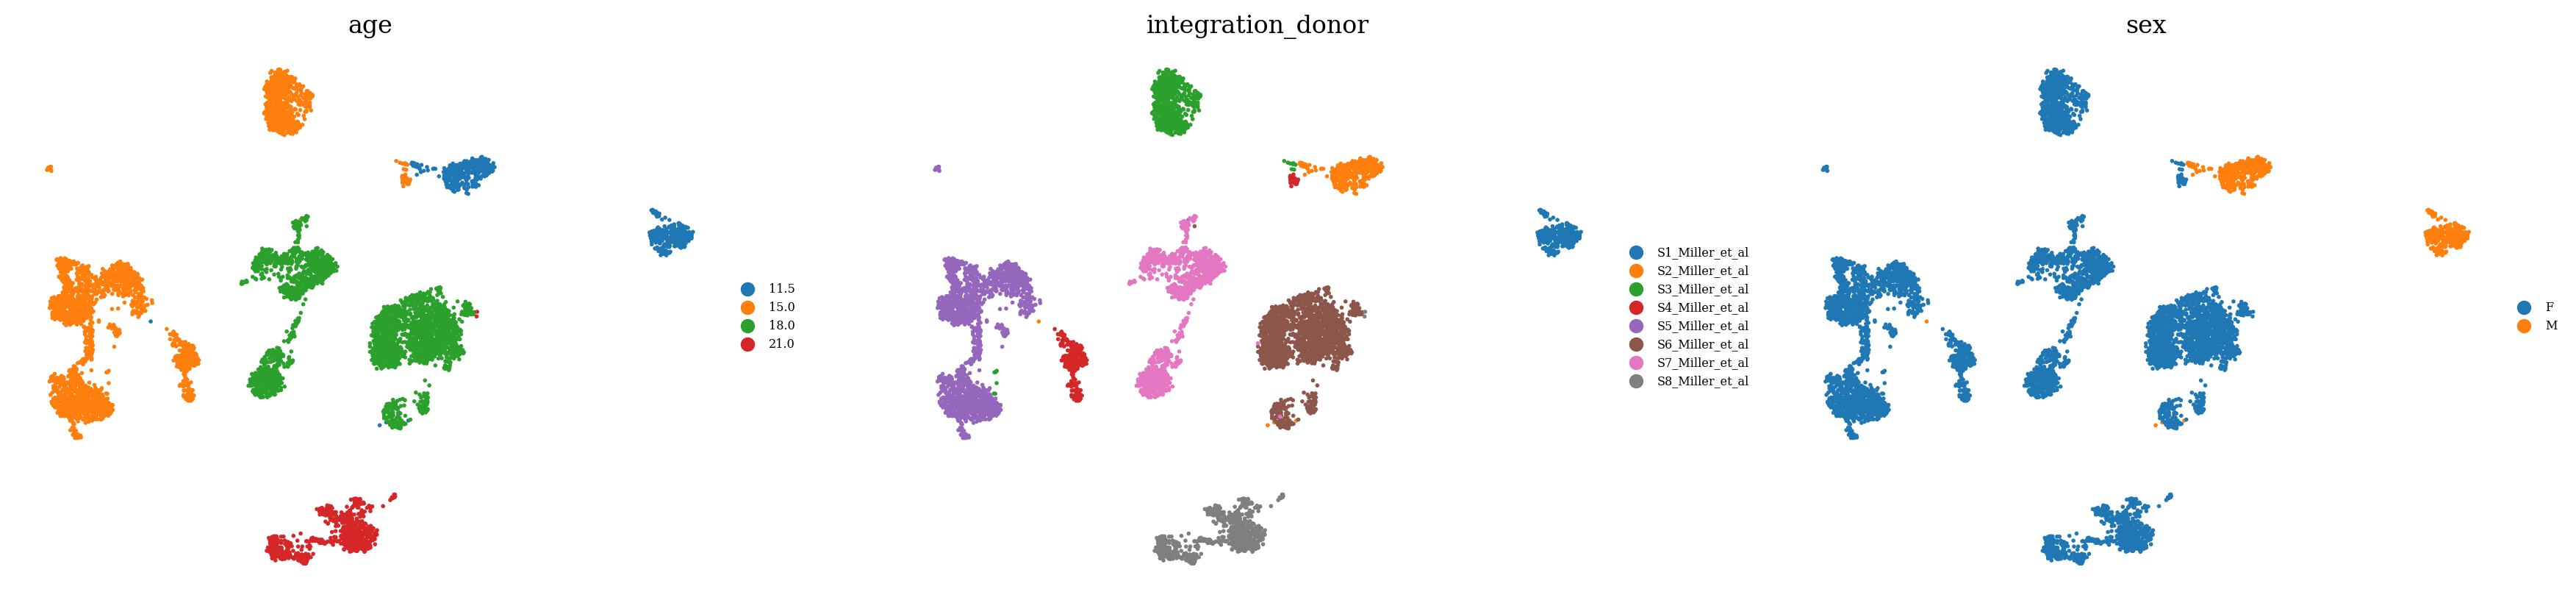

In [19]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

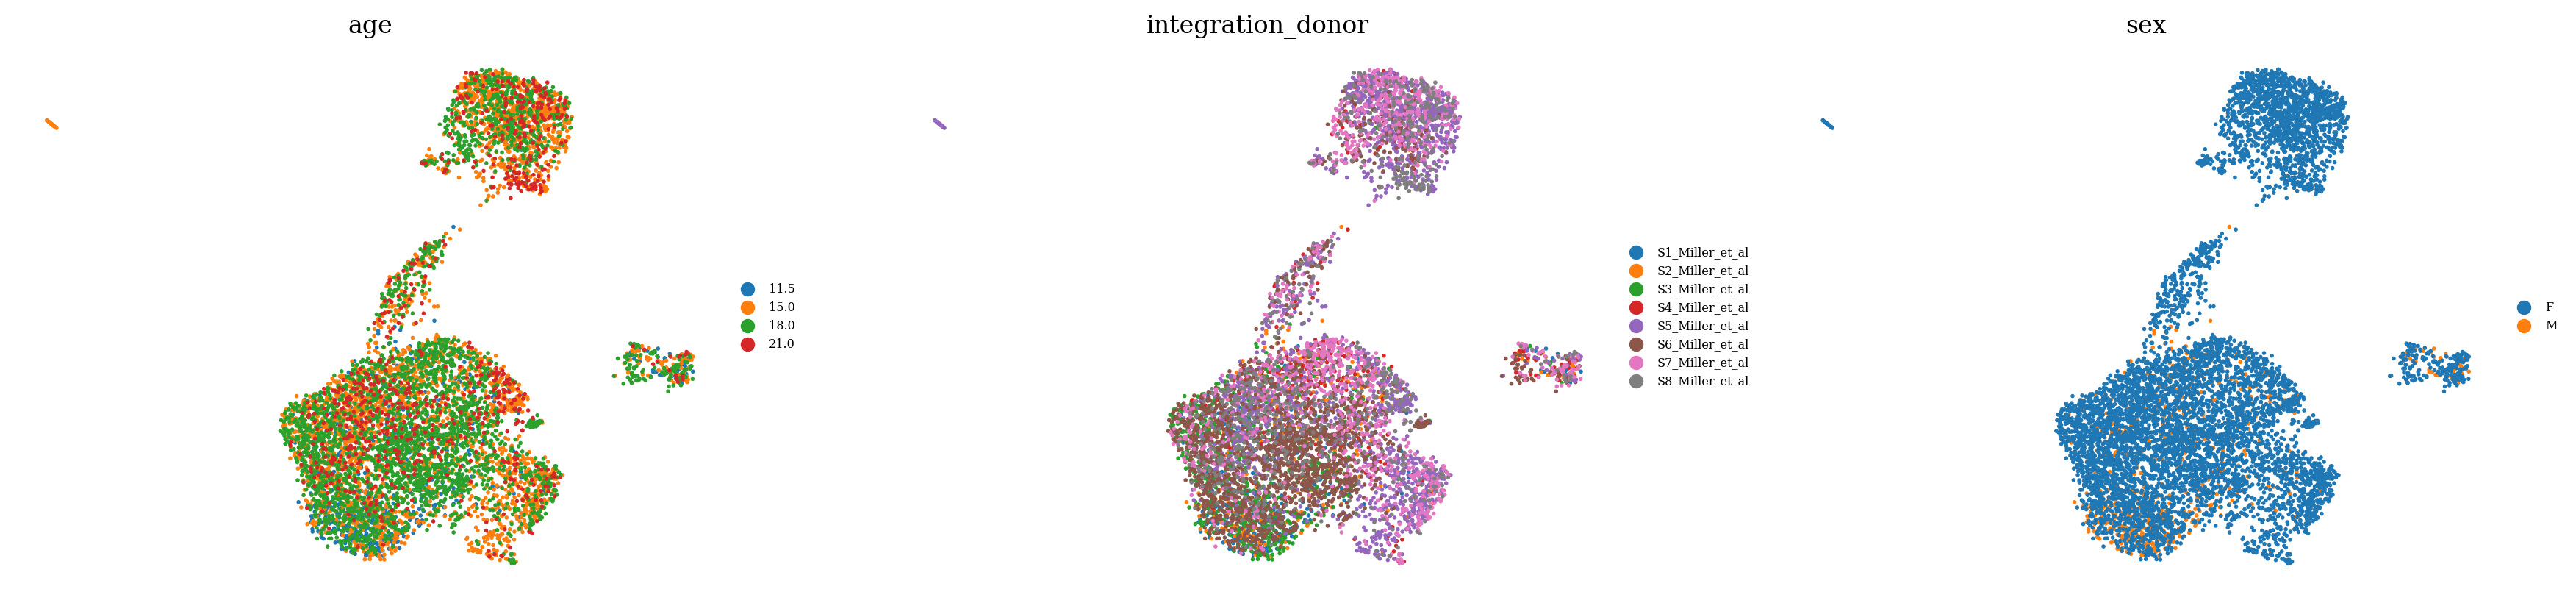

In [20]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [21]:
model.predict()

  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 1/232 [00:00<00:39,  5.82it/s]

  9%|▊         | 20/232 [00:00<00:02, 87.51it/s]

 14%|█▍        | 32/232 [00:00<00:02, 97.78it/s]

 19%|█▉        | 44/232 [00:00<00:02, 89.63it/s]

 23%|██▎       | 54/232 [00:00<00:02, 86.47it/s]

 28%|██▊       | 64/232 [00:00<00:01, 84.33it/s]

 31%|███▏      | 73/232 [00:00<00:01, 82.86it/s]

 35%|███▌      | 82/232 [00:01<00:01, 81.80it/s]

 39%|███▉      | 91/232 [00:01<00:01, 81.36it/s]

 43%|████▎     | 100/232 [00:01<00:01, 80.92it/s]

 47%|████▋     | 109/232 [00:01<00:01, 80.57it/s]

 51%|█████     | 118/232 [00:01<00:01, 80.36it/s]

 55%|█████▍    | 127/232 [00:01<00:01, 80.42it/s]

 59%|█████▊    | 136/232 [00:01<00:01, 80.30it/s]

 62%|██████▎   | 145/232 [00:01<00:01, 80.29it/s]

 66%|██████▋   | 154/232 [00:01<00:00, 80.30it/s]

 70%|███████   | 163/232 [00:02<00:00, 80.15it/s]

 74%|███████▍  | 172/232 [00:02<00:00, 77.51it/s]

 78%|███████▊  | 180/232 [00:02<00:00, 78.17it/s]

 81%|████████  | 188/232 [00:02<00:00, 78.45it/s]

 84%|████████▍ | 196/232 [00:02<00:00, 78.81it/s]

 88%|████████▊ | 205/232 [00:02<00:00, 79.22it/s]

 92%|█████████▏| 214/232 [00:02<00:00, 79.55it/s]

 96%|█████████▌| 222/232 [00:02<00:00, 79.12it/s]

 99%|█████████▉| 230/232 [00:02<00:00, 78.61it/s]

100%|██████████| 232/232 [00:02<00:00, 80.06it/s]

In [22]:
pred_adata = adata[model.test_indices]
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [23]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

0.4346268288365691

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)